**INSTALACIÓN DE VERSION DE PYTORCH COMPATIBLE CON RASPBERRY Y DEPENDENCIAS NECESARIAS**

In [ ]:
!pip install imgaug==0.2.5
!pip install Pillow==5.0.0
!pip install torch==1.3.0+cu100 torchvision==0.4.1+cu100 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


**CONECTA DRIVE CON CÓDIGO PARA PODER UTILIZAR LOS ARCHIVOS QUE HAY EN DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORTAR LIBRERIAS**

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
import random
import sys

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

plt.ion()  

archivo = open("/content/drive/My Drive/Datos_Train_Squeezenet1_1.txt","w")

**BASE DE DATOS ALEATORIA**

In [ ]:
#Definición clases (nombres de las carpetas en la base de datos)
clase1="2-Incendio"
clase2="1-No incendio"

#Directorio con la base de datos original
dir_origen="/content/drive/MyDrive/base de datos final color/"
size=len(os.listdir(dir_origen + str(clase1))) # Retorna una lista del directorio deseado (listdir). con (len) la cantidad de archivos que tiene el directorio
#porc_train=int(0.9*size) # Porcentaje de datos para entrenamiento normalizado a 1 (80% en este ejemplo)
porc_val=int(0.1*size)

#Ciclo para K=10 en validación cruzada, crea las 10 bases de datos 
for i in range(1,11):
    print("base",i)
    dir_base="/content/drive/MyDrive/Base" + str(i) +"/"
    count = 0 #Iniciaclización contador clase 1
    count1 = 0 #Iniciaclización contador clase 2


    if os.path.exists(dir_base):                        #Condicional pregunta si directorio 'base de datos' existe
        shutil.rmtree(dir_base, ignore_errors=False)    #Si existe elimina directorio 
    else:                                                    #Si no existe se crea uno nuevo
        print("directorio no existe, se creara uno nuevo")

    #Creación de los directorios de las bases de datos
    os.mkdir(dir_base) 
    os.mkdir(dir_base + "train") 
    os.mkdir(dir_base + "val")
    os.mkdir(dir_base + "train/2-Incendio" ) 
    os.mkdir(dir_base + "train/1-No incendio")
    os.mkdir(dir_base + "val/2-Incendio" ) 
    os.mkdir(dir_base + "val/1-No incendio")
    
    #límite para que las bases de datos sean distintas durante la validación cruzada.
    lim_sup=porc_val*i
    
    ############## Proceso de asignación de imágenes en val y train de la clase 1 ####################### 
    
    if i==1:
        fires=os.listdir(dir_origen + str(clase1))
        #print("fires")
        #print(fires)
        random.shuffle(fires) 
  
    for file in fires: 
        
        if i==1:
            if count >=lim_sup-porc_val and count < lim_sup:       
                dir_destino=dir_base + "val/" + str(clase1) + "/"
            if count >= lim_sup:       
                dir_destino=dir_base + "train/" + str(clase1) + "/"
        
        if i==10:
            if count >=lim_sup-porc_val and count < lim_sup:                 
                dir_destino=dir_base + "val/" + str(clase1) + "/"
            if count < lim_sup-porc_val: 
                dir_destino=dir_base + "train/" + str(clase1) + "/"

        if i>=2 and i<=9:
            if count >=lim_sup-porc_val and count < lim_sup:                
                dir_destino=dir_base + "val/" + str(clase1) + "/"
            if count < lim_sup-porc_val or count>=lim_sup: 
                dir_destino=dir_base + "train/" + str(clase1) + "/"

        print("fires ",count)
        shutil.copy(dir_origen + str(clase1) + "/" + str(file),dir_destino + str(file))    
        count += 1

    #####################################################################################################

    ############## Proceso de asignación de imágenes en val y train de la clase 2 ####################### 
    
    if i==1:
        no_fires=os.listdir(dir_origen + str(clase2))
        #print("no_fires")
        #print(no_fires)
        random.shuffle(no_fires) 


    for file in no_fires: 
            
        if i==1:
            if count1 >=lim_sup-porc_val and count1 < lim_sup:             
                dir_destino=dir_base + "val/" + str(clase2) + "/"
            if count1 >= lim_sup:    
                dir_destino=dir_base + "train/" + str(clase2) + "/"
        if i==10:
            if count1 >=lim_sup-porc_val and count1 < lim_sup:              
                dir_destino=dir_base + "val/" + str(clase2) + "/"
            if count1 < lim_sup-porc_val:      
                dir_destino=dir_base + "train/" + str(clase2) + "/"

        if i>=2 and i<=9:
            if count1 >=lim_sup-porc_val and count1 < lim_sup:                
                dir_destino=dir_base + "val/" + str(clase2) + "/"
            if count1 < lim_sup-porc_val or count1>=lim_sup:      
                dir_destino=dir_base + "train/" + str(clase2) + "/"
        print("no_fires ",count1)
        shutil.copy(dir_origen + str(clase2) + "/" + str(file),dir_destino + str(file))    
        count1 += 1

    #####################################################################################################


**CARGA DE DATASET Y APLICACIÓN DE TRANSFORMACIONES**

In [ ]:
name_model='SQUEEZENET1_1'
k_cont=1         #Número de base a seleccionar
mod_cont=19

print("Modelo = ",name_model)
archivo.write("\n###################################################################")

while(k_cont<11):

  ###############################CARGA DE DATASET Y APLICACIÓN DE TRANSFORMACIONES################################

  data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(224), #recorta la imagen en forma aleatoria (224x224 pixeles)
          transforms.RandomHorizontalFlip(), #rota imagen horizontalmente 
          transforms.ToTensor(),             #convierte la imagen a formato matricial 
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normaliza cada pixel segun la media y desviacion estandar 
      ]),
      'val': transforms.Compose([
          transforms.Resize(256), #reduce la imagen por submuestreo 
          transforms.CenterCrop(224), #recorta las imagenes,toma punto de referencia el centro
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }
  
  if(k_cont==1):
    data_dir = '/content/drive/My Drive/Base1' #dirección de la carpeta de base de datos
    save_model=name_model +' model_It1.pth'

  if(k_cont==2):
    data_dir = '/content/drive/My Drive/Base2' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It2.pth'

  if(k_cont==3):
    data_dir = '/content/drive/My Drive/Base3' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It3.pth'
  
  if(k_cont==4):
    data_dir = '/content/drive/My Drive/Base4' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It4.pth'

  if(k_cont==5):
    data_dir = '/content/drive/My Drive/Base5' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It5.pth'

  if(k_cont==6):
    data_dir = '/content/drive/My Drive/Base6' #dirección de la carpeta de base de datos
    save_model=name_model +' model_It6.pth'

  if(k_cont==7):
    data_dir = '/content/drive/My Drive/Base7' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It7.pth'

  if(k_cont==8):
    data_dir = '/content/drive/My Drive/Base8' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It8.pth'
  
  if(k_cont==9):
    data_dir = '/content/drive/My Drive/Base9' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It9.pth'

  if(k_cont==10):
    data_dir = '/content/drive/My Drive/Base10' #dirección de la carpeta de base de datos 
    save_model=name_model +' model_It10.pth'
  
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),  #carga las imagenes de train y val
                                            data_transforms[x])         #de la base de datos y les aplica las transformaciones
                    for x in ['train', 'val']}
  
  print(data_dir) 
  #batch_size = número de imagenes por lote
  #shuffle = true , reorganizacion de datos en cada epoca  

                
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, #reorganiza las imagenes para cada iteracion 
                                              shuffle=True, num_workers=4)
                for x in ['train', 'val']}

  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}  #tamaño del conjunto de datos 
  class_names = image_datasets['train'].classes  #clases de la base de datos 
  #print(class_names)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #identifica si el codigo se ba a correr en GPU  o CPU
  #print(device)

  class_to_idx = image_datasets['train'].class_to_idx
  print(class_to_idx)

  print ("Dataset Size: "+ str(dataset_sizes) + "\n")
  n_class = len(class_names)
  print ("Number of classes: "+ str(n_class) + "\n")
  print ("Classes: "+ str(class_names) + "\n")
  print (len(dataloaders))

  ###############################FUNCIÓN DE ENTRENAMIENTO###############################

  def train_model(model, criterion, optimizer, scheduler, num_epochs):
      since = time.time()

      yy_train=[]
      xx_train=[]
      yy_val=[]
      xx_val=[]
      sen_train=[]
      sen_val=[]
      esp_train=[]
      esp_val=[]
      prec_train=[]
      prec_val=[]
      fpr_train=[]
      fpr_val=[]
      acc_train=[]
      acc_val=[]
      predict=torch.cuda.FloatTensor(0)
      best_predict=torch.cuda.FloatTensor(0)
      labels_real=torch.cuda.FloatTensor(0)
      best_labels=torch.cuda.FloatTensor(0)
      prob=torch.cuda.FloatTensor(0)
      best_prob=torch.cuda.FloatTensor(0)    
      cont_epoch = 0
      epoch_min = 0
      #Inicialización en cero de variables Verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos
      VP=0
      FP=0
      VN=0
      FN=0
      #archivo = open("/content/drive/My Drive/Datos_Resnet.txt", 'w')
      #archivo.write("Resnet18\n")
      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0
      acc_aux = 0.0
      best_sen = 0.0
      specificity = 0.0
      precision= 0.0

      for epoch in range(num_epochs):
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)

          # Cada época tiene una fase de entrenamiento y validación
          for phase in ['train', 'val']:
              if phase == 'train':
                  #scheduler.step()
                  model.train()  # Set model to training mode  # Poner el modelo en modo de entrenamiento
              else:
                  model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_corrects = 0

              # Iterate over data. # Iterar sobre los datos.
            
              predict=torch.cuda.FloatTensor(0)
              labels_real=torch.cuda.FloatTensor(0)
              prob=torch.cuda.FloatTensor(0)
              for inputs, labels in dataloaders[phase]:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)

                      sm = torch.nn.Softmax(dim=1)
                      probabilities = sm(outputs)
                      probabilities = probabilities[:,1]
                      valores, preds = torch.max(outputs, 1)
                      #print(type(phase))
                      loss = criterion(outputs, labels)

                      if phase == 'val':
                        prob = torch.cat((prob,probabilities),0)
                        predict=torch.cat((predict.float(),preds.float()),0)
                        labels_real=torch.cat((labels_real.float(),labels.data.float()),0)


                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
                  
                  #Prueba Verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos

                  for i in range (len(labels.data)):
                    if (labels.data[i]== preds[i]):
                    #print(i)
                      if (labels.data[i]== 1):
                        VP+=1;
                      else:
                        VN+=1;
                    else:
                      if(labels.data[i]== 1):
                        FP+=1;
                      else:
                        FN+=1;

              #px1=1-especificidad
              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]
              
              if acc_aux<epoch_acc:
                acc_aux=epoch_acc
              
              #33333 Condicional durante entrenamiento
              if phase == 'train':
                scheduler.step()

                acc_train.append(epoch_acc)
                sen_train.append(VP/(VP+FN))
                esp_train.append(VN/(VN+FP))
                prec_train.append(VP/(VP+FP))
                fpr_train.append(1- esp_train[epoch])
                print("VP= " + str(VP) + " VN= " + str(VN) + " FP= " + str(FP) + " FN= " + str(FN))
                print('Sensibilidad: {:.4f} Especificidad: {:.4f} Precisión: {:.4f}'.format(sen_train[epoch], esp_train[epoch], prec_train[epoch]))
                yy_train.append(epoch_loss)
                xx_train.append(epoch)                  
                writer.add_scalars("Loss", {"Loss/train": epoch_loss}, epoch)  
                  #archivo.close() 

              ###### Condicional durante validación
              if phase == 'val':
                
                #Calcula sensibilidad y especificidad en validación
                acc_val.append(epoch_acc)
                sen_val.append(VP/(VP+FN))
                esp_val.append(VN/(VN+FP))
                prec_val.append(VP/(VP+FP))
                fpr_val.append(1- esp_train[epoch])
                print("VP= " + str(VP) + " VN= " + str(VN) + " FP= " + str(FP) + " FN= " + str(FN))
                print('Sensibilidad: {:.4f} Especificidad: {:.4f} Precisión: {:.4f}'.format(sen_val[epoch], esp_val[epoch], prec_val[epoch]))
                if epoch == 0:
                  stop_val=10

                yy_val.append(epoch_loss)
                xx_val.append(epoch)
                writer.add_scalars("Loss", {"Loss/val":epoch_loss}, epoch)             

                if epoch_loss>stop_val:
                  cont_epoch+=1
                  print("cont= "+str(cont_epoch))
                  
                else:
                  if cont_epoch < 30:
                    dif_val = stop_val-epoch_loss
                    porc_val_back=0.1*stop_val
                    if dif_val>porc_val_back:
                      cont_epoch=0
                      stop_val=epoch_loss 
                      epoch_min=epoch
                      print("perdida disminuyendo ",epoch_min)
                      best_sen=sen_val[epoch]
                      best_acc = epoch_acc
                      specificity = esp_val[epoch]
                      precision = prec_val[epoch] 
                      best_model_wts = copy.deepcopy(model.state_dict())
                      best_predict=predict
                      best_labels=labels_real
                      best_prob=prob                     
                    else:
                      cont_epoch+=1
                      print("cont= "+str(cont_epoch))
                    
              VP=0
              FP=0
              VN=0
              FN=0
              print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))


      #print((predict))    
      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f} Sen: {:.4f} Esp: {:.4f}'.format(best_acc, best_sen, specificity))

      # load best model weights
      model.load_state_dict(best_model_wts)
      #writer.flush()
      writer.close()
      return model, yy_train, xx_train, yy_val, xx_val, epoch_min, stop_val, acc_train, acc_val, best_predict, best_labels, best_prob, best_acc, best_sen, specificity, precision, time_elapsed, acc_aux #retorna el mejor modelo 

    ############################### CARGA DE PARAMETROS Y MODELO PREENTRENADO ############################### 

  model_ft = models.squeezenet1_1(pretrained=True)

  num_classes=2
  model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
  model_ft.num_classes = num_classes

  model_ft = model_ft.to(device)
  criterion = nn.CrossEntropyLoss()

  # Observe that all parameters are being optimized
  #Implementa descenso de gradiente estocástico (opcionalmente con impulso).
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005)

  # Decay LR by a factor of 0.1 every 7 epochs
  #Decae la tasa de aprendizaje de cada grupo de parámetros por gamma en cada etapa de step_size. 
  #Tenga en cuenta que dicho deterioro puede ocurrir simultáneamente con otros cambios en la tasa de aprendizaje 
  #desde fuera de este programador. Cuando last_epoch = -1, establece lr inicial como lr.
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.05)
  #print(model_ft)

  ############################### ENTRENAMIENTO DEL MODELO ###############################

  model_ft, yy_train, xx_train, yy_val, xx_val, epoch_min, stop_val, acc_train, acc_val, best_predict, best_labels, best_prob, best_acc, best_sen, specificity, precision, time_train, acc_aux = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

  ############################### IMPRESIÓN DE PARAMETROS ###############################

  print("Datos perdidas")
  print("xx_train = " + str(xx_train))
  print("yy_train = "+ str(yy_train))
  print("xx_val = "+ str(xx_val))
  print("yy_val = "+ str(yy_val))
  print("epoch_min = "+ str(epoch_min))
  print("stop_val = "+ str(stop_val))
  print("\n")

  print("Datos accuracy")

  for i in range(len(acc_val)):
    acc_val[i]=acc_val[i].tolist()
    acc_train[i]=acc_train[i].tolist()
  print("acc_train = " + str(acc_train))
  #print("xx_train = " + str(xx_train))
  print("acc_val = "+ str(acc_val))
  #print("xx_val = "+ str(xx_val))
  #print(len(best_prob))

  print("\nDatos curva ROC")
  best_labels=best_labels.tolist()
  best_prob=best_prob.tolist()
  print("best_labels = "+ str(best_labels))
  print("best_prob = "+ str(best_prob))

  print("\nMetricas de validación")
  best_acc=best_acc.tolist()
  acc_aux=acc_aux.tolist()
  print("Best_acc = "+ str(best_acc))
  print("acc_aux = "+ str(acc_aux))
  print("Recall = "+ str(best_sen))
  print("Precisión = "+ str(precision))
  print("Especificidad = "+ str(specificity))
  print('Tiempo = {:.0f}s'.format(time_train))




  ############################### GUARDADO DE PARAMETROS EN TXT ###############################
  archivo.write("\n")
  archivo.write("\n######## Base" + str(k_cont) + " ########")
  archivo.write("\n#MODELO = " + name_model )
  archivo.write("\n#Datos perdidas")
  archivo.write("\nxx_train" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(xx_train))
  archivo.write("\nyy_train" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(yy_train))
  archivo.write("\nxx_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(xx_val))
  archivo.write("\nyy_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(yy_val))
  archivo.write("\nepoch_min" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(epoch_min))
  archivo.write("\nstop_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(stop_val))
  archivo.write("\n")

  archivo.write("\n#Datos accuracy")
  archivo.write("\nacc_train" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(acc_train))
  archivo.write("\nacc_val" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(acc_val))
  archivo.write("\n")

  archivo.write("\n#Datos curva ROC")
  archivo.write("\nbest_labels" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_labels))
  archivo.write("\nbest_prob" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_prob))
  archivo.write("\n")

  archivo.write("\n#Metricas de validación")
  archivo.write("\nBest_acc" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_acc))
  archivo.write("\nacc_aux" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(acc_aux))
  archivo.write("\nRecall" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(best_sen))
  archivo.write("\nPrecisión" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(precision))
  archivo.write("\nEspecificidad" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(specificity))
  archivo.write("\nTiempo" + str(k_cont)  + "_"  + str(mod_cont) + " = " + str(time_train))


  ############################### GUARDADO DE MODELO ###############################

  #print(torch.__version__)

  model_ft.class_to_idx = image_datasets['train'].class_to_idx
  model_ft.cpu()
  torch.save({'arch': name_model,
              'state_dict': model_ft.state_dict(), 
              'class_to_idx': model_ft.class_to_idx}, 
              save_model)
  k_cont+=1

In [ ]:
archivo.close() 

**DATOS GUARDADOS**

In [ ]:
###################################################################

######## Base1 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_1 = [0.35097611082924735, 0.17876201106442347, 0.13817015860551668, 0.14663053379382615, 0.11386211720513709, 0.09341235363189085, 0.0816470291695477, 0.07960487089039367, 0.07420765606709469, 0.07001945523568141, 0.06961554046030398, 0.06696315797758691, 0.06619799137115479, 0.07179634460696467, 0.0652342097994722, 0.07998589220238321, 0.06904268835061862, 0.0686251586234128, 0.06823513721242364, 0.06366002202769856, 0.06987428683557628, 0.07227739150877352, 0.06794219215710957, 0.06694743522891292, 0.07457517834357273]
xx_val1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_1 = [0.1833572569820616, 0.3311518867810567, 0.38436011936929493, 0.1933483941687478, 0.10121215449439155, 0.07351227866278755, 0.07411733600828382, 0.07567491332689921, 0.07868097954326206, 0.07803875009218851, 0.07828587889671326, 0.07814806302388509, 0.07796271211571164, 0.07785652743445502, 0.07791594200664097, 0.07791770431730483, 0.0779229074716568, 0.07793185909589131, 0.07792577975326115, 0.07792830732133653, 0.077928227186203, 0.07792807751231723, 0.07792798976103464, 0.07792791061931187, 0.077928094069163]
epoch_min1_1 = 5
stop_val1_1 = 0.07351227866278755

#Datos accuracy
acc_train1_1 = [0.8518518518518519, 0.9280864197530864, 0.9521604938271605, 0.9410493827160493, 0.9540123456790123, 0.9635802469135802, 0.9728395061728395, 0.9719135802469135, 0.9734567901234568, 0.9746913580246913, 0.9740740740740741, 0.9746913580246913, 0.975, 0.9719135802469135, 0.9765432098765432, 0.9691358024691358, 0.9734567901234568, 0.9762345679012345, 0.9746913580246913, 0.9777777777777777, 0.9719135802469135, 0.9728395061728395, 0.975, 0.9740740740740741, 0.9722222222222222]
acc_val1_1 = [0.9305555555555556, 0.8250000000000001, 0.8555555555555556, 0.9416666666666667, 0.9611111111111111, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9777777777777779, 0.9750000000000001, 0.9777777777777779, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001]

#Datos curva ROC
best_labels1_1 = [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
best_prob1_1 = [0.8834507465362549, 0.9999978542327881, 1.0, 0.9999895095825195, 0.028354989364743233, 0.9999809265136719, 1.0, 0.5480746626853943, 0.9999983310699463, 0.0008351121214218438, 0.9999933242797852, 0.9999991655349731, 0.10067915916442871, 0.9997517466545105, 0.0002367212437093258, 0.9999997615814209, 0.9996166229248047, 0.0034664329141378403, 0.9999936819076538, 1.0, 0.0010345554910600185, 0.9996658563613892, 1.0, 0.9999903440475464, 0.001979004591703415, 0.9981185793876648, 0.014112107455730438, 0.0005836220807395875, 0.003972067963331938, 0.001837655552662909, 0.09183617681264877, 0.0071129100397229195, 0.00915608461946249, 3.464988185442053e-05, 0.0048720319755375385, 0.0014841781230643392, 0.002967698033899069, 0.09236051142215729, 0.9999997615814209, 0.0026611811481416225, 0.022945720702409744, 0.9999959468841553, 0.00018484870088286698, 6.701933671138249e-06, 0.0012909035431221128, 0.999985933303833, 1.0, 0.0006711152382194996, 1.4133475815469865e-05, 0.00850109662860632, 0.021874884143471718, 0.0006766336155124009, 0.2388790100812912, 0.004026912152767181, 0.0008835141779854894, 0.9446420073509216, 0.9999998807907104, 0.001056973240338266, 0.14410686492919922, 1.0, 0.9999997615814209, 0.014874971471726894, 9.117287117987871e-05, 0.9998979568481445, 0.999996542930603, 0.02262023836374283, 0.017091957852244377, 0.9999650716781616, 0.9999967813491821, 0.004808401223272085, 0.0001034577508107759, 1.0, 1.0, 0.9906476140022278, 0.9980567097663879, 0.999994158744812, 0.9998308420181274, 0.9999898672103882, 0.9765501618385315, 1.0, 0.8941614627838135, 0.007522034924477339, 0.0017255337443202734, 0.08180088549852371, 0.9999891519546509, 0.0025454636197537184, 0.008482483215630054, 0.9988609552383423, 0.0507829524576664, 0.0013329205103218555, 0.012626886367797852, 0.0007596984505653381, 0.9971964359283447, 0.9999974966049194, 0.0005100451526232064, 0.9999998807907104, 0.0011134401429444551, 0.013203772716224194, 0.9999843835830688, 0.018475448712706566, 0.9999629259109497, 0.9999877214431763, 0.9991432428359985, 0.9888355135917664, 0.6860890984535217, 0.9977545142173767, 0.9995878338813782, 0.0024548990186303854, 0.6268261075019836, 0.001302504213526845, 0.005014170426875353, 0.07016599178314209, 0.00021663242659997195, 0.9932867884635925, 0.9996069073677063, 0.9999995231628418, 1.0, 0.9575138092041016, 0.9999998807907104, 0.00040881618042476475, 0.022250166162848473, 0.003883168799802661, 0.9997116923332214, 5.045334546593949e-05, 0.9998019337654114, 0.002382602309808135, 0.0331643670797348, 0.017595971003174782, 0.0009850909700617194, 0.001094916253350675, 0.009663958102464676, 0.9999977350234985, 0.9999879598617554, 0.999993085861206, 0.006430103909224272, 0.003693785984069109, 0.23405538499355316, 0.9999890327453613, 0.0706082135438919, 0.9999995231628418, 0.9997914433479309, 0.9992963075637817, 0.9999996423721313, 0.0008049149764701724, 0.004649207927286625, 0.9999245405197144, 0.9999856948852539, 0.06262744963169098, 0.9998846054077148, 0.9965260624885559, 0.9999991655349731, 0.02739545702934265, 0.008669937960803509, 1.0, 0.009735542349517345, 0.00019254046492278576, 0.11649279296398163, 0.010617225430905819, 1.0, 0.9999994039535522, 0.9999932050704956, 0.9999997615814209, 0.9951717257499695, 0.03597564622759819, 0.01059943251311779, 3.619024937506765e-05, 0.001418492291122675, 0.1370057761669159, 0.006383751984685659, 0.9989135265350342, 1.0, 0.9464085102081299, 0.9999065399169922, 0.5726462602615356, 0.23788049817085266, 0.01893046870827675, 0.9999849796295166, 0.001056973240338266, 0.9951401948928833, 0.0020608752965927124, 0.9999996423721313, 0.9943141341209412, 0.00016547201084904373, 0.9999998807907104, 0.9999984502792358, 0.01645420864224434, 0.09106376767158508, 0.004567839205265045, 1.0, 0.9999966621398926, 0.013175520114600658, 0.9999771118164062, 1.0, 0.9997177720069885, 1.0, 0.002954371040686965, 0.9999855756759644, 0.00674621295183897, 1.0, 0.9998243451118469, 0.9972544312477112, 0.9999892711639404, 0.008458374999463558, 1.0, 0.0004283551825210452, 0.9772770404815674, 0.9898978471755981, 0.03862495347857475, 1.0, 0.15252381563186646, 0.9999946355819702, 0.00898722093552351, 0.6177778840065002, 0.9999994039535522, 0.02244444005191326, 0.9998438358306885, 0.7811441421508789, 0.9999667406082153, 0.0005068419268354774, 0.9528663158416748, 0.0033818623051047325, 0.0011686666402965784, 0.8516762256622314, 0.07768138498067856, 0.030391037464141846, 0.9999376535415649, 0.011572539806365967, 0.003235460491850972, 0.4105096161365509, 1.0, 0.0005568956257775426, 0.8799218535423279, 0.9973303079605103, 0.014136083424091339, 0.999984622001648, 0.9999196529388428, 0.9999961853027344, 0.007654920220375061, 0.0017491125036031008, 0.0017379383789375424, 0.017712565138936043, 0.9999982118606567, 0.9999983310699463, 0.9950639605522156, 0.005140878725796938, 0.8655853867530823, 0.9704030156135559, 0.9999945163726807, 0.000691940716933459, 0.9647107720375061, 0.9999924898147583, 0.9932663440704346, 9.005219908431172e-05, 1.0, 0.0068696411326527596, 0.004200400318950415, 0.0024394672363996506, 0.005234909243881702, 0.05630923807621002, 0.999995231628418, 0.9999998807907104, 0.991283655166626, 0.9999746084213257, 0.14430548250675201, 0.9999725818634033, 0.9999971389770508, 0.9999998807907104, 0.007417358923703432, 1.0, 0.9999465942382812, 0.014700007624924183, 1.0, 0.0035574883222579956, 0.9868929982185364, 0.0002357104531256482, 0.0027528204955160618, 0.005666785873472691, 0.0005515633965842426, 0.015388645231723785, 0.03145255893468857, 0.999336302280426, 0.9999945163726807, 0.00010681481944629923, 0.04527644068002701, 0.00025091299903579056, 0.8294497132301331, 0.6463594436645508, 0.9998825788497925, 0.00650979345664382, 0.05615653842687607, 0.9283967018127441, 0.9999929666519165, 0.01407988928258419, 0.002713876310735941, 0.999679684638977, 1.0, 0.0004895555321127176, 0.9998457431793213, 0.9951634407043457, 0.9999619722366333, 0.9517695903778076, 0.001616494613699615, 4.004367292509414e-05, 0.0038831152487546206, 0.001474782358855009, 0.001765052555128932, 1.0, 0.0011722908820956945, 0.005480405408889055, 0.009415168315172195, 0.004643227439373732, 0.00012118821177864447, 1.0, 0.1275477111339569, 0.0006653873715549707, 0.9998862743377686, 0.002097540069371462, 0.9989376664161682, 0.0018094098195433617, 0.01805942691862583, 0.9999963045120239, 0.0028086837846785784, 0.009820476174354553, 0.9999911785125732, 0.9999828338623047, 0.21475984156131744, 0.0015237716725096107, 1.0, 0.9999982118606567, 0.0015325157437473536, 0.9999984502792358, 0.9999880790710449, 0.9998941421508789, 0.0007608746527694166, 0.030068764463067055, 0.00017960176046472043, 0.1079869419336319, 0.9879383444786072, 0.013180827721953392, 0.9988186955451965, 8.467656880384311e-05, 1.0, 0.03493034467101097, 0.02303774654865265, 0.000328288966557011, 0.0040481542237102985, 1.0, 0.9999988079071045, 0.014605371281504631, 0.058752357959747314, 0.11805778741836548, 0.9900464415550232, 0.9999992847442627, 0.043132226914167404, 0.004232245963066816, 0.9999212026596069, 0.015688607469201088, 0.6131539344787598, 0.019762154668569565, 0.018565943464636803]

#Metricas de validación
Best_acc1_1 = 0.9722222222222222
acc_aux1_1 = 0.9777777777777779
Recall1_1 = 0.9775280898876404
Especificidad1_1 = 0.967032967032967
Tiempo1_1 = 740.4234447479248

######## Base2 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train2_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_1 = [0.17343963693689418, 0.11908087071813184, 0.11074095894525081, 0.08632682326399249, 0.09318289410920791, 0.07884981687422152, 0.06041257289456733, 0.05728095928092062, 0.06026701986053844, 0.06046820867944647, 0.06445175992485917, 0.06266592924977527, 0.06392243776792361, 0.06331264292016442, 0.05471429784356812, 0.05695392081031093, 0.05989777213997311, 0.05784278592945617, 0.05001437572049506, 0.056824166943997514, 0.055321492199544554, 0.057238221757205915, 0.05500820404217567, 0.052427309273201744, 0.059503733302340094]
xx_val2_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_1 = [0.3983215007517073, 0.14886672761705186, 0.08822774423493279, 0.07486769755681356, 0.27284639610184563, 0.08709027965863546, 0.0828800701432758, 0.0804080585638682, 0.08308203419049581, 0.08072264326943292, 0.08082667854097154, 0.08130270375145807, 0.08147640294498867, 0.08159390952852037, 0.08174881339073181, 0.08174867894914416, 0.0817562139696545, 0.08175387250052558, 0.08176490664482117, 0.08177663485209147, 0.0817766269048055, 0.0817766375011868, 0.08177666498555078, 0.08177668584717644, 0.08177667756875356]
epoch_min2_1 = 3
stop_val2_1 = 0.07486769755681356

#Datos accuracy
acc_train2_1 = [0.9330246913580247, 0.9515432098765432, 0.9564814814814815, 0.9700617283950617, 0.9638888888888889, 0.9728395061728395, 0.9799382716049383, 0.9762345679012345, 0.9787037037037036, 0.9765432098765432, 0.9765432098765432, 0.9734567901234568, 0.9753086419753086, 0.9756172839506173, 0.9814814814814815, 0.9799382716049383, 0.9802469135802468, 0.9796296296296296, 0.9802469135802468, 0.9787037037037036, 0.9820987654320987, 0.9783950617283951, 0.979320987654321, 0.9814814814814815, 0.9774691358024691]
acc_val2_1 = [0.8583333333333334, 0.9555555555555556, 0.9694444444444444, 0.9750000000000001, 0.9, 0.9694444444444444, 0.9694444444444444, 0.9694444444444444, 0.9694444444444444, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222]

#Datos curva ROC
best_labels2_1 = [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
best_prob2_1 = [0.9999991655349731, 0.0063193924725055695, 0.9999967813491821, 0.9989355206489563, 0.011137799359858036, 0.9998300075531006, 0.0014315955340862274, 0.99770587682724, 0.0137485908344388, 0.00033530787914060056, 0.9999998807907104, 1.0, 0.0023988215252757072, 0.9999998807907104, 0.0009502803441137075, 0.02989298850297928, 0.9787259101867676, 0.04746141657233238, 0.9999685287475586, 0.9999974966049194, 0.0019986939150840044, 1.0, 0.9856365919113159, 0.028258705511689186, 0.0017932539340108633, 0.00010446595842950046, 0.0748366042971611, 0.7550258040428162, 1.4296651897893753e-05, 0.9999451637268066, 0.0001124213304137811, 1.0, 0.9938888549804688, 0.009657839313149452, 1.0, 0.0017421774100512266, 1.6910122212721035e-05, 0.9999825954437256, 1.0, 0.9977331161499023, 0.018634719774127007, 0.8872397541999817, 0.9998860359191895, 0.005370601546019316, 3.0631204595010786e-07, 0.9999958276748657, 0.06626785546541214, 0.9999655485153198, 0.0014194917166605592, 0.9999997615814209, 0.0009670490399003029, 0.9999510049819946, 0.0016820253804326057, 0.999996542930603, 0.9896642565727234, 0.9968434572219849, 0.0002493090578354895, 0.9998186230659485, 0.8772584199905396, 0.1264573335647583, 0.001358436536975205, 0.014433255419135094, 0.9999988079071045, 0.992960512638092, 1.2201470553918625e-06, 0.9999992847442627, 0.9999432563781738, 1.0, 0.029121074825525284, 0.9235892295837402, 0.9999985694885254, 0.021200409159064293, 0.9999419450759888, 0.9999797344207764, 0.07781431823968887, 0.12881851196289062, 0.9999997615814209, 0.9999933242797852, 0.00951744057238102, 0.9945713877677917, 1.0, 0.9287919998168945, 0.011086146347224712, 0.9591124057769775, 0.45482155680656433, 1.0, 0.9998812675476074, 0.014186117798089981, 0.9820535182952881, 0.03179449588060379, 0.0033547121565788984, 0.012325902469456196, 0.011542817577719688, 0.00039428233867511153, 0.00012111116666346788, 0.9999957084655762, 0.9999997615814209, 0.9997758269309998, 0.008593679405748844, 0.0007332321256399155, 0.9999938011169434, 0.9960817694664001, 0.006276915315538645, 0.0031011367682367563, 0.0008148521883413196, 0.9947280287742615, 0.9961536526679993, 0.0026098471134901047, 0.9998601675033569, 0.9986916184425354, 0.9975771307945251, 0.0007920265779830515, 0.99981290102005, 0.24058428406715393, 1.0, 0.01073169894516468, 0.9999327659606934, 0.0018873304361477494, 0.003795263124629855, 0.10181104391813278, 0.9340214133262634, 0.9999245405197144, 0.0056879399344325066, 0.9809212684631348, 0.7676942944526672, 0.027687596157193184, 0.00015459212590940297, 0.9985591769218445, 0.00010805553029058501, 0.9995610117912292, 0.00737349595874548, 0.9867051243782043, 0.9997536540031433, 0.0012079679872840643, 0.08697300404310226, 0.9999884366989136, 0.999879002571106, 0.028422774747014046, 0.9999997615814209, 0.999991774559021, 0.9670959711074829, 0.00889615248888731, 0.76414555311203, 0.9999969005584717, 1.0, 0.9999754428863525, 0.9871423244476318, 0.9271060824394226, 1.0, 0.6522232294082642, 3.9226988519658335e-06, 0.9999991655349731, 0.0018219470512121916, 0.0020195518154650927, 0.9999966621398926, 0.0012491036904975772, 0.00010484446829650551, 0.009978345595300198, 0.999961256980896, 0.9973047971725464, 0.9999672174453735, 0.00042137803393416107, 0.9999994039535522, 0.08310700207948685, 0.9991305470466614, 0.0008466698345728219, 0.9999994039535522, 1.0, 0.008894671685993671, 0.0038280929438769817, 0.9912003874778748, 0.0005155698163434863, 5.229368980508298e-05, 0.9999996423721313, 0.004436813294887543, 0.002253228798508644, 0.005148224998265505, 0.9619908332824707, 0.011563500389456749, 0.09870956838130951, 0.00036724976962432265, 0.9945942759513855, 0.019353220239281654, 0.9999998807907104, 0.00023523987329099327, 0.03939182311296463, 0.0022985271643847227, 0.9999464750289917, 0.999897837638855, 1.0, 0.9999740123748779, 0.4573298990726471, 0.00016227403830271214, 0.9976096153259277, 0.9996988773345947, 0.021075593307614326, 0.9980339407920837, 0.9947336912155151, 8.810458530206233e-05, 0.5483481884002686, 0.002363678067922592, 0.06979814916849136, 0.00024081360606942326, 0.03703978285193443, 0.9998648166656494, 0.9999614953994751, 0.016993248835206032, 0.061737991869449615, 0.009454269893467426, 0.03772793710231781, 0.9996131062507629, 0.010040398687124252, 3.6871759220957756e-05, 0.9999985694885254, 5.8050238294526935e-05, 0.9999538660049438, 0.0024025309830904007, 0.9992501139640808, 0.10888184607028961, 0.0039923484437167645, 0.9667943716049194, 0.992211103439331, 3.841284978989279e-07, 0.8802559971809387, 0.03770222142338753, 0.9999874830245972, 0.004863859619945288, 0.0001950841542566195, 0.012564758770167828, 0.996654748916626, 0.9999996423721313, 0.0010645432630553842, 0.5099385976791382, 0.9693732261657715, 1.0, 1.0, 0.00916908960789442, 0.012911347672343254, 0.9995688796043396, 0.00010942570224869996, 0.017289284616708755, 0.0008860657690092921, 0.36995336413383484, 0.00485260458663106, 0.012517059221863747, 0.9999662637710571, 0.017341041937470436, 0.9998770952224731, 0.00013479069457389414, 0.00019336523837409914, 0.9999998807907104, 0.00014317109889816493, 0.9998620748519897, 0.9793182611465454, 0.0032137916423380375, 0.0025677396915853024, 0.9999953508377075, 0.9998444318771362, 0.00014891059254296124, 0.0007354213739745319, 0.9999994039535522, 0.9999998807907104, 0.0047855377197265625, 0.999830961227417, 0.9781874418258667, 0.0005610815715044737, 0.0009100234601646662, 0.9913514852523804, 0.999994158744812, 0.0018620179034769535, 0.7027561068534851, 0.002392626367509365, 0.9365352392196655, 0.19904464483261108, 0.9919295310974121, 0.003308170009404421, 0.0005367307458072901, 4.0206301491707563e-05, 0.003369850805029273, 0.0019336591940373182, 1.0, 0.0010659550316631794, 0.003157256869599223, 0.9701987504959106, 0.9998261332511902, 0.002705805469304323, 1.0, 1.0, 1.0, 0.9925215840339661, 0.0023149754852056503, 0.012163081206381321, 0.18894323706626892, 0.9999896287918091, 0.004931935109198093, 0.999769389629364, 0.8508526086807251, 0.006487771403044462, 0.010019688867032528, 0.9999874830245972, 1.0, 0.0006933612166903913, 0.00038124664570204914, 0.9979887008666992, 3.844718776235823e-06, 1.0, 0.0024763434194028378, 2.426876744721085e-05, 0.999890923500061, 0.9999998807907104, 0.008531796745955944, 0.039840906858444214, 0.9998717308044434, 0.007592093665152788, 7.311160061362898e-06, 0.00012671094737015665, 0.9999691247940063, 0.8694962859153748, 0.0007829491514712572, 0.008125754073262215, 0.0011431771563366055, 0.9733427166938782, 1.0, 0.00011628733045654371, 0.9999920129776001, 0.7318494915962219, 0.9986574649810791, 0.9999744892120361, 0.9999245405197144, 0.002003160072490573, 0.0013438999885693192, 0.0033649506513029337, 0.024321340024471283, 0.9916724562644958, 0.9999997615814209, 0.9999971389770508, 0.0002004550478886813, 0.9999198913574219, 1.0, 3.168007970089093e-05, 0.9870731830596924, 0.0012361611006781459, 0.00011581923899939284, 0.00012291334860492498, 0.0018604481592774391, 0.9999972581863403, 3.8745583879062906e-05, 0.9964221715927124, 0.00022774322133045644, 0.9999997615814209, 0.9887087941169739, 0.9220948219299316, 0.9998624324798584, 1.0, 0.07374899089336395, 0.003472432494163513, 0.9989946484565735, 0.9745898842811584, 0.0018337946385145187, 0.0009251715382561088]

#Metricas de validación
Best_acc2_1 = 0.9750000000000001
acc_aux2_1 = 0.9820987654320987
Recall2_1 = 0.9723756906077348
Especificidad2_1 = 0.9776536312849162
Tiempo2_1 = 733.7290093898773

######## Base3 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train3_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_1 = [0.14948644071449468, 0.10668009197638359, 0.09321246261214032, 0.09262663791944951, 0.0891399856702781, 0.0706642754283952, 0.06431970404989926, 0.06306435462133383, 0.05631879582817172, 0.04956072414362872, 0.05016897475277936, 0.05076744777184945, 0.0533676450819145, 0.050054389569494456, 0.05804414690276723, 0.0637191414097209, 0.053649016662880224, 0.050707575200516504, 0.05637952729507729, 0.05419450891606602, 0.05733884146184097, 0.05594574316048328, 0.05477205220563912, 0.05471758739447888, 0.056822626458273996]
xx_val3_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_1 = [0.10462558898660872, 0.08459183706177606, 0.06275265415509541, 0.0552314559618632, 0.06877198484208849, 0.03899366027779049, 0.03819238245487213, 0.03569613430235121, 0.036384803056716916, 0.03886281218793657, 0.03859780761930678, 0.038277344902356465, 0.03830030229356554, 0.0381388396024704, 0.03776336146725549, 0.03776996069484287, 0.037772908475663926, 0.037768985827763876, 0.03776648342609405, 0.0377757555908627, 0.03777569830417633, 0.03777560492356618, 0.03777586817741394, 0.037775721152623495, 0.03777563505702548]
epoch_min3_1 = 5
stop_val3_1 = 0.03899366027779049

#Datos accuracy
acc_train3_1 = [0.9487654320987654, 0.9626543209876544, 0.9669753086419753, 0.9645061728395061, 0.9666666666666667, 0.9734567901234568, 0.9771604938271605, 0.9774691358024691, 0.9790123456790123, 0.9796296296296296, 0.9817901234567901, 0.9827160493827161, 0.9820987654320987, 0.983641975308642, 0.9774691358024691, 0.9780864197530864, 0.9796296296296296, 0.9820987654320987, 0.979320987654321, 0.979320987654321, 0.9796296296296296, 0.9796296296296296, 0.9799382716049383, 0.9802469135802468, 0.9820987654320987]
acc_val3_1 = [0.9638888888888889, 0.9555555555555556, 0.9777777777777779, 0.9805555555555556, 0.9694444444444444, 0.9833333333333334, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels3_1 = [1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]
best_prob3_1 = [1.0, 0.9998973608016968, 0.5512098670005798, 1.0, 0.004800412803888321, 0.9999991655349731, 0.013634930364787579, 1.0, 0.999995231628418, 0.9999998807907104, 0.0002061881823465228, 0.1302453726530075, 0.08517224341630936, 0.008643127046525478, 0.043774574995040894, 0.9999991655349731, 0.00040662719402462244, 0.9999887943267822, 0.9992985725402832, 0.9999858140945435, 0.000738076341804117, 0.9998146891593933, 0.9779847860336304, 0.17809882760047913, 0.25229915976524353, 0.9999964237213135, 0.006349869538098574, 0.999998927116394, 5.54815778741613e-05, 0.003159541869536042, 0.010977848432958126, 0.00010006267257267609, 0.9992577433586121, 0.8656396269798279, 0.0025966328103095293, 0.015758028253912926, 3.788895992329344e-05, 0.9999895095825195, 0.9993067979812622, 0.17498213052749634, 0.9731193780899048, 0.0037336088716983795, 0.9999775886535645, 0.009899499826133251, 6.880210275994614e-05, 0.9999181032180786, 0.00023111741757020354, 0.056252606213092804, 0.999964714050293, 0.001152900978922844, 0.8780307173728943, 0.00035016992478631437, 0.9999974966049194, 0.05660448223352432, 0.9993999004364014, 0.9997313618659973, 0.00742613710463047, 0.9999986886978149, 0.006623830180615187, 0.03867076709866524, 0.004553495440632105, 0.0005595572874881327, 0.00011005987471435219, 0.9999991655349731, 0.9999938011169434, 0.9998959302902222, 0.9999995231628418, 0.9999902248382568, 0.00015554628043901175, 0.9999997615814209, 0.9980903267860413, 0.9999992847442627, 0.0010636313818395138, 0.019389789551496506, 0.016849437728524208, 0.9999973773956299, 0.9999041557312012, 0.9999990463256836, 0.0003107260272372514, 0.9999970197677612, 0.005513520911335945, 0.9999934434890747, 0.003257248317822814, 0.999969482421875, 0.9995492100715637, 0.9999780654907227, 0.00021375484357122332, 0.9998475313186646, 0.001238879980519414, 0.9976092576980591, 0.0002021317632170394, 0.004375046119093895, 1.0, 0.9999972581863403, 0.025431470945477486, 0.00021143066987860948, 0.9329622387886047, 0.0020064504351466894, 0.0014334795996546745, 4.038383121951483e-05, 0.0007564140832982957, 0.061171550303697586, 0.000699388503562659, 0.9999717473983765, 4.26942206104286e-05, 0.0016938491025939584, 0.01577775552868843, 0.05191660672426224, 0.9999938011169434, 0.9999998807907104, 0.7963497638702393, 0.014943097718060017, 0.05783657357096672, 0.010332904756069183, 0.9999616146087646, 0.0003402633883524686, 0.9999998807907104, 0.9999845027923584, 0.00024242229119408876, 0.005670399405062199, 0.0032091327011585236, 0.8536057472229004, 0.9999905824661255, 0.9999861717224121, 0.9999998807907104, 0.4168917238712311, 0.01390862837433815, 0.053570665419101715, 1.0, 0.4467952251434326, 0.0352814719080925, 0.9970249533653259, 0.9999938011169434, 0.9999790191650391, 0.002192455343902111, 0.999998927116394, 0.9999984502792358, 0.9809139370918274, 0.015384340658783913, 0.0004873114812653512, 0.0038867152761667967, 0.021657604724168777, 0.9918754696846008, 0.000790828897152096, 0.9999982118606567, 0.9999997615814209, 0.9926734566688538, 0.9999983310699463, 0.00011161987640662119, 0.004021141212433577, 0.9976251721382141, 0.9984435439109802, 0.000847671995870769, 0.0006505485507659614, 4.850204641115852e-05, 1.0, 1.0, 0.00045396157656796277, 0.003318804083392024, 0.9999990463256836, 0.9998902082443237, 0.9999886751174927, 0.14068830013275146, 0.002469480037689209, 0.004771319217979908, 0.0017689629457890987, 0.1007637158036232, 0.9999324083328247, 0.9999936819076538, 0.9999997615814209, 0.9962307810783386, 0.001327261095866561, 0.004797681700438261, 0.9999998807907104, 0.009207003749907017, 0.0015608163084834814, 0.0020553958602249622, 0.7052189111709595, 0.0193655826151371, 0.00023906650312710553, 0.19152933359146118, 0.9954615235328674, 0.9999769926071167, 0.27356192469596863, 0.003562874859198928, 0.009647040627896786, 0.0390491858124733, 1.4151777577353641e-05, 0.00025404978077858686, 0.9999618530273438, 0.9986069798469543, 1.183845324703725e-05, 0.00018095008272212, 0.00025290355551987886, 0.000739226583391428, 0.004995024763047695, 0.9993740916252136, 0.999998927116394, 0.0015966440550982952, 0.9999996423721313, 0.999543309211731, 0.9742699861526489, 2.192710599047132e-05, 0.00020169760682620108, 0.0017829702701419592, 0.9860422015190125, 0.9855959415435791, 0.05152653157711029, 0.9863518476486206, 0.0010832734405994415, 0.008244309574365616, 0.0001022746873786673, 0.0017330502159893513, 0.03476939722895622, 0.9753055572509766, 0.9999973773956299, 0.9999998807907104, 0.0013552040327340364, 0.9999042749404907, 0.006864538416266441, 0.3017711937427521, 0.003956688567996025, 0.9999362230300903, 1.0, 0.014676136896014214, 0.7882760167121887, 0.9987460374832153, 0.021759824827313423, 0.011014365591108799, 0.9999922513961792, 0.9999008178710938, 0.9957804679870605, 0.11418724060058594, 1.0, 0.0011711630504578352, 0.0002861758111976087, 1.0, 0.9999991655349731, 0.9997898936271667, 0.0008340817294083536, 1.0, 1.0, 0.9999946355819702, 0.003164615947753191, 0.01769261434674263, 0.9999967813491821, 1.0, 0.9996259212493896, 0.9998898506164551, 0.9998971223831177, 0.0047972723841667175, 0.01575387828052044, 0.014452864415943623, 0.9998118281364441, 0.00035853523877449334, 0.999970555305481, 0.9999887943267822, 1.0, 0.005729748867452145, 0.9999967813491821, 0.1878858357667923, 0.9999746084213257, 0.00010054003359982744, 0.9999997615814209, 0.998162567615509, 1.4806294529989827e-05, 0.9999918937683105, 0.011437634937465191, 1.0, 0.00013192581536713988, 0.9999995231628418, 0.9999769926071167, 0.0007075900794006884, 0.017756149172782898, 0.9999988079071045, 1.0, 0.9999995231628418, 0.9999970197677612, 0.000892311567440629, 0.018996167927980423, 0.010690095834434032, 0.9999655485153198, 0.005818293429911137, 0.9999468326568604, 0.010949017480015755, 0.007884531281888485, 0.00011409670696593821, 0.9999922513961792, 0.9999951124191284, 0.9971524477005005, 0.0011178565910086036, 0.9999980926513672, 0.9999992847442627, 0.0039000187534838915, 0.8366103768348694, 0.026444394141435623, 0.0007425689836964011, 0.0024151268880814314, 0.9999992847442627, 0.0043723867274820805, 0.9993181228637695, 0.0019333094824105501, 0.999987006187439, 0.004479982890188694, 0.9999629259109497, 0.9999986886978149, 0.9999970197677612, 1.0, 2.491765917511657e-05, 0.0020304210484027863, 0.9999998807907104, 0.0027540186420083046, 0.49545973539352417, 0.9999548196792603, 0.001027725636959076, 0.9999990463256836, 1.0, 1.0, 0.9976567029953003, 0.010129298083484173, 0.9970529079437256, 0.9498323798179626, 0.009105212986469269, 0.9994264841079712, 0.1831125020980835, 0.0007172822370193899, 0.9998795986175537, 0.0498150996863842, 0.011526677757501602, 0.9999955892562866, 0.07265472412109375, 0.9999046325683594, 0.005949551239609718, 0.013651336543262005, 0.9997401833534241, 0.9997349381446838, 0.024577978998422623, 0.0024780412204563618, 0.006599843502044678, 0.9993284940719604, 0.9974870681762695, 0.004100644029676914, 0.9985902905464172, 0.9992730021476746, 0.9999171495437622, 9.557636076351628e-05, 0.0031327472534030676, 0.999980092048645, 0.9995912909507751, 0.08807852864265442, 0.9998394250869751, 0.11195401102304459, 0.9862778782844543, 0.00014995619130786508, 7.25983627489768e-05, 0.9885352253913879, 0.18072907626628876, 0.5566208362579346, 0.9153649210929871, 0.008527027443051338]

#Metricas de validación
Best_acc3_1 = 0.9833333333333334
acc_aux3_1 = 0.9888888888888889
Recall3_1 = 0.9887640449438202
Especificidad3_1 = 0.978021978021978
Tiempo3_1 = 714.1467790603638

######## Base4 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train4_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_1 = [0.12512622619116748, 0.08487437058378149, 0.08574123216999902, 0.0750188805806784, 0.08541718697474326, 0.06888790016556963, 0.05425616907484737, 0.05301517527780415, 0.05560154388716192, 0.05844745634146679, 0.05221966420426781, 0.049551502973945054, 0.05543533986733284, 0.05298154541739711, 0.05243758835174419, 0.050534656827832446, 0.046837551100754445, 0.04574483036994934, 0.06181818239482832, 0.04644848185556906, 0.052890108654528485, 0.05067767195495558, 0.061184872337329534, 0.05218259022559649, 0.055488482375203825]
xx_val4_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_1 = [0.061443760328822664, 0.0541833155685001, 0.03879279063807593, 0.3312049600813124, 0.030449036094877455, 0.029411357972357006, 0.02703049182891846, 0.026467921336491902, 0.02741220063633389, 0.028655648893780177, 0.02847814460595449, 0.028463686837090385, 0.0283969243367513, 0.02826302515135871, 0.02823226551214854, 0.028225425216886733, 0.028222013182110258, 0.028222154246436225, 0.028223847018347847, 0.028221409188376533, 0.02822148833009932, 0.0282215330335829, 0.028221560186809963, 0.028221607208251953, 0.02822161912918091]
epoch_min4_1 = 6
stop_val4_1 = 0.02703049182891846

#Datos accuracy
acc_train4_1 = [0.953395061728395, 0.9719135802469135, 0.9691358024691358, 0.9712962962962963, 0.9694444444444444, 0.9731481481481481, 0.9820987654320987, 0.9811728395061728, 0.9805555555555555, 0.9787037037037036, 0.9805555555555555, 0.9811728395061728, 0.9814814814814815, 0.9799382716049383, 0.9796296296296296, 0.9805555555555555, 0.9833333333333333, 0.9830246913580246, 0.9787037037037036, 0.9845679012345678, 0.9808641975308642, 0.9817901234567901, 0.9774691358024691, 0.9799382716049383, 0.9814814814814815]
acc_val4_1 = [0.9888888888888889, 0.9777777777777779, 0.9833333333333334, 0.8583333333333334, 0.9833333333333334, 0.9861111111111112, 0.9916666666666667, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels4_1 = [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
best_prob4_1 = [0.06064585968852043, 0.9999887943267822, 0.9999958276748657, 5.27795009475085e-07, 1.6235417206189595e-05, 0.001067488337866962, 1.7781505903258221e-06, 1.0, 0.9999856948852539, 0.9997323155403137, 2.2303771402221173e-05, 0.9998186230659485, 0.9996182918548584, 0.0017080040415748954, 1.520787009212654e-05, 0.02084854431450367, 6.221479998202994e-05, 0.9993038177490234, 0.9999675750732422, 0.9999961853027344, 1.3661771845363546e-05, 0.023591328412294388, 0.9071195721626282, 0.0014751440612599254, 1.0, 0.9999980926513672, 1.0, 0.0035056264605373144, 0.9984533786773682, 1.0, 0.0041299848817288876, 0.9999991655349731, 1.0, 0.9999974966049194, 0.002203053329139948, 0.9931542873382568, 0.010755087248980999, 0.9999995231628418, 0.007950948551297188, 0.005265895277261734, 0.9999984502792358, 0.9999901056289673, 0.9999450445175171, 0.00011804272071458399, 1.0, 0.9999982118606567, 0.0019020376494154334, 0.9999992847442627, 1.1667466424114536e-06, 0.0032877048943191767, 0.012640601955354214, 0.9999645948410034, 1.628901190997567e-05, 0.007950120605528355, 0.9999927282333374, 0.9999899864196777, 0.00019410891400184482, 0.00025768857449293137, 0.9984530210494995, 0.003289603628218174, 0.9999898672103882, 0.999974250793457, 5.933107968303375e-05, 4.146112132730195e-06, 4.3738696149375755e-06, 0.9999990463256836, 1.2350772067293292e-06, 0.9999986886978149, 0.9998233914375305, 0.999993085861206, 0.00013228747411631048, 9.336067887488753e-05, 0.0002802962262649089, 0.042976412922143936, 1.0, 0.0007661492563784122, 0.0011787319090217352, 9.013777162181213e-05, 0.9932204484939575, 0.0004621172265615314, 0.9999819993972778, 0.9999890327453613, 0.05760302022099495, 0.0011955901281908154, 0.998377799987793, 0.0018902545562013984, 0.9999971389770508, 0.9999979734420776, 0.0004925953689962626, 0.9999996423721313, 0.9999774694442749, 0.09268637001514435, 0.9999752044677734, 0.007706331089138985, 0.9949231743812561, 0.9997677206993103, 5.6885833146225195e-06, 0.9998276233673096, 0.0002636039862409234, 0.9999440908432007, 0.9994354844093323, 0.00040883527253754437, 0.0006048552459105849, 0.21236532926559448, 0.9999998807907104, 0.9999604225158691, 0.002860801760107279, 2.8152315280749463e-05, 0.9935979843139648, 0.011671691201627254, 0.031167104840278625, 0.018041208386421204, 0.989461362361908, 0.999748170375824, 0.4434802830219269, 6.133114220574498e-05, 0.00031933689024299383, 6.371924246195704e-05, 0.9999984502792358, 0.00031598799978382885, 0.0078703248873353, 0.999983549118042, 1.0, 0.9999924898147583, 0.7243969440460205, 0.0008215212728828192, 3.4418971495142614e-07, 0.027307206764817238, 0.00039233718416653574, 5.400391955845407e-07, 0.0001732253876980394, 0.00023886193230282515, 7.744022695987951e-06, 0.995075523853302, 0.9883381724357605, 0.9999998807907104, 0.0001539980439702049, 1.2537167094706092e-05, 1.6979382053250447e-05, 0.4611797034740448, 0.9999998807907104, 0.9999932050704956, 0.0028820522129535675, 0.9999997615814209, 0.0016509292181581259, 0.03096669353544712, 0.0033926116302609444, 0.9999998807907104, 2.845461312972475e-05, 1.0, 0.0009148960234597325, 0.0019298945553600788, 0.02584521844983101, 0.0020164349116384983, 0.9999986886978149, 0.9999918937683105, 0.999983549118042, 0.9999961853027344, 0.001692709163762629, 5.932302471478579e-08, 0.007174333557486534, 1.1002010751326452e-06, 0.0005164359463378787, 6.128776294644922e-05, 0.013236304745078087, 0.03713664785027504, 0.9999964237213135, 0.0024802926927804947, 0.00034742761636152864, 0.9999912977218628, 0.7128255367279053, 1.2783352758560795e-05, 0.9999972581863403, 7.652784552192315e-05, 0.999994158744812, 0.0005888705491088331, 0.00212801992893219, 2.459251663822215e-05, 0.9999998807907104, 0.9999972581863403, 0.9999966621398926, 0.9999914169311523, 0.009342644363641739, 0.9999998807907104, 0.9999879598617554, 0.04314972460269928, 0.9999946355819702, 0.9999957084655762, 0.9999979734420776, 0.9998747110366821, 0.9999731779098511, 0.9913170337677002, 0.8523920178413391, 0.0021285254042595625, 0.9999892711639404, 0.011033601127564907, 0.999976634979248, 0.9999997615814209, 0.00613830704241991, 0.0024244908709079027, 1.0, 1.0, 3.10397517750971e-05, 0.9945874214172363, 0.011079096235334873, 0.011090649291872978, 0.00014197625569067895, 0.9999984502792358, 0.9962868690490723, 1.0, 0.0009684773394837976, 0.3115954101085663, 0.004440415184944868, 2.725677177295438e-06, 1.0, 0.9999854564666748, 0.9999998807907104, 0.0007530004368163645, 0.02144012227654457, 4.569168959278613e-05, 4.118898687011097e-06, 0.0007553051691502333, 0.9996652603149414, 0.04333186894655228, 0.9999953508377075, 0.9994630217552185, 0.9999961853027344, 0.9999630451202393, 0.9989702701568604, 0.9999967813491821, 0.04955948889255524, 0.9999903440475464, 0.00011388964048819616, 0.9999961853027344, 0.0007510350551456213, 0.0005435487255454063, 0.1586012989282608, 0.000145868951221928, 1.0, 0.00013110267173033208, 0.9915668368339539, 0.999984622001648, 0.0031074052676558495, 0.9997478127479553, 1.0, 0.9957269430160522, 0.9994459748268127, 0.9998648166656494, 0.001022731070406735, 0.09265721589326859, 0.9999985694885254, 0.9998281002044678, 0.9999992847442627, 5.0396174628986046e-06, 0.9999990463256836, 0.9999685287475586, 0.00025219732197001576, 0.9999942779541016, 0.999975323677063, 2.6733175673143705e-06, 1.0, 0.9999998807907104, 0.00023027170391287655, 0.9999856948852539, 0.999997615814209, 0.9999998807907104, 0.9948888421058655, 0.9998492002487183, 0.9999785423278809, 7.688030905228516e-07, 0.17655284702777863, 0.9998865127563477, 1.0, 0.0009408990736119449, 0.9999406337738037, 1.0, 1.6519335986231454e-05, 3.8364421925507486e-05, 0.9998736381530762, 0.1471484899520874, 0.9999951124191284, 0.9999159574508667, 0.0002552496735006571, 0.999984860420227, 0.9999994039535522, 0.9999798536300659, 0.3332483470439911, 0.9999967813491821, 0.9999815225601196, 0.9999992847442627, 0.00023581317509524524, 0.9999966621398926, 0.9998867511749268, 0.9985241293907166, 0.0009261249215342104, 0.00023419788340106606, 0.0003582886711228639, 6.068049742680159e-07, 0.0011877678334712982, 0.9999703168869019, 0.0010912951547652483, 0.999997615814209, 0.005939503666013479, 0.00013001174374949187, 1.0, 0.0007548878784291446, 0.004587017465382814, 0.9998674392700195, 0.007005383726209402, 1.6713467630324885e-05, 0.008882866241037846, 0.9999393224716187, 0.0001962269889190793, 1.0, 3.1693928121967474e-06, 0.0001122954417951405, 0.9999898672103882, 0.0017694007838144898, 0.9999926090240479, 8.013987826416269e-05, 6.728555308654904e-05, 0.004326509777456522, 0.9993857145309448, 0.9999996423721313, 0.9999741315841675, 1.520764953966136e-07, 0.0009957065340131521, 0.1946319341659546, 0.9999799728393555, 2.45443206949858e-05, 0.12787272036075592, 0.9788603186607361, 0.12640246748924255, 0.00025327588082291186, 0.0022474140860140324, 1.2760588106175419e-05, 0.9999054670333862, 0.00011158209963468835, 1.0, 0.9992074370384216, 1.2325685020186938e-05, 0.00041522685205563903, 0.9999562501907349, 0.9999864101409912, 0.00034016958670690656, 0.9999412298202515, 0.01608814112842083, 0.999994158744812, 0.003202431835234165, 0.0003457622660789639, 0.8706519603729248, 0.0001062986339093186, 0.0019252304919064045, 1.0, 0.22189883887767792, 0.9999675750732422, 0.001691419747658074, 0.0004897215403616428, 1.0, 0.9641093015670776]

#Metricas de validación
Best_acc4_1 = 0.9916666666666667
acc_aux4_1 = 0.9916666666666667
Recall4_1 = 1.0
Especificidad4_1 = 0.9836065573770492
Tiempo4_1 = 720.6898231506348

######## Base5 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train5_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_1 = [0.11573739500693334, 0.08430615229371154, 0.07201879031864214, 0.06861372715161171, 0.06607775804069307, 0.07831945570162785, 0.04888793465531902, 0.05683152438313873, 0.055562763412793474, 0.05272306479789592, 0.05692410261174779, 0.04641648924645082, 0.0506620560531263, 0.055992528078732666, 0.0450648503355038, 0.044855751262770756, 0.050283146805969285, 0.05024671926174635, 0.044008273934876475, 0.04691017051169902, 0.04630172300485917, 0.04796071230997274, 0.04108918408552806, 0.04702038406221955, 0.04587715952484696]
xx_val5_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_1 = [0.03697131342358059, 0.0359771105978224, 0.02959641714890798, 0.38533663551012676, 0.07002026240030924, 0.03463039530648126, 0.030405973063574898, 0.02807315389315287, 0.02874350580904219, 0.029029706451627942, 0.0289537380139033, 0.028910232252544826, 0.029032488332854378, 0.029037073254585266, 0.028960721360312566, 0.028961854841974048, 0.02895852393574185, 0.028963376416100396, 0.02895468705230289, 0.028954232070181104, 0.02895424829588996, 0.028954264521598817, 0.028954210877418517, 0.028954241342014738, 0.02895428372753991]
epoch_min5_1 = 2
stop_val5_1 = 0.02959641714890798

#Datos accuracy
acc_train5_1 = [0.9537037037037037, 0.9682098765432099, 0.9712962962962963, 0.9787037037037036, 0.9768518518518519, 0.970679012345679, 0.9851851851851852, 0.9783950617283951, 0.979320987654321, 0.9780864197530864, 0.9796296296296296, 0.9824074074074074, 0.9796296296296296, 0.9787037037037036, 0.9851851851851852, 0.9811728395061728, 0.9808641975308642, 0.9802469135802468, 0.9833333333333333, 0.983641975308642, 0.9833333333333333, 0.9817901234567901, 0.9848765432098765, 0.9830246913580246, 0.9820987654320987]
acc_val5_1 = [0.9861111111111112, 0.9861111111111112, 0.9916666666666667, 0.8694444444444445, 0.9722222222222222, 0.9861111111111112, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels5_1 = [1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
best_prob5_1 = [0.032116666436195374, 0.999775230884552, 0.0015625384403392673, 5.572978625423275e-05, 0.99959796667099, 0.0015122398035600781, 3.7222631021904817e-07, 0.0015445740427821875, 0.00010140775702893734, 0.003179964143782854, 0.007045741192996502, 0.9998863935470581, 0.9999452829360962, 0.9692050218582153, 0.9999998807907104, 0.9984643459320068, 0.9999966621398926, 0.0007101669325493276, 0.004112424328923225, 0.007799901533871889, 0.09808134287595749, 0.0011665422935038805, 0.000488430610857904, 0.9987331032752991, 0.0001048804770107381, 3.268596265115775e-05, 0.9999951124191284, 2.4266601030831225e-06, 0.0009262219537049532, 0.024280676618218422, 0.9999068975448608, 0.9943901896476746, 0.9997630715370178, 0.00013440655311569571, 0.007281749043613672, 0.9995169639587402, 0.9999977350234985, 0.9999996423721313, 0.00012043389142490923, 0.03037894144654274, 4.4820797484135255e-05, 0.9998196959495544, 0.506217896938324, 0.9999631643295288, 0.9999970197677612, 0.00017487000150140375, 0.9967202544212341, 0.9998337030410767, 0.00040321372216567397, 0.9999419450759888, 0.9982549548149109, 0.999998927116394, 0.9999300241470337, 0.9758716225624084, 0.9634181261062622, 9.490485535934567e-05, 0.9999181032180786, 0.0003642303345259279, 0.012206057086586952, 0.992615818977356, 0.999646782875061, 0.01359139010310173, 0.07092103362083435, 0.3570595383644104, 0.9999995231628418, 0.9922974705696106, 0.10745234042406082, 7.046413884381764e-06, 2.762848998827394e-05, 0.999894380569458, 0.999671459197998, 0.007115076296031475, 2.590777148725465e-05, 0.00010216872760793194, 0.9999991655349731, 0.9998586177825928, 3.7957106542307884e-06, 8.662634354550391e-05, 0.0027386967558413744, 0.00013860651233699173, 0.9999852180480957, 0.00030575410346500576, 1.0, 0.00015190275735221803, 0.9999737739562988, 0.9999982118606567, 0.999987006187439, 1.1181726904396783e-06, 1.0680719242373016e-05, 0.01937759667634964, 0.9999430179595947, 0.009500877000391483, 0.00013653536734636873, 0.9953342080116272, 0.000597194186411798, 0.0002618048747535795, 0.9998735189437866, 0.9656028151512146, 0.9800066351890564, 0.9999998807907104, 0.9999994039535522, 0.005666110198944807, 5.193247034185333e-06, 0.9929870963096619, 0.9999154806137085, 0.0009221515501849353, 0.9997041821479797, 0.9911882877349854, 0.9864103198051453, 0.9998736381530762, 0.9985734224319458, 5.629750603475259e-07, 0.9953075051307678, 0.012975563295185566, 0.9999997615814209, 9.405277523910627e-06, 0.9999727010726929, 0.998097836971283, 0.9999997615814209, 0.0003809133486356586, 0.999961256980896, 0.005089287646114826, 0.01644941046833992, 0.007175634615123272, 0.9925992488861084, 0.00012697679630946368, 0.8956924676895142, 2.753683247647132e-06, 0.9792590141296387, 0.003306841943413019, 0.9998970031738281, 0.9604312181472778, 0.0002076651726383716, 0.9978510141372681, 0.00027718849014490843, 2.0459767711145105e-06, 0.00020935243810527027, 0.03879401460289955, 0.001233203336596489, 5.266398147796281e-06, 0.0012842053547501564, 0.00015509634977206588, 0.9982379674911499, 4.5585388761537615e-06, 0.04715430364012718, 0.9999831914901733, 0.9999561309814453, 0.0014167034532874823, 1.2081121894880198e-05, 0.9998005032539368, 1.1891203030245379e-05, 1.8236878531752154e-05, 0.9620015025138855, 5.648392470902763e-05, 0.05183282867074013, 0.9990118741989136, 0.0016651864862069488, 0.0015280056977644563, 0.9731613397598267, 9.064926416613162e-06, 1.0, 0.0007790769450366497, 0.9245949983596802, 0.999904990196228, 1.0, 0.22433577477931976, 0.9915649890899658, 0.019490864127874374, 0.9999455213546753, 0.0005648668739013374, 0.99562007188797, 0.00011718756286427379, 0.011202000081539154, 0.9994726777076721, 1.737974162097089e-05, 0.9820150136947632, 0.9408839344978333, 2.5830280719674192e-05, 0.9952057003974915, 0.999157190322876, 0.008613540790975094, 0.996547281742096, 1.0, 0.999971866607666, 9.79264859779505e-06, 0.11244583874940872, 1.0, 9.166760719381273e-05, 0.000351299240719527, 0.9994465708732605, 0.011326721869409084, 3.3251115382881835e-05, 2.305638736288529e-05, 0.9999799728393555, 0.9998461008071899, 1.0, 0.9999929666519165, 3.473096512607299e-05, 0.010596226900815964, 0.0008262835908681154, 0.9999978542327881, 0.00019559281645342708, 0.9726831316947937, 1.0, 0.999992847442627, 0.00012549477105494589, 0.6556272506713867, 0.9977445602416992, 0.00011643436300801113, 7.768344403302763e-06, 0.002890251576900482, 0.0009621222270652652, 0.007211689371615648, 0.0005476658698171377, 0.0001752672833390534, 0.999976396560669, 0.0030732315499335527, 0.0030549224466085434, 0.9999996423721313, 0.9999786615371704, 0.00042969395872205496, 0.00024662548094056547, 0.000296060141408816, 0.010330199263989925, 3.051479689020198e-05, 0.999612033367157, 2.656798460520804e-05, 0.999646782875061, 0.969261109828949, 0.0003840926510747522, 0.0006682939711026847, 0.03413362428545952, 0.03335859254002571, 0.998724639415741, 2.2434047423303127e-05, 0.9999042749404907, 0.00016612761828582734, 0.9991583824157715, 0.0002854071499314159, 0.9996108412742615, 0.0007897286559455097, 0.9993758797645569, 0.9987420439720154, 5.693238927051425e-05, 2.1032083168393e-06, 0.9999998807907104, 2.255632534797769e-05, 0.9999992847442627, 0.9999960660934448, 0.9999995231628418, 0.9998726844787598, 0.9810700416564941, 0.9999359846115112, 0.0039311726577579975, 0.9998935461044312, 0.9992395639419556, 1.0, 0.0003278814547229558, 0.016197552904486656, 1.4168496818456333e-05, 0.061062488704919815, 0.006854689214378595, 0.001985314302146435, 1.0, 0.9999493360519409, 1.0, 0.00041685038013383746, 0.00030425714794546366, 0.057720717042684555, 0.0009141498012468219, 0.025517407804727554, 0.9999432563781738, 0.03760118409991264, 0.9999252557754517, 0.6572156548500061, 0.9994142055511475, 0.005546675529330969, 0.00995028018951416, 0.9981260895729065, 0.000572924327570945, 0.00024367874721065164, 0.0027389652095735073, 0.9992471933364868, 0.0005092895589768887, 0.9997443556785583, 0.0018914504908025265, 0.9999874830245972, 0.9999992847442627, 0.011919822543859482, 0.9999995231628418, 0.05798466131091118, 0.9998728036880493, 0.9999631643295288, 0.9999998807907104, 0.9994040727615356, 0.9974130988121033, 0.9999982118606567, 0.9995738863945007, 1.0, 0.017936501652002335, 0.9999998807907104, 0.00027667361428029835, 3.3588494261493906e-05, 1.0, 0.9996128678321838, 0.9999991655349731, 0.9999970197677612, 4.8224496822513174e-06, 0.9998015761375427, 0.00888440478593111, 0.9963247179985046, 0.0002692347043193877, 1.2104030133741617e-07, 0.00022049994731787592, 0.9982646107673645, 0.9999935626983643, 0.016956187784671783, 0.9999861717224121, 6.0804635722888634e-05, 0.9999583959579468, 1.0, 0.99998939037323, 0.9999548196792603, 0.024273047223687172, 0.9965100884437561, 0.0002946982567664236, 0.9946953654289246, 0.0017594007076695561, 0.999955415725708, 0.000605687964707613, 0.9999070167541504, 0.9897012710571289, 0.9999791383743286, 0.0032514261547476053, 5.541077189263888e-05, 0.04424818977713585, 0.9982613921165466, 0.9976270794868469, 0.999799907207489, 1.17842046165606e-05, 0.9999418258666992, 0.00011845982226077467, 0.0004823773051612079, 0.0030448660254478455, 0.0034649083390831947, 0.999316930770874, 0.9998608827590942, 1.6636529835523106e-05, 0.9999982118606567, 0.9969737529754639, 1.6445332221337594e-05, 0.9996111989021301, 0.00012222331133671105, 0.9999526739120483, 0.9999992847442627, 0.00013377606228459626, 0.08907385170459747, 2.6061559310619486e-06, 0.03914886340498924, 1.0]

#Metricas de validación
Best_acc5_1 = 0.9916666666666667
acc_aux5_1 = 0.9916666666666667
Recall5_1 = 1.0
Especificidad5_1 = 0.9836065573770492
Tiempo5_1 = 722.8129227161407

######## Base6 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train6_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_1 = [0.09726770862385078, 0.07700580972948193, 0.07365917970000961, 0.06642481920159893, 0.07739323918466215, 0.04724821643328961, 0.04552190438096906, 0.04410458648646319, 0.045989942293108245, 0.03723107616842529, 0.04546062935281683, 0.03707705084924345, 0.03957972997500573, 0.04432396745240247, 0.04558474553955926, 0.04139706510820507, 0.040218669636014066, 0.038402788911336735, 0.0420736825576535, 0.0424091453169599, 0.045685976449354196, 0.03948403074417585, 0.03954295898661201, 0.04356345464417964, 0.047947034902042815]
xx_val6_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_1 = [0.15506483183966743, 0.052409312460157606, 0.039541739225387576, 0.024650418758392335, 0.033927539653248254, 0.02974142995145586, 0.028358390927314757, 0.0287147409386105, 0.027637180189291635, 0.03038692358467314, 0.0302186691098743, 0.03012717068195343, 0.02986101061105728, 0.029526963167720372, 0.029212689730856153, 0.02920755710866716, 0.029197177125347987, 0.029198905494478015, 0.02919326341814465, 0.02917794187863668, 0.02917780793375439, 0.029177622662650213, 0.029177154269483356, 0.0291769759522544, 0.02917669862508774]
epoch_min6_1 = 3
stop_val6_1 = 0.024650418758392335

#Datos accuracy
acc_train6_1 = [0.9626543209876544, 0.9709876543209877, 0.9734567901234568, 0.9768518518518519, 0.9740740740740741, 0.9833333333333333, 0.9830246913580246, 0.9845679012345678, 0.9824074074074074, 0.986111111111111, 0.9827160493827161, 0.9879629629629629, 0.9848765432098765, 0.9842592592592593, 0.983641975308642, 0.983641975308642, 0.9858024691358025, 0.9848765432098765, 0.9851851851851852, 0.9839506172839506, 0.983641975308642, 0.9842592592592593, 0.9879629629629629, 0.9848765432098765, 0.9805555555555555]
acc_val6_1 = [0.9361111111111111, 0.9750000000000001, 0.9833333333333334, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112]

#Datos curva ROC
best_labels6_1 = [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]
best_prob6_1 = [0.027668975293636322, 0.00022832045215182006, 0.9290239810943604, 0.9999940395355225, 0.9957209229469299, 0.9999771118164062, 0.9999996423721313, 0.9999899864196777, 0.0006666568806394935, 0.00027615210274234414, 0.00019158635404892266, 0.0007709386409260333, 0.999998927116394, 0.00015787355368956923, 0.9999938011169434, 0.9998867511749268, 0.000679739227052778, 0.00919690914452076, 0.9999984502792358, 8.446544234175235e-05, 0.9999175071716309, 7.527630714321276e-06, 0.005334913730621338, 1.0, 0.9999830722808838, 0.0007083888631314039, 1.0, 0.0798889547586441, 0.0006466144695878029, 0.008994396775960922, 1.0, 0.00013780067092739046, 0.9999821186065674, 0.9999998807907104, 1.0, 1.0, 0.0005670024547725916, 0.00045029778266325593, 2.1800980903208256e-05, 1.0, 1.0, 0.9999289512634277, 0.0020793008152395487, 0.0053527927957475185, 0.9999992847442627, 1.0, 0.003557108109816909, 0.9997943043708801, 0.0005300412885844707, 0.00037514217547141016, 0.0002944600710179657, 0.05952497944235802, 0.001770538161508739, 1.0, 0.00010981717787217349, 0.0002065981097985059, 0.00011162795271957293, 0.016955628991127014, 0.9999454021453857, 0.002851580735296011, 0.9999606609344482, 0.0013829771196469665, 0.9852264523506165, 1.0, 4.642257408704609e-05, 0.09570297598838806, 0.004825048614293337, 0.419494092464447, 0.0011534348595887423, 0.9999995231628418, 1.0, 0.0007269993075169623, 0.9998170733451843, 0.9999992847442627, 0.004716083407402039, 0.00016470211267005652, 0.999997615814209, 0.00023493841581512243, 1.0, 0.000276741455309093, 0.008586300536990166, 0.009323233738541603, 7.704737799940631e-05, 0.9999756813049316, 0.9925931096076965, 0.0023536940570920706, 0.9999269247055054, 8.200810043490492e-06, 0.009051807224750519, 0.9999988079071045, 0.9999921321868896, 0.999990701675415, 0.9999995231628418, 0.9998921155929565, 6.960389873711392e-05, 1.0, 4.45414443674963e-05, 0.0016177400248125196, 0.9999957084655762, 0.9994016885757446, 0.9998805522918701, 0.9999738931655884, 0.9999089241027832, 1.3103668607072905e-05, 0.0006771803600713611, 0.006142704281955957, 0.003442120272666216, 0.9999990463256836, 1.0, 0.00023819418856874108, 0.0001849763502832502, 0.00044448100379668176, 6.613962796109263e-06, 0.999786913394928, 3.3340053050778806e-05, 0.9998014569282532, 0.9999990463256836, 0.0052218991331756115, 0.9998959302902222, 0.0002331211871933192, 0.0006973007111810148, 1.0, 0.00010036904131993651, 0.0006009036442264915, 0.00765565549954772, 2.4950591978267767e-05, 6.770953041268513e-05, 0.13860543072223663, 0.04134860262274742, 0.9999725818634033, 0.0040780333802104, 0.9999805688858032, 0.009566882625222206, 0.0014836695045232773, 0.008866471238434315, 0.999981164932251, 0.11953798681497574, 0.9998127818107605, 4.564099799608812e-05, 0.07262862473726273, 0.9999979734420776, 0.0004913259181194007, 0.9999212026596069, 3.178736369591206e-05, 0.9999995231628418, 0.9999964237213135, 0.9999864101409912, 0.9997265934944153, 0.9999936819076538, 0.0029056628700345755, 0.9996358156204224, 0.19116027653217316, 7.370574894594029e-05, 0.9999983310699463, 9.137131564784795e-05, 0.0003526377258822322, 0.9999995231628418, 6.791102350689471e-05, 0.0013984005199745297, 1.0, 1.0, 0.9999779462814331, 0.9999951124191284, 0.009820113889873028, 0.9999995231628418, 0.9996775388717651, 0.9997941851615906, 0.9988071918487549, 1.0, 0.9880571365356445, 0.9997872710227966, 0.01570850796997547, 6.812343144702027e-06, 0.999213695526123, 0.9999698400497437, 1.0, 0.0002511798229534179, 0.9999414682388306, 0.0001613770582480356, 0.9999631643295288, 0.9999841451644897, 0.992852509021759, 0.021974850445985794, 0.9999469518661499, 0.020759524777531624, 0.00036154763074591756, 0.9999992847442627, 1.0, 0.4002198576927185, 0.9999996423721313, 0.9998188614845276, 0.9999995231628418, 0.0004742270684801042, 1.0, 1.0, 0.0014186491025611758, 0.9999997615814209, 0.5759499669075012, 0.0005586905172094703, 0.00363172241486609, 0.00031805806793272495, 0.004437149502336979, 0.9999818801879883, 0.002416214207187295, 2.6099087335751392e-05, 8.17161981103709e-06, 0.9974145889282227, 0.012031517922878265, 5.286148279992631e-06, 0.9995936751365662, 0.9999881982803345, 0.0001298958814004436, 0.9998871088027954, 0.9999716281890869, 0.9936929941177368, 0.999927282333374, 0.18295566737651825, 0.010146671906113625, 0.9999997615814209, 0.9744141697883606, 0.9999524354934692, 0.9999998807907104, 1.0, 9.672779560787603e-05, 0.0016249854816123843, 0.9999910593032837, 6.141314224805683e-05, 0.9900102019309998, 2.459520374031854e-06, 1.0, 0.00031875804415903986, 0.9998675584793091, 0.9696671366691589, 0.9994508624076843, 0.08181394636631012, 0.0009153193677775562, 0.0011119773844256997, 0.9999994039535522, 1.5403446013806388e-05, 3.761842890526168e-06, 0.9994152784347534, 0.9999915361404419, 0.00018779739912133664, 0.005440853536128998, 1.0, 0.9066382646560669, 0.999998927116394, 0.9997554421424866, 0.00140967289917171, 0.9880571365356445, 0.14873771369457245, 0.9996289014816284, 4.082751729583833e-06, 2.881770888052415e-05, 0.9951274394989014, 8.102686842903495e-05, 0.00015370962501037866, 1.0, 0.9999998807907104, 0.9999302625656128, 0.018543532118201256, 0.9999973773956299, 8.197769784601405e-05, 0.9999781847000122, 0.17294563353061676, 0.9999998807907104, 0.9999128580093384, 0.9999986886978149, 0.999970555305481, 0.9999825954437256, 0.9999998807907104, 0.0002849492884706706, 0.0005322734941728413, 0.9994193315505981, 0.0002527627511881292, 1.772884206729941e-05, 0.00016293933731503785, 3.4039094316540286e-05, 0.9977965354919434, 0.0023902873508632183, 0.7463632822036743, 2.8949563784408383e-05, 0.9996168613433838, 0.9974551796913147, 0.9973682761192322, 6.081779247324448e-06, 1.1175809959240723e-05, 0.9999834299087524, 0.003570599015802145, 0.00048267279635183513, 0.012906931340694427, 0.00019183181575499475, 0.0063034300692379475, 0.0008251528488472104, 0.9999983310699463, 0.0004422058118507266, 0.9999765157699585, 0.9998630285263062, 0.0016563909593969584, 0.0008315340965054929, 0.0006266033742576838, 0.000357385550159961, 0.9997264742851257, 3.6596764402929693e-05, 0.9529971480369568, 0.9999991655349731, 0.01870408095419407, 1.0, 0.0002349885762669146, 0.0018805526196956635, 0.0007500436622649431, 0.0004027179966215044, 0.0020945409778505564, 3.648751589935273e-05, 0.9999998807907104, 0.0004931901930831373, 1.0, 0.9999995231628418, 1.0, 0.9999221563339233, 0.00015222553338389844, 0.9654492735862732, 0.9999998807907104, 0.024813270196318626, 1.0, 0.025906473398208618, 0.9999988079071045, 0.9772900342941284, 0.9999985694885254, 1.0, 0.005203013774007559, 5.6482847867300734e-05, 0.9999996423721313, 1.1278531928837765e-05, 0.9999884366989136, 1.6403122572228312e-05, 0.0037878479342907667, 0.0004700080316979438, 0.30042314529418945, 0.999961256980896, 0.999995231628418, 7.214855031634215e-06, 0.009133686311542988, 3.788144385907799e-05, 0.9888626337051392, 0.999927282333374, 0.013970204629004002, 1.0, 0.9999489784240723, 0.9999997615814209, 0.00012817393871955574, 0.9999998807907104, 0.2995940148830414, 0.9999886751174927, 2.609455623314716e-05, 0.0005174119723960757, 0.9999953508377075, 0.9999902248382568, 0.9999997615814209, 0.03350307419896126]

#Metricas de validación
Best_acc6_1 = 0.9916666666666667
acc_aux6_1 = 0.9916666666666667
Recall6_1 = 0.994413407821229
Especificidad6_1 = 0.988950276243094
Tiempo6_1 = 716.5061368942261

######## Base7 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train7_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_1 = [0.0972526725611569, 0.08371308887446369, 0.0797762558416084, 0.07560111361521261, 0.062049128391124586, 0.050735463404361116, 0.04834684151926159, 0.050229118709211, 0.0388705548312929, 0.04018672873944412, 0.04308585587107105, 0.03758629898966095, 0.034837452110684945, 0.04167746873917403, 0.03969366167798454, 0.03867881802129157, 0.04356870689877757, 0.04422260011419838, 0.04463183397864118, 0.04725436866283417, 0.03914734371650366, 0.03815983394045889, 0.0455397167691478, 0.03686658673816257, 0.03410968865141457]
xx_val7_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_1 = [0.03788110646936629, 0.04147192305988735, 0.08171662820710077, 0.04463525050216251, 0.046477882398499384, 0.03297622005144755, 0.0321675353580051, 0.03026466336515215, 0.031118114127053155, 0.029430652989281547, 0.02941656212011973, 0.02947056425942315, 0.029525780346658495, 0.029379892349243163, 0.029372291763623555, 0.029373479220602246, 0.02937499350971646, 0.02937374578581916, 0.029386728339725072, 0.029390856623649597, 0.029390414555867512, 0.029390417204962837, 0.029390444027052987, 0.02939032647344801, 0.02939038574695587]
epoch_min7_1 = 9
stop_val7_1 = 0.029430652989281547

#Datos accuracy
acc_train7_1 = [0.9629629629629629, 0.9700617283950617, 0.9685185185185184, 0.9731481481481481, 0.975, 0.9811728395061728, 0.9811728395061728, 0.9805555555555555, 0.9854938271604938, 0.9817901234567901, 0.9842592592592593, 0.9845679012345678, 0.9867283950617284, 0.9833333333333333, 0.9854938271604938, 0.9854938271604938, 0.9827160493827161, 0.9848765432098765, 0.9839506172839506, 0.9820987654320987, 0.983641975308642, 0.9845679012345678, 0.983641975308642, 0.9864197530864197, 0.9873456790123457]
acc_val7_1 = [0.9833333333333334, 0.9833333333333334, 0.9750000000000001, 0.9833333333333334, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112]

#Datos curva ROC
best_labels7_1 = [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
best_prob7_1 = [2.109493834723253e-06, 0.9999977350234985, 0.9998403787612915, 0.9999990463256836, 9.041935845743865e-05, 1.7437567294109613e-05, 4.4927863200427964e-05, 3.573014691937715e-05, 0.0016700838459655643, 1.0, 0.9999954700469971, 0.002044834429398179, 1.0, 1.0, 5.754316953243688e-05, 0.8357284069061279, 0.999995231628418, 0.9999059438705444, 0.9999985694885254, 1.0, 0.0013552246382459998, 0.0003264746628701687, 0.9999654293060303, 0.0006832945509813726, 1.0, 1.3900062185712159e-05, 0.026170140132308006, 0.9998108744621277, 0.999990701675415, 0.0031453168485313654, 1.0, 7.454379374394193e-05, 0.0002787513076327741, 0.0005260396865196526, 0.0006884282338432968, 1.0, 0.0003866925253532827, 1.0, 0.08516362309455872, 0.8652931451797485, 0.9999991655349731, 0.0031543062068521976, 0.00044556654756888747, 0.0002896605583373457, 0.999993085861206, 1.0, 0.9999998807907104, 1.0, 0.0003463827015366405, 0.0005566865438595414, 0.010844667442142963, 9.814788063522428e-05, 0.002338798251003027, 8.618025049145217e-08, 0.0025018774904310703, 1.0, 0.999980092048645, 4.1267299820901826e-05, 3.7120415072422475e-05, 0.0011173333041369915, 0.9999998807907104, 0.9999982118606567, 1.0, 0.9999867677688599, 0.0011215071426704526, 0.9997723698616028, 0.0037573801819235086, 0.0001365426433039829, 1.0, 0.9999884366989136, 0.0009926647180691361, 1.0, 0.0075510237365961075, 0.9999915361404419, 1.0, 0.000741281546652317, 0.9999998807907104, 0.9999970197677612, 7.63647108215082e-07, 0.0037109495606273413, 0.9999659061431885, 0.006623801775276661, 1.0, 0.00036338443169370294, 0.00010325609764549881, 0.9997761845588684, 0.9999998807907104, 1.0, 1.0, 0.999996542930603, 0.020312024280428886, 3.170345280523179e-06, 3.7992272154951934e-06, 0.9998394250869751, 0.9999998807907104, 5.315328235155903e-05, 1.0, 0.00021221954375505447, 0.00041259764111600816, 4.338990038377233e-07, 0.0019072842551395297, 1.762143710948294e-06, 1.0, 0.00013614182535093278, 0.005455286242067814, 0.0025254448410123587, 5.481631433212897e-06, 0.999994158744812, 1.0, 0.009680423885583878, 7.881464989623055e-05, 1.0908613035098824e-07, 0.9999998807907104, 0.9999784231185913, 0.9999744892120361, 0.005518561229109764, 0.9999587535858154, 3.5681590816238895e-05, 0.999901533126831, 0.0005819047801196575, 1.0, 0.014936824329197407, 0.015342713333666325, 0.9999998807907104, 0.9999995231628418, 0.00039909285260364413, 6.693089380860329e-05, 0.013563469052314758, 0.011037426069378853, 0.9996800422668457, 0.9988665580749512, 1.0, 0.9999998807907104, 1.0, 1.0, 1.0, 0.9999990463256836, 1.0, 0.999998927116394, 0.9995591044425964, 0.0030504900496453047, 0.010331730358302593, 2.10598713579202e-07, 0.9999816417694092, 1.0, 0.9999984502792358, 6.079844183659588e-07, 1.9857552615576424e-05, 5.4895153880352154e-06, 0.0002459876413922757, 1.6007273870854988e-06, 0.9997987151145935, 3.664956977900147e-07, 0.02707391232252121, 0.00022621707466896623, 1.0, 1.0, 1.0, 0.0012451623333618045, 0.0029473532922565937, 1.0, 3.5531982575776055e-05, 0.005466341972351074, 0.6766308546066284, 0.999980092048645, 0.9999912977218628, 8.312478712468874e-06, 0.0024476756807416677, 0.7495078444480896, 0.02671051025390625, 0.0005966793396510184, 0.029560677707195282, 1.0, 0.13152754306793213, 0.9999995231628418, 8.344928232872917e-07, 1.0, 2.3305950946905796e-07, 2.506499640730908e-06, 1.0, 0.999990701675415, 0.00015431642532348633, 0.03726806864142418, 1.0, 0.9999977350234985, 0.005042188335210085, 9.714210136735346e-06, 0.00019984209211543202, 0.0003366330056451261, 0.0004212734056636691, 0.016205107793211937, 1.0, 1.0, 0.9999955892562866, 0.004456595052033663, 0.005934528075158596, 0.0013729202328249812, 1.0, 0.9789985418319702, 1.0, 0.030864519998431206, 0.00017398453201167285, 0.9999639987945557, 0.9999997615814209, 0.9999755620956421, 0.8741838335990906, 0.00014046164869796485, 0.999858021736145, 0.0020461417734622955, 0.9999996423721313, 1.0, 0.9999879598617554, 3.420517259655753e-06, 1.0, 9.193785081151873e-05, 0.0010513969464227557, 5.937454989179969e-05, 0.981968343257904, 1.6183013940462843e-05, 1.0, 1.893372245831415e-05, 0.9999959468841553, 1.0850738618728428e-07, 0.04386438429355621, 1.0, 0.017531489953398705, 1.0, 0.0008085126173682511, 1.0, 0.9999779462814331, 1.463052967665135e-08, 0.9999998807907104, 4.258210083207814e-06, 2.9830123821739107e-05, 0.9995711445808411, 0.9995399713516235, 0.0008322855574078858, 2.770927494566422e-06, 1.0, 3.4951892757817404e-07, 6.980425496294629e-06, 0.9999974966049194, 0.9998462200164795, 1.0, 1.0, 1.0, 0.0003668723802547902, 0.9986074566841125, 1.0, 0.0013075834140181541, 0.00015099211304914206, 1.0, 0.9999990463256836, 0.0012391700875014067, 0.0007342445314861834, 0.999923825263977, 0.9999998807907104, 0.00027657501050271094, 0.9999991655349731, 9.632545697968453e-05, 0.0018732980825006962, 0.016627324745059013, 1.0, 0.9999431371688843, 1.2743488696287386e-05, 0.0012726838467642665, 1.0, 1.0, 0.015747299417853355, 3.660932998172939e-05, 0.9999994039535522, 0.9999990463256836, 0.9998747110366821, 9.854780728346668e-06, 0.9999995231628418, 1.898395680655085e-06, 1.0, 0.9999823570251465, 6.432216981266947e-10, 0.015251442790031433, 1.0, 1.0, 0.9999970197677612, 1.0, 0.9999948740005493, 0.01942252181470394, 4.2559490793792065e-06, 0.0028030641842633486, 1.4830628970230464e-05, 0.9999991655349731, 3.669114812510088e-05, 0.9998623132705688, 0.0011654711561277509, 1.0, 1.0, 1.1891236681549344e-05, 1.4933026250218973e-05, 1.0, 1.0, 0.9999727010726929, 6.325965659925714e-05, 0.9999994039535522, 1.0, 1.149862605132057e-08, 5.344355304259807e-05, 8.43275756778894e-06, 0.9822843074798584, 0.00014431324962060899, 0.9999940395355225, 0.0005477661034092307, 1.0, 0.9999998807907104, 1.0, 0.9566017389297485, 0.9999997615814209, 0.9999555349349976, 1.2661382243095431e-05, 1.0, 0.000431523920269683, 0.9999080896377563, 0.9990487694740295, 0.9999793767929077, 0.9999998807907104, 1.0, 1.0, 1.0, 2.6736524887382984e-05, 1.0, 0.0009412294602952898, 0.9999706745147705, 0.0907379686832428, 0.9997435212135315, 0.03477821499109268, 1.0, 1.0, 0.9999955892562866, 0.9999996423721313, 2.704566577449441e-05, 0.0011815514881163836, 2.5808976715779863e-06, 0.9999575614929199, 0.008412722498178482, 0.9999699592590332, 1.0, 0.0003721165412571281, 1.0, 0.000782727322075516, 0.0049604750238358974, 0.9999936819076538, 1.0, 5.129702458361862e-07, 0.0015758976805955172, 0.9999288320541382, 0.00028460475732572377, 0.9999754428863525, 3.2063644539448433e-06, 0.0032813590951263905, 1.0, 2.389731162111275e-05, 0.9999644756317139]

#Metricas de validación
Best_acc7_1 = 0.9861111111111112
acc_aux7_1 = 0.9873456790123457
Recall7_1 = 0.972972972972973
Especificidad7_1 = 1.0
Tiempo7_1 = 712.2354252338409

######## Base8 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train8_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_1 = [0.10808883062851282, 0.06131608011545958, 0.06270877321561177, 0.06312516808141896, 0.07174625542060828, 0.051314717678376184, 0.047136562142843084, 0.043813123287242135, 0.038744780936358886, 0.04036298786048536, 0.045602612031830685, 0.03824013184618067, 0.04434191878931022, 0.035329818707189445, 0.03973381539553772, 0.04162608190083209, 0.03942871108467196, 0.044393528721950674, 0.03998338902070198, 0.03879757050746753, 0.03843807922101315, 0.03638812770814071, 0.04147859491683819, 0.04046528773543275, 0.041584754026966333]
xx_val8_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_1 = [0.03185273442003462, 0.016860862572987873, 0.11558408935864767, 0.019256275561120775, 0.036343471209208174, 0.015961809290779963, 0.016331683264838324, 0.014654925796720716, 0.014659014675352309, 0.014395031995243496, 0.014428639080789354, 0.01447494195567237, 0.014570714367760553, 0.014666863944795397, 0.01465956171353658, 0.014657104015350341, 0.01465869148572286, 0.014659795496198866, 0.014660637908511692, 0.014665706952412923, 0.014665856626298693, 0.014665874507692125, 0.014665837420357599, 0.014666048023435805, 0.014666232135560777]
epoch_min8_1 = 1
stop_val8_1 = 0.016860862572987873

#Datos accuracy
acc_train8_1 = [0.9586419753086419, 0.9759259259259259, 0.9756172839506173, 0.9740740740740741, 0.9743827160493826, 0.983641975308642, 0.9833333333333333, 0.9833333333333333, 0.9842592592592593, 0.9854938271604938, 0.9833333333333333, 0.9867283950617284, 0.9845679012345678, 0.9873456790123457, 0.9842592592592593, 0.9830246913580246, 0.9858024691358025, 0.9824074074074074, 0.9851851851851852, 0.9854938271604938, 0.9851851851851852, 0.9858024691358025, 0.9827160493827161, 0.9845679012345678, 0.9839506172839506]
acc_val8_1 = [0.9888888888888889, 0.9944444444444445, 0.9611111111111111, 0.9916666666666667, 0.9916666666666667, 0.9944444444444445, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels8_1 = [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
best_prob8_1 = [0.9980255365371704, 4.504553544393275e-06, 0.000297962425975129, 0.09699594229459763, 0.0002875369682442397, 1.0, 0.9997076392173767, 0.9999994039535522, 0.005560928490012884, 0.022340746596455574, 0.00039827401633374393, 1.0, 5.5387943575624377e-05, 0.0002330074057681486, 0.999993085861206, 0.007055785972625017, 0.0011732974089682102, 0.000646453641820699, 0.9998893737792969, 0.9999514818191528, 6.032279270584695e-05, 0.9999998807907104, 0.01375338900834322, 0.9997133612632751, 0.9999933242797852, 0.0004552379541564733, 0.9997627139091492, 0.004522050265222788, 0.9988850951194763, 0.9085453152656555, 1.0, 0.9999489784240723, 0.05071025341749191, 1.0, 1.5473327508175316e-08, 0.0008387270499952137, 0.9999908208847046, 4.670658745453693e-05, 0.0033614197745919228, 0.0022040356416255236, 0.0002193073305534199, 0.0014751056442037225, 1.0, 0.00017754627333488315, 0.9999951124191284, 0.016612417995929718, 0.017390292137861252, 2.39953697018791e-05, 0.0006107340450398624, 0.0009309872984886169, 0.002093703020364046, 0.0022837375290691853, 0.2583898603916168, 0.00019601026724558324, 0.0005417647189460695, 0.43106546998023987, 0.9999116659164429, 0.00025667730369605124, 0.8255723118782043, 1.0, 0.00011644480400718749, 0.001878158189356327, 0.9985700845718384, 0.9999983310699463, 3.63048748113215e-05, 0.00014647821080870926, 0.9999464750289917, 1.8486032786313444e-05, 0.9998601675033569, 0.9999988079071045, 6.318574014585465e-05, 0.9999911785125732, 0.010677561163902283, 0.9999963045120239, 0.9999982118606567, 0.9988172054290771, 0.00010876014130190015, 0.9991783499717712, 0.9982244372367859, 1.0, 0.9954338669776917, 0.011232114396989346, 0.9993133544921875, 0.9929608702659607, 0.0019202661933377385, 0.001283927820622921, 0.00019545502436812967, 0.9999980926513672, 0.0012786636361852288, 0.9999998807907104, 1.0, 3.668061617645435e-05, 0.028509629890322685, 0.9951209425926208, 0.9999997615814209, 0.0010444237850606441, 0.9999350309371948, 1.0, 1.874255772804645e-08, 0.0003969721728935838, 4.162765253568068e-05, 0.0019553990568965673, 0.9999994039535522, 0.003540660720318556, 0.9999929666519165, 0.0002453442139085382, 0.9993385672569275, 0.9997872710227966, 0.002049351343885064, 0.0003392229846213013, 0.9999877214431763, 0.00029581974376924336, 0.9640209674835205, 0.9999992847442627, 1.0, 0.9997509121894836, 0.9998351335525513, 0.00014315650332719088, 0.0017060489626601338, 0.000433361652540043, 0.6771870255470276, 0.9999024868011475, 1.0, 0.004602599889039993, 0.0005151586374267936, 0.0002292960707563907, 0.016558976843953133, 0.00022421684116125107, 0.9983519315719604, 0.9999995231628418, 1.8628087445904384e-06, 0.9999998807907104, 0.9999977350234985, 1.0, 0.004892302677035332, 0.007879005745053291, 0.0009888977510854602, 0.02525244653224945, 0.999247670173645, 0.9999940395355225, 0.9999949932098389, 0.003794996300712228, 0.9439384341239929, 0.9981549382209778, 0.005124723073095083, 0.999850869178772, 0.9980314373970032, 0.00011013639596058056, 0.9997593760490417, 0.009652984328567982, 0.037948936223983765, 0.9984619617462158, 0.0009490890661254525, 1.0, 0.008777515031397343, 0.968014657497406, 0.9999825954437256, 1.0, 0.9999678134918213, 0.9999971389770508, 0.9998254179954529, 0.6406509876251221, 0.999997615814209, 0.0001312343665631488, 0.00021841420675627887, 0.0017946662846952677, 1.0, 0.0002457356604281813, 0.00016828937805257738, 0.9999997615814209, 2.0849613520113053e-06, 0.0012947379145771265, 0.9993972778320312, 0.6428006291389465, 0.9999725818634033, 0.9991447925567627, 0.9999878406524658, 0.9999990463256836, 0.9999587535858154, 0.9999998807907104, 0.0003606954123824835, 0.9999992847442627, 0.9990504384040833, 6.017342911945889e-06, 0.0005478569655679166, 0.9999998807907104, 0.9988717436790466, 0.014594841748476028, 0.027068182826042175, 0.0003705656563397497, 0.008099164813756943, 0.9991733431816101, 1.9064348180108937e-06, 0.06279667466878891, 0.9999122619628906, 0.9999033212661743, 0.000671732472255826, 0.04548356682062149, 0.9999997615814209, 0.007902568206191063, 0.052972789853811264, 0.9624277949333191, 0.0014749481342732906, 0.9999889135360718, 0.9897012710571289, 0.013668523170053959, 0.998867392539978, 0.0001564755802974105, 1.7505812138551846e-05, 0.9999953508377075, 0.00017986861348617822, 1.0, 0.00016221197438426316, 0.009502680972218513, 0.9995751976966858, 0.9999796152114868, 0.9929226636886597, 0.9999984502792358, 0.0012102985056117177, 0.9996110796928406, 0.00014776334865018725, 0.9998903274536133, 0.0031252808403223753, 0.0036713173612952232, 0.9999780654907227, 1.0, 0.99998939037323, 0.999729335308075, 0.0010130879236385226, 0.04408346489071846, 0.00032581950654275715, 0.9999773502349854, 0.9998778104782104, 0.0017723797354847193, 0.9999234676361084, 0.001008281484246254, 0.024289676919579506, 0.00020900859090033919, 0.9998444318771362, 0.9991371035575867, 3.672521052067168e-05, 0.0002673410635907203, 0.0031389868818223476, 0.00108522258233279, 1.0, 0.006622866727411747, 0.009346343576908112, 0.0005875275819562376, 0.010483643040060997, 0.5205525159835815, 0.0009517010767012835, 6.890445365570486e-05, 0.0015182631323114038, 0.0025187453720718622, 0.0008055020007304847, 0.9999966621398926, 0.9944445490837097, 0.9998360872268677, 0.002762438962236047, 0.9999995231628418, 3.976329753641039e-05, 0.0013718681875616312, 0.9999651908874512, 0.9998589754104614, 0.999995231628418, 6.318934902083129e-05, 0.0029349823016673326, 0.016464659944176674, 0.9999984502792358, 1.0, 0.003895690431818366, 7.820173777872697e-05, 0.0027650303672999144, 0.046266909688711166, 0.9992110729217529, 0.00043027231004089117, 2.3872777092037722e-05, 0.9999990463256836, 0.0008561093709431589, 1.3350126209843438e-05, 1.0, 0.9999864101409912, 0.0029603519942611456, 0.002271160250529647, 0.00012606770906131715, 0.9980006814002991, 0.9999998807907104, 0.001577853225171566, 0.9943010807037354, 1.0, 1.0, 1.0, 0.9999995231628418, 5.324034759723872e-07, 0.00016156396304722875, 0.021584592759609222, 0.0013927222462370992, 0.018676597625017166, 0.0007036598399281502, 0.002338951453566551, 0.9999998807907104, 0.9075441956520081, 0.9999849796295166, 1.0, 0.010030568577349186, 1.0, 0.993854820728302, 0.9999288320541382, 0.9999725818634033, 0.9999998807907104, 0.9999998807907104, 0.06569128483533859, 0.001785155851393938, 7.840184116503224e-05, 0.9999983310699463, 0.0008507727761752903, 0.8654935359954834, 0.9999953508377075, 0.0003798725956585258, 0.9907007217407227, 0.9937707781791687, 0.9999961853027344, 0.9999973773956299, 0.0003324660356156528, 0.9999116659164429, 0.026555005460977554, 0.9998766183853149, 0.000334823940647766, 0.9979761242866516, 7.234782970044762e-05, 0.00013283836597111076, 0.9999281167984009, 0.9999935626983643, 0.0009561532060615718, 7.780786108924076e-05, 0.0007066109101288021, 0.031163576990365982, 0.00635788356885314, 0.9999904632568359, 0.0021937203127890825, 0.00029179261764511466, 0.9999971389770508, 0.9999998807907104, 0.999985933303833, 1.0, 1.0, 0.015057261101901531, 0.0002456253278069198, 0.0011893932241946459, 0.9999992847442627, 0.9999991655349731, 0.0012798059033229947, 0.9926221370697021, 1.0, 1.0, 0.997585654258728, 0.0002929868351202458, 0.004345424007624388, 0.9999449253082275, 0.9999998807907104]

#Metricas de validación
Best_acc8_1 = 0.9944444444444445
acc_aux8_1 = 0.9972222222222222
Recall8_1 = 1.0
Especificidad8_1 = 0.989010989010989
Tiempo8_1 = 719.4426848888397

######## Base9 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train9_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_1 = [0.07897529861441364, 0.05967802247147501, 0.06757726417279537, 0.06268131254631797, 0.059155277135195555, 0.058925249804685144, 0.0423337972458498, 0.03861230578687456, 0.04043797462442775, 0.03891991019984822, 0.03493274481576166, 0.028030627653186705, 0.04410290751192305, 0.03860611312183333, 0.04699379902930907, 0.036672210582980404, 0.0345722175306744, 0.03783325387371911, 0.03848942433610374, 0.040056357928264286, 0.03266751769884133, 0.04355613272867085, 0.033317936975278975, 0.03564681675699022, 0.03713881182081905]
xx_val9_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_1 = [0.03437460197342767, 0.03250962363349067, 0.0361782279279497, 0.05242770214875539, 0.07622134089469909, 0.033588408430417376, 0.030964483155144586, 0.026411799589792888, 0.025262703498204548, 0.02586051887936062, 0.025759571790695192, 0.025668972730636598, 0.02562241620487637, 0.025702597035302057, 0.025801508956485326, 0.025807685322231717, 0.02580952909257677, 0.025804666015836926, 0.025796361764272056, 0.025794313351313273, 0.025794300768110488, 0.025794172949261136, 0.02579419877794054, 0.025794244474834867, 0.02579429414537218]
epoch_min9_1 = 0
stop_val9_1 = 0.03437460197342767

#Datos accuracy
acc_train9_1 = [0.9712962962962963, 0.9787037037037036, 0.9725308641975309, 0.9790123456790123, 0.9796296296296296, 0.9787037037037036, 0.9851851851851852, 0.986111111111111, 0.9858024691358025, 0.9873456790123457, 0.9864197530864197, 0.990432098765432, 0.9864197530864197, 0.9851851851851852, 0.9830246913580246, 0.987037037037037, 0.9885802469135803, 0.9867283950617284, 0.9879629629629629, 0.9867283950617284, 0.9901234567901235, 0.9851851851851852, 0.9885802469135803, 0.9873456790123457, 0.9858024691358025]
acc_val9_1 = [0.9888888888888889, 0.9861111111111112, 0.9916666666666667, 0.9777777777777779, 0.9750000000000001, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels9_1 = [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]
best_prob9_1 = [0.09141477197408676, 0.9999967813491821, 0.0009793012868613005, 0.3868310749530792, 0.9987296462059021, 3.4860411687986925e-05, 0.005144928582012653, 0.00018428836483508348, 0.9999996423721313, 1.0, 0.00013884846703149378, 0.22932785749435425, 0.00029800503398291767, 0.9999262094497681, 0.9998062252998352, 0.9999977350234985, 1.0, 0.999906063079834, 0.9996557235717773, 1.0, 0.9998663663864136, 0.9999688863754272, 1.0, 0.00028074445435777307, 0.9999946355819702, 0.0005094033549539745, 0.0019168822327628732, 4.664400694309734e-05, 6.010247307131067e-05, 5.38587846676819e-05, 0.009232471697032452, 0.00043635081965476274, 1.0, 1.0, 0.0033128727227449417, 0.8847707509994507, 0.9999438524246216, 0.15852826833724976, 0.9998749494552612, 0.9984990358352661, 0.9999051094055176, 1.0, 0.0002922442217823118, 0.9743971824645996, 0.0073241302743554115, 0.9999959468841553, 1.0, 0.0017838266212493181, 0.9999996423721313, 1.0, 9.390775085194036e-05, 0.9999828338623047, 0.01011817716062069, 0.0026694706175476313, 0.9999197721481323, 0.9999997615814209, 0.9999910593032837, 0.0003002943703904748, 0.0009244569228030741, 0.9999997615814209, 5.2864139433950186e-05, 0.000273633748292923, 0.024767395108938217, 0.0026984144933521748, 0.9999539852142334, 4.1923409298760816e-05, 0.7283390760421753, 0.999997615814209, 0.0013795437989756465, 0.12451114505529404, 4.121347046748269e-06, 0.0027968119829893112, 0.013868068344891071, 0.9999998807907104, 0.00015967452782206237, 0.12539047002792358, 0.0002969664055854082, 0.00016445055371150374, 0.5522087216377258, 0.9999920129776001, 0.003293390851467848, 0.974102795124054, 0.9999277591705322, 0.9997777342796326, 0.7335500121116638, 0.999993085861206, 1.0, 0.002700628712773323, 0.9999998807907104, 2.82662176687154e-06, 1.1323560102027841e-05, 1.0, 5.82319225941319e-05, 0.0021790515165776014, 1.0, 5.806076387671055e-06, 0.0425274558365345, 0.04781593754887581, 0.9999998807907104, 6.424623279599473e-06, 0.001182176754809916, 0.9988729357719421, 0.9998723268508911, 0.9998940229415894, 0.018460320308804512, 0.004735859110951424, 0.00010471737914485857, 0.017905233427882195, 0.0006482595345005393, 1.0, 0.9999998807907104, 0.999994158744812, 0.0020045312121510506, 1.0, 0.0005959991831332445, 0.0295887291431427, 5.9328758652554825e-05, 0.00014139503764454275, 1.0, 0.013573878444731236, 0.9999997615814209, 0.9999629259109497, 0.00015860867279116064, 0.9999938011169434, 0.9999769926071167, 0.0003186395624652505, 0.0017700097523629665, 0.0031309532932937145, 0.0016953916056081653, 0.03601542115211487, 0.9999979734420776, 0.9981842637062073, 8.991370123112574e-05, 0.9999558925628662, 1.4051455764274579e-05, 4.402989725349471e-05, 0.0010699883569031954, 0.9999998807907104, 1.0, 1.0, 1.0, 0.9999967813491821, 0.9999980926513672, 0.9999951124191284, 0.9996833801269531, 0.004126780200749636, 9.353962377645075e-05, 0.9499989748001099, 0.0024224042426794767, 0.9999959468841553, 0.9998936653137207, 0.0006918327999301255, 8.089454786386341e-05, 0.9957606196403503, 0.9999115467071533, 0.9998181462287903, 0.003219586331397295, 0.0002479507529642433, 0.9999995231628418, 0.9999994039535522, 0.0011360212229192257, 1.0, 0.07379477471113205, 1.0, 0.04148776829242706, 0.0002821357629727572, 0.026977663859725, 0.9999853372573853, 1.0, 0.01431236881762743, 0.006855153478682041, 0.9999880790710449, 0.9999996423721313, 0.0002613218384794891, 0.9900707602500916, 0.9999996423721313, 8.732311107451096e-05, 0.9999740123748779, 0.0027143361512571573, 0.9999959468841553, 0.003823606064543128, 0.07779331505298615, 0.9999980926513672, 0.004698544275015593, 2.1788653612020425e-05, 8.389996946789324e-05, 0.999976634979248, 1.0, 0.9966937303543091, 0.9998195767402649, 0.9096733331680298, 0.9997510313987732, 1.0007009905166342e-06, 3.3157011785078794e-05, 0.999981164932251, 0.9999979734420776, 0.9999971389770508, 0.00020466180285438895, 0.005778440739959478, 9.960356237570522e-07, 5.549140041694045e-06, 0.9999306201934814, 0.9999991655349731, 1.1113964319520164e-05, 0.0007166385767050087, 0.9995282888412476, 1.0, 0.00092154904268682, 0.9999922513961792, 0.9999996423721313, 0.004296408966183662, 0.18251800537109375, 0.025172311812639236, 0.0014702064217999578, 0.9999995231628418, 0.9999922513961792, 0.0004836648586206138, 0.005338260438293219, 0.007919278927147388, 4.378729911991286e-08, 0.029609013348817825, 0.9999914169311523, 0.049361929297447205, 8.131280628731474e-05, 1.0, 0.012079478241503239, 1.0, 0.9999998807907104, 0.0011798908235505223, 0.9999817609786987, 0.015063541941344738, 0.9999996423721313, 0.00027825290453620255, 0.0010206821607425809, 0.9999840259552002, 1.0500038882810259e-07, 0.0012291001621633768, 0.9994235038757324, 1.0, 0.9999978542327881, 0.9999719858169556, 0.005034202244132757, 6.073769895920123e-07, 0.9999959468841553, 0.9999867677688599, 0.9998284578323364, 0.00023835983301978558, 1.0, 0.004540245980024338, 0.9710246324539185, 0.9999996423721313, 0.01133053470402956, 0.9993401169776917, 0.0015963194891810417, 0.9999873638153076, 1.0, 0.05221068859100342, 0.9999603033065796, 1.0, 1.0, 0.8908989429473877, 0.16460545361042023, 0.030008379369974136, 0.9999791383743286, 5.2450915973167866e-05, 1.0, 0.9996042847633362, 0.0011572217335924506, 0.9999294281005859, 0.03976923227310181, 0.9999945163726807, 0.00155345699749887, 0.9999961853027344, 7.393749547190964e-05, 0.7628809213638306, 0.9999997615814209, 0.9995331764221191, 0.9999520778656006, 0.0005277987802401185, 1.0, 0.6219455003738403, 0.0006610428099520504, 1.0, 0.6816397309303284, 0.9999995231628418, 0.04300538823008537, 0.9999884366989136, 0.9812575578689575, 0.9999834299087524, 0.0005375429755076766, 0.025243164971470833, 0.021378520876169205, 0.9999918937683105, 1.0, 0.00023327794042415917, 0.9936240911483765, 0.9953979849815369, 4.106035248696571e-06, 0.00017185512115247548, 1.2526589898698148e-07, 0.9816547632217407, 0.9991481304168701, 0.9999881982803345, 0.0031054045539349318, 0.04049355164170265, 0.9999374151229858, 3.310272950329818e-05, 0.16433198750019073, 6.92366884322837e-05, 0.05063110217452049, 1.0, 0.9999897480010986, 0.9997634291648865, 0.01072079036384821, 1.126083134295186e-05, 7.425485364365159e-06, 0.011299686506390572, 0.04691461846232414, 4.399052158987615e-06, 2.1207040845183656e-05, 0.005257030948996544, 4.9720652896212414e-05, 9.373086868436076e-06, 0.0036065387539565563, 0.8022721409797668, 0.9999997615814209, 0.9999840259552002, 0.012068613432347775, 0.0007937098271213472, 0.00025575855397619307, 0.010810225270688534, 0.999761164188385, 0.0005074943182989955, 0.0001567055151099339, 0.0021730782464146614, 0.037079039961099625, 0.9999946355819702, 0.0021648264955729246, 1.0, 0.9999414682388306, 0.000558026076760143, 0.03587416186928749, 1.742380300129298e-05, 0.9969015121459961, 0.999757707118988, 0.004084695130586624, 0.000343689345754683, 0.00031658957595936954, 0.9999998807907104, 0.9999991655349731, 0.999975323677063, 1.0, 0.0010290257632732391, 1.0, 2.128654705302324e-05, 0.9841374158859253, 0.9977399110794067, 0.9998489618301392, 0.0029213291127234697, 1.4249596461013425e-05]

#Metricas de validación
Best_acc9_1 = 0.9888888888888889
acc_aux9_1 = 0.9916666666666667
Recall9_1 = 0.9943820224719101
Especificidad9_1 = 0.9835164835164835
Tiempo9_1 = 717.0817143917084

######## Base10 ########
#MODELO = SQUEEZENET1_0
#Datos perdidas
xx_train10_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_1 = [0.09828030082546635, 0.10636348253414955, 0.06798375638914697, 0.059485385870492014, 0.062099382906784246, 0.07370504492226942, 0.04546364474075812, 0.03435295106452188, 0.041478542781170503, 0.04249793392272643, 0.04461995149836128, 0.03970915286997218, 0.04258611480027069, 0.043166932666007386, 0.04338570855281971, 0.038514860581468656, 0.040259109253500715, 0.03707923907556652, 0.04222739394064303, 0.04168439154271726, 0.04807197716501024, 0.03994533541025939, 0.04163884557323691, 0.037137600080466564, 0.03856709965585191]
xx_val10_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_1 = [0.008380812406539918, 0.019349986645910474, 0.03412031994925605, 0.008677887254291111, 0.13257301516003078, 0.010053283638424344, 0.007634584771262275, 0.005855529838138156, 0.006099797619713678, 0.006551502148310343, 0.006584615177578397, 0.006568543116251628, 0.006632136636310153, 0.006578885184393988, 0.006462840901480781, 0.006461899810367161, 0.00646180444293552, 0.006454945935143365, 0.006459195084042019, 0.006458777189254761, 0.006458773877885606, 0.006458708312776354, 0.0064587824874454075, 0.006458764606051975, 0.006458899047639635]
epoch_min10_1 = 0
stop_val10_1 = 0.008380812406539918

#Datos accuracy
acc_train10_1 = [0.9601851851851851, 0.9682098765432099, 0.9737654320987654, 0.9780864197530864, 0.9743827160493826, 0.9725308641975309, 0.9830246913580246, 0.9888888888888888, 0.9845679012345678, 0.9842592592592593, 0.9858024691358025, 0.9882716049382716, 0.9845679012345678, 0.9839506172839506, 0.9842592592592593, 0.986111111111111, 0.9864197530864197, 0.986111111111111, 0.9842592592592593, 0.9867283950617284, 0.9848765432098765, 0.9876543209876543, 0.9839506172839506, 0.9867283950617284, 0.9858024691358025]
acc_val10_1 = [1.0, 0.9944444444444445, 0.9833333333333334, 1.0, 0.9500000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_1 = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]
best_prob10_1 = [0.00034223258262500167, 0.0011542574502527714, 1.0, 1.0, 0.00016108404088299721, 7.587441359646618e-07, 1.0, 0.997359573841095, 0.00015086632629390806, 0.9999998807907104, 3.9965962059795856e-05, 0.9990183115005493, 0.00011714777792803943, 1.0912567205423329e-07, 0.9999938011169434, 0.9999986886978149, 0.9950236082077026, 0.9999493360519409, 0.0028814945835620165, 1.0, 0.0019443422788754106, 0.0062921494245529175, 0.0038541750982403755, 0.9999586343765259, 0.0001808448723750189, 2.0530525944195688e-05, 0.999996542930603, 0.00037235787021927536, 0.9999986886978149, 1.0, 0.9999754428863525, 0.0013809456722810864, 1.0, 0.9999740123748779, 0.0002086613094434142, 0.9991152882575989, 3.65902014891617e-05, 0.010854804888367653, 9.085385499929544e-06, 0.0002609672665130347, 1.3297154737301753e-06, 0.0003223716339562088, 0.00224687741138041, 0.002045590430498123, 1.0, 9.207270340994e-05, 2.6125111617147923e-05, 0.00356243085116148, 1.0, 0.00045873731141909957, 3.841343641397543e-06, 0.9999984502792358, 0.9957646131515503, 0.9999960660934448, 0.000697558862157166, 0.9990736246109009, 1.0, 1.0, 0.9999996423721313, 4.639053076971322e-05, 0.00016160540690179914, 0.9999995231628418, 0.0005260900943540037, 0.5129411816596985, 0.9995241165161133, 1.053647338267183e-05, 0.9989474415779114, 0.9999966621398926, 0.9999983310699463, 1.0, 0.9999997615814209, 0.999998927116394, 1.0, 4.5093245716998354e-05, 1.0, 0.0007071097497828305, 0.9999783039093018, 0.00022887125669512898, 0.005479505285620689, 1.0, 0.9999992847442627, 0.01227907370775938, 1.0, 0.9998911619186401, 9.63757120189257e-05, 0.9999983310699463, 0.9999923706054688, 0.009077507071197033, 0.9996685981750488, 0.9999984502792358, 1.0, 0.9999886751174927, 0.9991752505302429, 0.0004437739553395659, 2.974881681439001e-05, 0.9999988079071045, 0.3744330108165741, 8.393583266297355e-05, 1.0, 1.0, 1.6276559108518995e-05, 0.0008261859766207635, 0.00010837790614459664, 1.0, 1.9028608221560717e-05, 0.986318826675415, 1.0, 0.002484675729647279, 0.004464797209948301, 0.0003734013589564711, 0.9976781010627747, 0.9982417821884155, 1.0, 0.00042861211113631725, 0.0014698738232254982, 0.0002426685969112441, 0.00991304311901331, 0.9998548030853271, 0.9999812841415405, 0.9925367832183838, 0.0009804123546928167, 0.9999213218688965, 1.0, 0.9999998807907104, 1.0, 0.0013449045363813639, 0.00038754133856855333, 0.9999376535415649, 0.9999531507492065, 1.9445458747213706e-05, 0.0001637153618503362, 1.0, 0.9999955892562866, 0.002144232392311096, 7.841238402761519e-05, 0.999783456325531, 0.00010319122520741075, 0.0015795632498338819, 0.0004102364182472229, 0.0012782113626599312, 0.9999825954437256, 0.0013172932667657733, 0.0001633014326216653, 0.9999791383743286, 0.00010646114242263138, 1.0, 0.9999946355819702, 0.9999983310699463, 8.724277904548217e-06, 0.0019118821946904063, 1.0, 1.0, 0.9999986886978149, 0.9993415474891663, 0.9999755620956421, 0.0002585725742392242, 0.999962568283081, 1.5959656138875289e-06, 2.2450863070844207e-06, 1.9358403733349405e-05, 0.9926812052726746, 0.0005586651968769729, 0.9999251365661621, 1.535854465828379e-07, 0.0009999198373407125, 5.83289931910258e-07, 0.998375654220581, 3.4237841450845963e-09, 0.9955457448959351, 0.9999580383300781, 0.9996699094772339, 0.9999957084655762, 0.0005721470224671066, 0.9999961853027344, 0.0001138527222792618, 0.9999946355819702, 0.00015021293074823916, 1.0, 8.296815963149129e-07, 1.0, 0.9999592304229736, 0.9999980926513672, 0.9999339580535889, 0.9998944997787476, 0.9999407529830933, 2.199802293034736e-05, 0.0014257833827286959, 0.003673254046589136, 0.9999587535858154, 0.00017685908824205399, 4.997701762476936e-05, 0.9999279975891113, 0.002662774408236146, 0.0005724661168642342, 1.0, 0.9999990463256836, 0.00010070295684272423, 0.9999758005142212, 0.999974250793457, 0.037023406475782394, 0.9999966621398926, 1.0, 0.9999973773956299, 7.880105113144964e-05, 0.9999767541885376, 0.9999957084655762, 0.0003121089830528945, 0.9999996423721313, 0.00020368219702504575, 1.5346800807947147e-07, 0.005260248202830553, 0.0008655903511680663, 1.0, 0.06257957220077515, 0.9999734163284302, 7.434786084559164e-07, 0.001029493403621018, 1.0, 0.9749798774719238, 6.324446076177992e-06, 5.143186626810348e-06, 0.9999439716339111, 1.0, 0.0044473218731582165, 1.0, 0.0007495885365642607, 5.176628746994538e-06, 0.999993085861206, 1.0, 3.481001087379809e-08, 0.001145710819400847, 7.332032691920176e-05, 0.0014678938314318657, 0.9999945163726807, 1.0, 0.00013091815344523638, 0.00023327104281634092, 0.0023847375996410847, 1.9103959857602604e-05, 0.9999934434890747, 0.0002161789161618799, 0.00069110665936023, 1.0, 1.0, 0.9999858140945435, 0.012974441051483154, 0.9999665021896362, 0.0010098654311150312, 0.005821675527840853, 0.9990659356117249, 0.9998493194580078, 4.15649737988133e-05, 0.9999525547027588, 1.0, 0.03022840991616249, 0.9999983310699463, 0.9999998807907104, 0.9999258518218994, 0.9894997477531433, 0.0002376608899794519, 0.321367084980011, 4.0784098587209883e-07, 1.0, 0.00024140419554896653, 0.9552114605903625, 0.9999924898147583, 7.244088919833302e-05, 1.0, 0.0006920827436260879, 0.9999982118606567, 5.083329597255215e-06, 5.80437138353318e-08, 1.171655640064273e-05, 0.9998371601104736, 0.9992181062698364, 1.8026042880592286e-07, 0.9988465309143066, 0.013661968521773815, 1.3293637834976835e-07, 0.9999986886978149, 0.9998055100440979, 1.0, 6.31436996627599e-05, 3.4863580822275253e-06, 0.9999465942382812, 6.103069267737737e-07, 0.06183512881398201, 0.821690559387207, 0.00033658408210612833, 4.309945143177174e-05, 0.0014501797268167138, 4.32343995271367e-06, 0.0008359241764992476, 1.0, 0.00804917048662901, 0.9999997615814209, 0.000269590673269704, 9.071792419490521e-07, 0.00015593178977724165, 0.9942008256912231, 0.9984914064407349, 0.06682640314102173, 0.000355903641320765, 0.9999836683273315, 1.0, 4.988446016795933e-05, 1.0, 0.003042504657059908, 0.0019687628373503685, 0.0011852624593302608, 8.966189852799289e-06, 0.9996298551559448, 8.944123692344874e-05, 0.0003250506997574121, 0.00048392516328021884, 0.00010488687257748097, 0.00010967056005029008, 0.9997584223747253, 0.9999997615814209, 0.9995948672294617, 0.0003558106836862862, 0.9999994039535522, 1.0, 1.0, 0.9999876022338867, 1.0, 0.7977487444877625, 0.9996880292892456, 1.0, 0.9999995231628418, 0.0001422794011887163, 0.9999983310699463, 3.110452598775737e-05, 0.9994351267814636, 1.0, 0.001691439189016819, 9.03624459169805e-06, 0.0006368530448526144, 0.9998939037322998, 0.00016089768905658275, 0.9581615924835205, 0.00035944682895205915, 6.740866228938103e-05, 0.00010598952212603763, 2.7550056984182447e-05, 0.0005573413800448179, 0.09769709408283234, 1.0, 0.7311616539955139, 2.2994903702056035e-05, 0.9998379945755005, 8.14981285657268e-06, 1.0, 7.721825568296481e-06, 0.9999961853027344, 6.044887413736433e-06, 0.9999979734420776, 0.9999954700469971, 0.0003368280304130167, 0.001188670052215457]

#Metricas de validación
Best_acc10_1 = 1.0
acc_aux10_1 = 1.0
Recall10_1 = 1.0
Especificidad10_1 = 1.0
Tiempo10_1 = 717.2689831256866
###################################################################

######## Base1 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train1_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_2 = [0.4728436205858066, 0.252493291872519, 0.2054067913028929, 0.15906579310511365, 0.13304167187508242, 0.09307254107646, 0.0870830449057214, 0.09134889657114759, 0.08428025819637157, 0.08913519209549751, 0.08400377138161365, 0.08361005039862644, 0.08108840238900832, 0.08934382417319733, 0.07893315586778853, 0.08089522344094735, 0.08524770265744057, 0.08028539172661157, 0.08197542899920617, 0.08327494109118426, 0.09296932684050666, 0.07749852218009808, 0.0764552562325089, 0.08172164125207029, 0.08390001466980687]
xx_val1_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_2 = [0.3427481081750658, 0.32949484719170463, 0.25333515339427526, 0.3568349222342173, 0.0894784152507782, 0.06924301220311059, 0.06555278632375929, 0.062284963329633077, 0.06030197540918986, 0.06051045490635766, 0.06026276813613044, 0.06030773123105367, 0.060155661900838216, 0.0600515560971366, 0.060075014498498704, 0.060076937079429626, 0.060071467028723825, 0.06006843911276923, 0.060065724783473544, 0.06005137066046397, 0.06005155543486277, 0.06005155411031511, 0.060051374302970036, 0.060051219993167454, 0.06005123125182258]
epoch_min1_2 = 7
stop_val1_2 = 0.062284963329633077

#Datos accuracy
acc_train1_2 = [0.7608024691358024, 0.899074074074074, 0.9212962962962963, 0.9435185185185185, 0.9506172839506173, 0.9645061728395061, 0.966358024691358, 0.9626543209876544, 0.9685185185185184, 0.9685185185185184, 0.9651234567901235, 0.9682098765432099, 0.970679012345679, 0.9672839506172839, 0.9703703703703703, 0.9691358024691358, 0.9691358024691358, 0.9691358024691358, 0.9679012345679012, 0.9697530864197531, 0.9638888888888889, 0.9722222222222222, 0.9694444444444444, 0.9688271604938271, 0.970679012345679]
acc_val1_2 = [0.8166666666666667, 0.888888888888889, 0.9222222222222223, 0.8333333333333334, 0.9666666666666667, 0.9722222222222222, 0.9722222222222222, 0.9805555555555556, 0.9750000000000001, 0.9777777777777779, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556]

#Datos curva ROC
best_labels1_2 = [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
best_prob1_2 = [0.0027403696440160275, 0.18891571462154388, 0.9999817609786987, 0.1083717942237854, 0.9999998807907104, 0.9999995231628418, 0.09803440421819687, 0.9999994039535522, 0.0003967958618886769, 0.013422292657196522, 2.101760628647753e-06, 0.0006452250527217984, 0.06234479695558548, 0.06339982151985168, 0.006085211876779795, 0.055423300713300705, 0.0016262741992250085, 0.9999697208404541, 0.002862550551071763, 0.00489305704832077, 0.0008509406470693648, 0.7189714312553406, 0.9999983310699463, 0.9977620840072632, 0.9843615293502808, 0.8642482757568359, 0.8503108024597168, 0.999996542930603, 0.01403533760458231, 0.025817839428782463, 0.9692404270172119, 1.0, 0.9999997615814209, 0.9999208450317383, 0.37934064865112305, 0.06039353460073471, 0.9998664855957031, 0.9999994039535522, 0.019073568284511566, 0.09483836591243744, 0.1427033543586731, 0.4453645944595337, 0.006098877172917128, 0.003227769862860441, 0.9505462646484375, 0.9914992451667786, 0.009668010286986828, 0.9996480941772461, 1.0, 0.08438338339328766, 0.007849606685340405, 0.0019398133736103773, 0.7950788140296936, 0.9999996423721313, 0.018982423469424248, 0.9800742268562317, 0.10481628775596619, 0.006046195514500141, 0.9982153177261353, 0.08803154528141022, 0.7853147387504578, 0.9999997615814209, 0.9999909400939941, 0.9999991655349731, 0.00010416215809527785, 0.07075836509466171, 0.9998666048049927, 0.12129828333854675, 0.9997285008430481, 0.000460796058177948, 0.9883947372436523, 0.9975093603134155, 0.0196223221719265, 4.197245652903803e-05, 0.9913349747657776, 1.0, 0.03858435899019241, 0.9999130964279175, 0.0006631592405028641, 0.000816372805275023, 0.03103884495794773, 0.01127241738140583, 0.9999891519546509, 0.9999850988388062, 1.691903321443533e-06, 0.9983384609222412, 0.9999994039535522, 0.9998080134391785, 0.9998754262924194, 0.9999973773956299, 1.751068793964805e-06, 0.9999946355819702, 0.999920129776001, 0.9999929666519165, 1.0, 0.0013886456144973636, 0.00597359286621213, 0.9917997717857361, 0.002169541083276272, 4.656040619011037e-05, 0.007233955431729555, 0.06882624328136444, 0.00023071604664437473, 0.9999991655349731, 0.9996210336685181, 0.9999997615814209, 0.9999852180480957, 0.9995885491371155, 0.19920194149017334, 0.008763768710196018, 0.024287281557917595, 0.13817106187343597, 0.9993463158607483, 0.025998758152127266, 0.29141560196876526, 0.9994932413101196, 0.9347829818725586, 0.9967865943908691, 0.0002996540570165962, 0.045282989740371704, 0.9559236764907837, 0.003584557445719838, 0.0027141254395246506, 0.9999997615814209, 0.9999997615814209, 0.9928580522537231, 0.03527984768152237, 0.25262612104415894, 0.9980727434158325, 0.0006254471372812986, 0.024656500667333603, 0.05621875822544098, 0.0012927583884447813, 0.9980947375297546, 0.16984602808952332, 1.0, 0.9924222826957703, 0.996088981628418, 0.9999997615814209, 0.9999352693557739, 3.56624077539891e-05, 0.03018821030855179, 0.00397473992779851, 0.9990957975387573, 0.9999998807907104, 0.9999932050704956, 0.03907717764377594, 0.9757190346717834, 0.4081684648990631, 0.11652917414903641, 0.0016418806044384837, 0.0006035139667801559, 0.9961049556732178, 0.003488050540909171, 0.01350304577499628, 0.9999998807907104, 0.003395356936380267, 0.9989733695983887, 0.9996863603591919, 0.00013631395995616913, 0.03295234218239784, 0.06400634348392487, 0.9997568726539612, 0.002461374504491687, 0.006288591306656599, 0.9200537800788879, 0.5051335692405701, 0.003369384678080678, 0.0003924845368601382, 0.03263293579220772, 0.0017380525823682547, 0.9136708974838257, 0.999700665473938, 0.002317205537110567, 0.0046319663524627686, 0.9998637437820435, 1.0, 0.018105585128068924, 5.195454286877066e-05, 0.017358485609292984, 0.9998053908348083, 0.9979458451271057, 0.006565453018993139, 0.9937876462936401, 0.9999994039535522, 0.9601948857307434, 0.004149574786424637, 0.971350908279419, 0.024907922372221947, 9.348136700282339e-06, 0.004114930517971516, 0.9492311477661133, 0.9999936819076538, 0.0018031380604952574, 0.30338141322135925, 0.9986745119094849, 0.9999998807907104, 0.9999818801879883, 1.4933060583643964e-06, 0.997925877571106, 0.0058931936509907246, 0.0027375249192118645, 0.005469765048474073, 0.9936498999595642, 0.9745494723320007, 0.01619652844965458, 0.26322734355926514, 0.9626498818397522, 0.9954378008842468, 0.006963521707803011, 0.957824170589447, 5.474191493703984e-05, 0.0006806920864619315, 0.998853325843811, 0.001127332914620638, 0.9993940591812134, 0.999992847442627, 1.0, 2.928622734543751e-06, 0.0009602791978977621, 1.0, 0.0066535212099552155, 0.9999998807907104, 0.006352180149406195, 0.9999992847442627, 0.0003083557530771941, 0.9960527420043945, 0.9999996423721313, 0.011121767573058605, 0.999995231628418, 0.9999994039535522, 0.999998927116394, 0.9999421834945679, 0.0032323847990483046, 0.9672485589981079, 0.9974641799926758, 0.0025867167860269547, 0.9988037347793579, 0.5580062866210938, 3.8912254240131006e-05, 1.0, 0.997730553150177, 0.007116376888006926, 0.959954559803009, 0.940267026424408, 0.04765510559082031, 0.012163722887635231, 0.9163102507591248, 5.031914042774588e-05, 0.0011583793675526977, 0.9999998807907104, 0.0005013240734115243, 0.0044027054682374, 0.9098721146583557, 0.9972943663597107, 0.0016207596054300666, 1.0, 0.9997196793556213, 0.001028948463499546, 0.9998476505279541, 0.0714501366019249, 0.000469637947389856, 0.9999991655349731, 0.001888787024654448, 0.9437887668609619, 0.9999886751174927, 0.9999440908432007, 0.9986829161643982, 0.32101985812187195, 0.0033756091725081205, 0.0007217483944259584, 0.0024437704123556614, 0.03851489722728729, 0.0029854022432118654, 1.0, 0.923079252243042, 0.9998729228973389, 0.0013087184634059668, 0.967614471912384, 0.8205703496932983, 0.9999982118606567, 1.0, 0.004197326023131609, 0.004300029017031193, 0.0007366158533841372, 0.00045422499533742666, 0.9962363839149475, 0.0012954897247254848, 0.000808571232482791, 0.7672753930091858, 0.4499443471431732, 7.594790804432705e-05, 0.004883343353867531, 0.9999994039535522, 0.9933302998542786, 0.009126672521233559, 0.0019398133736103773, 0.8840346336364746, 0.9314169883728027, 0.012504864484071732, 0.007291841320693493, 0.012848098762333393, 0.009164927527308464, 0.9523017406463623, 0.9999978542327881, 0.9999997615814209, 0.04557111859321594, 0.011730312369763851, 0.9999996423721313, 0.9999933242797852, 0.019485706463456154, 0.996971845626831, 0.0013855326687917113, 0.9926344752311707, 0.01176607795059681, 0.999570906162262, 0.0025332309305667877, 0.9999983310699463, 0.005490174982696772, 0.9998679161071777, 0.9999995231628418, 0.9992781281471252, 0.9846792817115784, 0.9999979734420776, 0.0012459838762879372, 0.0004373467236291617, 0.9999994039535522, 0.9984038472175598, 1.0, 0.042390063405036926, 0.043330706655979156, 0.9999992847442627, 0.9999992847442627, 0.044707559049129486, 0.48611825704574585, 0.004883261863142252, 0.6893256306648254, 0.9999996423721313, 0.9999997615814209, 0.9817242622375488, 0.006959519814699888, 0.0335046611726284, 0.07736805826425552, 0.0012646905379369855, 0.006452200934290886, 0.17302553355693817, 0.001983524765819311, 0.0018064765026792884, 0.0026390044949948788, 1.6262178178294562e-05, 0.012069893069565296, 0.007568092085421085, 0.9999997615814209, 0.0070387390442192554, 0.9996429681777954, 0.9940996170043945, 1.0, 0.9999997615814209, 0.01030200719833374, 0.009423991665244102]

#Metricas de validación
Best_acc1_2 = 0.9805555555555556
acc_aux1_2 = 0.9805555555555556
Recall1_2 = 0.9942857142857143
Especificidad1_2 = 0.9675675675675676
Tiempo1_2 = 414.557400226593

######## Base2 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train2_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_2 = [0.1521679722600513, 0.11610367452656781, 0.11150354367715341, 0.10577839620319414, 0.09981470431810543, 0.07033998208281435, 0.06778137656273665, 0.05993194754844831, 0.06413176933556428, 0.057283718828801754, 0.07025818076030707, 0.07048697405391269, 0.0653664321627146, 0.06292491658234302, 0.0679538470911391, 0.06111254375657917, 0.06227037461451542, 0.059164337795457725, 0.0660987373487449, 0.06614864509046814, 0.05737788250416885, 0.06516695166075671, 0.05929734430931233, 0.056533384985393946, 0.05864763668289891]
xx_val2_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_2 = [0.11478031343883938, 0.09816663894388411, 0.09649636679225498, 0.09047682417763604, 0.11640945937898424, 0.08712348143259684, 0.08616870807276832, 0.08375028471151988, 0.08450490368737115, 0.08115323351489173, 0.08091081182161967, 0.08072805802027384, 0.08092709713511997, 0.07997910380363464, 0.07934198379516602, 0.07933389047781626, 0.07931789755821228, 0.07929869559076097, 0.07929729024569193, 0.07930959595574273, 0.079309125079049, 0.07930878864394295, 0.07930874923865, 0.0793087234099706, 0.0793084700902303]
epoch_min2_2 = 5
stop_val2_2 = 0.08712348143259684

#Datos accuracy
acc_train2_2 = [0.9429012345679012, 0.9574074074074074, 0.9580246913580247, 0.9592592592592593, 0.9617283950617284, 0.9740740740740741, 0.9734567901234568, 0.9787037037037036, 0.9743827160493826, 0.9787037037037036, 0.9728395061728395, 0.9709876543209877, 0.9740740740740741, 0.9756172839506173, 0.9762345679012345, 0.9765432098765432, 0.9774691358024691, 0.9777777777777777, 0.975, 0.9743827160493826, 0.9780864197530864, 0.9771604938271605, 0.9774691358024691, 0.9756172839506173, 0.9796296296296296]
acc_val2_2 = [0.9638888888888889, 0.9611111111111111, 0.9666666666666667, 0.9666666666666667, 0.9611111111111111, 0.9694444444444444, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222]

#Datos curva ROC
best_labels2_2 = [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]
best_prob2_2 = [0.003042130032554269, 0.9984049201011658, 0.9999979734420776, 0.10397589951753616, 1.77433539647609e-05, 0.6050481796264648, 0.999976634979248, 0.9999918937683105, 0.04321322962641716, 0.4778707027435303, 0.0017085153376683593, 0.07126135379076004, 0.0009286599815823138, 1.0, 1.0, 0.0011839281069114804, 1.0, 0.9999967813491821, 1.0, 0.9999750852584839, 0.9995319843292236, 0.9999974966049194, 9.453332495468203e-06, 0.009332853369414806, 0.9999997615814209, 1.0, 0.4460705816745758, 0.9999885559082031, 0.06369013339281082, 0.9999834299087524, 0.9979998469352722, 0.9999997615814209, 0.9999985694885254, 7.232651842059568e-05, 0.020164430141448975, 0.0032266532070934772, 0.001014118199236691, 0.030915115028619766, 0.9999973773956299, 0.0008818358764983714, 0.15828658640384674, 0.0015212440630421042, 0.00017373188165947795, 0.9781111478805542, 0.9999879598617554, 1.0, 0.9921929240226746, 0.061158955097198486, 0.040674105286598206, 0.0033193896524608135, 0.9999994039535522, 0.9999382495880127, 0.0760708823800087, 0.006199018098413944, 0.004213694483041763, 0.01773281954228878, 0.034273795783519745, 0.002178324619308114, 0.002089234534651041, 0.9993003606796265, 0.9551479816436768, 0.0052133058197796345, 0.9921545386314392, 1.0, 0.9999997615814209, 0.0015706501435488462, 0.004838434047996998, 0.056549012660980225, 1.0, 0.005437987856566906, 5.146757757756859e-05, 0.9999569654464722, 0.5427281260490417, 0.9999277591705322, 0.0031609688885509968, 0.9999998807907104, 0.9999984502792358, 0.9803068041801453, 0.0018122990150004625, 1.0, 0.9999500513076782, 0.006751998793333769, 0.0024144561029970646, 1.0, 0.9989644289016724, 0.9999998807907104, 1.0, 0.010093817487359047, 1.0, 0.9999998807907104, 0.9999686479568481, 0.009757795371115208, 0.9999998807907104, 0.003924047574400902, 0.00038924929685890675, 0.0006763627752661705, 5.814984979224391e-05, 0.0009222312364727259, 0.9513959884643555, 0.9999984502792358, 7.781705789966509e-05, 0.0029669813811779022, 0.9999483823776245, 1.0, 0.8659845590591431, 0.005798052530735731, 4.438055839273147e-06, 5.37455161975231e-06, 0.03907006233930588, 0.9999918937683105, 0.0029038148932158947, 0.0009258469217456877, 0.01318051852285862, 0.9995367527008057, 0.0008562930161133409, 1.0, 6.313468929874944e-07, 1.0, 0.007108937483280897, 0.9999872446060181, 0.0029363518115133047, 1.0, 0.0038724818732589483, 2.3930080715217628e-05, 0.9999996423721313, 0.0041556633077561855, 0.007026834413409233, 0.021582886576652527, 1.0, 0.9999436140060425, 0.8972138166427612, 0.999991774559021, 0.00023480829258915037, 1.0, 0.023957695811986923, 0.999998927116394, 0.9999998807907104, 0.00012336327927187085, 0.999670147895813, 5.014218913856894e-05, 1.0, 0.022894203662872314, 8.19387860246934e-05, 0.006090549752116203, 0.00035366087104193866, 0.9999996423721313, 1.0, 0.9999971389770508, 0.8865875005722046, 0.9999997615814209, 0.08750154823064804, 1.0, 0.00030613449052907526, 0.006926400121301413, 0.9997143149375916, 0.9999998807907104, 1.0, 0.9982744455337524, 0.0018822450656443834, 0.004918490536510944, 0.0001560348755447194, 0.00019903523207176477, 1.0, 0.9999419450759888, 0.0522133931517601, 0.006100594066083431, 0.9983872175216675, 1.0, 0.9996341466903687, 1.0, 0.9999998807907104, 0.0059076594188809395, 0.0016078836051747203, 0.008892342448234558, 0.9999781847000122, 0.003271218854933977, 0.99996018409729, 8.685840839461889e-06, 0.9999980926513672, 0.12154194712638855, 0.9907975196838379, 0.9057748317718506, 0.9999949932098389, 0.0003255543706472963, 0.0001468160335207358, 1.1403537882870296e-06, 1.0, 0.9999992847442627, 0.00042110696085728705, 0.00405295193195343, 0.005038940813392401, 0.0019459022441878915, 1.0, 1.0, 0.9997628331184387, 0.4814320206642151, 1.0, 0.8518338203430176, 0.2911558747291565, 0.021318133920431137, 0.04466822370886803, 2.2864840047986945e-06, 0.0018108332296833396, 0.00023974374926183373, 0.9999978542327881, 0.9999997615814209, 0.0009593377471901476, 0.018948320299386978, 0.0023820637725293636, 0.00011966644524363801, 0.0005693931598216295, 0.999995231628418, 0.9998810291290283, 0.0004779260780196637, 0.027863534167408943, 3.4591080293466803e-06, 0.9999998807907104, 0.9999994039535522, 0.999998927116394, 0.00696896156296134, 1.0, 1.0, 0.19662457704544067, 0.9978975057601929, 0.8767518401145935, 0.0009142067865468562, 0.9876822829246521, 0.002269280143082142, 0.9999998807907104, 1.0, 0.02220548316836357, 0.9999998807907104, 8.878977678250521e-05, 0.020276086404919624, 0.2245376855134964, 0.9999954700469971, 0.9997474551200867, 1.0, 0.10913479328155518, 0.9797341227531433, 0.9999570846557617, 0.9937474727630615, 1.0, 0.9938790798187256, 1.0, 0.0011894452618435025, 0.9999872446060181, 6.265475803957088e-06, 0.6843940615653992, 0.024127822369337082, 0.9969717264175415, 0.007452984806150198, 0.09896543622016907, 1.0, 0.012770016677677631, 0.002367694629356265, 0.07936335355043411, 0.9998453855514526, 4.283552698325366e-06, 0.0003471789532341063, 0.9999983310699463, 0.9999997615814209, 0.0036707997787743807, 0.05179344117641449, 0.0017968006432056427, 0.006252892781049013, 0.9999990463256836, 3.153319994453341e-05, 1.0, 0.0011156756663694978, 0.004133156035095453, 0.8187313675880432, 3.893879329552874e-05, 0.1534535437822342, 0.17541348934173584, 0.01961085945367813, 0.9943707585334778, 0.9999983310699463, 0.04558798670768738, 0.999879002571106, 0.002743536839261651, 0.004993236158043146, 0.22595524787902832, 0.9999998807907104, 0.0038942289538681507, 0.12626443803310394, 0.7477753162384033, 0.9999979734420776, 1.4214810107660014e-05, 1.0, 0.9639189839363098, 0.9999994039535522, 0.9996776580810547, 0.027265245094895363, 0.001174143166281283, 0.8352081775665283, 0.9992732405662537, 0.0190602857619524, 0.00023933839111123234, 0.9999948740005493, 0.005281231366097927, 0.9999998807907104, 0.9999992847442627, 8.856932254275307e-05, 0.0020178488921374083, 0.9999984502792358, 3.4796703403117135e-05, 0.9999910593032837, 0.00019389971566852182, 0.9999985694885254, 0.004925709683448076, 0.002155829453840852, 1.0, 0.021423766389489174, 0.9999998807907104, 0.8770036101341248, 0.9995704293251038, 0.9996740818023682, 0.9999754428863525, 1.0, 0.9999997615814209, 1.0, 0.9999945163726807, 1.0, 0.9334306716918945, 0.05899210274219513, 0.007690495811402798, 0.0038380927871912718, 0.013508216477930546, 1.6043175037339097e-06, 0.005055839661508799, 1.0, 0.8440353274345398, 0.0005580292199738324, 0.06624312698841095, 0.9999997615814209, 0.7678468823432922, 0.00041097134817391634, 0.9994924068450928, 0.998103141784668, 0.9999725818634033, 0.0005589224747382104, 0.9999974966049194, 0.9999549388885498, 0.0037642510142177343, 1.0, 0.9999966621398926, 0.14255072176456451, 1.0, 0.0002762008225545287, 0.9932060241699219, 0.9999979734420776, 0.0023927881848067045, 0.014432168565690517, 0.9995998740196228, 0.00036429628380574286, 0.32592296600341797, 0.006160744931548834, 0.13446490466594696, 2.0317165763117373e-06]

#Metricas de validación
Best_acc2_2 = 0.9694444444444444
acc_aux2_2 = 0.9796296296296296
Recall2_2 = 0.9720670391061452
Especificidad2_2 = 0.9668508287292817
Tiempo2_2 = 419.34719014167786

######## Base3 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train3_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_2 = [0.1418406186280427, 0.10628580646014509, 0.09484509615986436, 0.08128431130338598, 0.08062652286923962, 0.0675534893333176, 0.060038012781260926, 0.05702792001359257, 0.059974282170519415, 0.056190120548377805, 0.04878944276291647, 0.054793076750672895, 0.054721161391999985, 0.06402712615183842, 0.05429772502846188, 0.058484512089211266, 0.05671485081131076, 0.051397199340072676, 0.05287504990895589, 0.05408173387433276, 0.05063137500374405, 0.0557027632439578, 0.05790240440839602, 0.05203813630857585, 0.059395795361495314]
xx_val3_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_2 = [0.0600154803858863, 0.050583859284718834, 0.04848860767152574, 0.05502750078837077, 0.0438293155696657, 0.04335243238343133, 0.039684645500448014, 0.03767346739768982, 0.03868176175488366, 0.038234324256579084, 0.03802161117394765, 0.03793945974773831, 0.037801706790924074, 0.0378920747174157, 0.0379044105609258, 0.037912242611249286, 0.03791876170370314, 0.03791769047578176, 0.03791843354701996, 0.03791332013077206, 0.037913389338387386, 0.037913625770144996, 0.037913876440789966, 0.03791413406531016, 0.03791432082653046]
epoch_min3_2 = 7
stop_val3_2 = 0.03767346739768982

#Datos accuracy
acc_train3_2 = [0.9478395061728395, 0.9626543209876544, 0.9638888888888889, 0.9722222222222222, 0.9697530864197531, 0.9716049382716049, 0.9759259259259259, 0.9817901234567901, 0.9780864197530864, 0.9780864197530864, 0.9830246913580246, 0.9796296296296296, 0.9796296296296296, 0.9771604938271605, 0.9817901234567901, 0.9777777777777777, 0.9765432098765432, 0.9802469135802468, 0.9805555555555555, 0.9796296296296296, 0.9817901234567901, 0.9802469135802468, 0.9805555555555555, 0.9796296296296296, 0.9759259259259259]
acc_val3_2 = [0.9750000000000001, 0.9750000000000001, 0.9833333333333334, 0.9750000000000001, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9805555555555556, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779]

#Datos curva ROC
best_labels3_2 = [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]
best_prob3_2 = [0.9972065091133118, 4.9044679144572e-06, 0.00020864978432655334, 0.9982036352157593, 0.33645302057266235, 0.999981164932251, 0.258413702249527, 1.0, 0.0008608804200775921, 0.0009418489062227309, 1.0, 0.013736305758357048, 1.0, 0.9999960660934448, 0.00045339466305449605, 0.9999828338623047, 1.0, 0.03898311033844948, 0.9985437393188477, 1.0, 0.02747185528278351, 0.01745794527232647, 0.9916818737983704, 0.0008902919944375753, 0.9995749592781067, 1.4383148482011165e-05, 0.01973043568432331, 0.0002590727817732841, 0.9999998807907104, 0.0003978487802669406, 0.0001912745792651549, 0.9989243149757385, 1.0, 0.9696032404899597, 1.0, 0.012299234978854656, 0.0014952144119888544, 0.7318970561027527, 0.9999979734420776, 8.312811587529723e-06, 0.004297432489693165, 0.00022751424694433808, 1.0, 0.9999964237213135, 0.09458883851766586, 0.001387490308843553, 0.9999977350234985, 1.0, 1.4583742085960694e-05, 0.0007067786646075547, 0.00967798288911581, 0.07407299429178238, 0.0107940174639225, 0.0014751848066225648, 0.00024252446019090712, 0.000788614503107965, 0.9999985694885254, 0.015797249972820282, 0.0011244843481108546, 0.9996719360351562, 0.9931939840316772, 5.1120136049576104e-05, 0.9999750852584839, 0.9999997615814209, 0.9999994039535522, 1.0, 0.032708216458559036, 0.0008181292214430869, 0.005219952203333378, 0.9999992847442627, 0.9998726844787598, 0.025884171947836876, 0.00025404905318282545, 0.02483263611793518, 0.9999991655349731, 0.00020035036141052842, 1.0, 0.0001253246155101806, 1.0, 0.07854657620191574, 7.728026685072109e-05, 0.9999786615371704, 0.000644064275547862, 0.0013704068260267377, 0.0014284830540418625, 0.9999687671661377, 0.9999998807907104, 0.999546229839325, 0.006772694643586874, 0.1406038999557495, 1.0, 0.5425432324409485, 0.9999998807907104, 0.9999992847442627, 0.9999690055847168, 0.9418166279792786, 0.999996542930603, 1.0, 0.0001229081826750189, 0.0029709492810070515, 1.0, 0.9999985694885254, 0.9977529644966125, 1.0, 0.9999991655349731, 0.999998927116394, 0.004841282032430172, 1.0, 0.0005407955613918602, 1.2120668543502688e-05, 1.0, 0.0009017745614983141, 0.4203580915927887, 1.0, 0.9980849027633667, 0.0006800434202887118, 0.09852243214845657, 0.05068211629986763, 0.06298968940973282, 0.006515616085380316, 8.606029587099329e-05, 1.0, 0.005270202644169331, 0.9999997615814209, 0.01296460721641779, 0.9999997615814209, 0.0007229255279526114, 0.9999964237213135, 0.9999755620956421, 0.9999995231628418, 0.006315378472208977, 0.00015270091535057873, 0.9999921321868896, 0.9999992847442627, 0.0005719939945265651, 0.9993783235549927, 0.0022185971029102802, 0.9999991655349731, 0.9989393353462219, 0.9919800758361816, 0.0009719733498059213, 0.006904887966811657, 1.0, 0.0012064126785844564, 0.848095178604126, 0.0008589259232394397, 0.007595079019665718, 0.00013582364772446454, 0.00024817901430651546, 1.0, 1.0, 0.0013830621028319001, 0.05099568888545036, 5.8254197938367724e-05, 0.9999980926513672, 0.9996976852416992, 0.9856736063957214, 0.9999818801879883, 1.0, 1.0, 0.002104521496221423, 0.0003241928352508694, 0.9999997615814209, 0.005354623310267925, 0.009999923408031464, 1.0, 0.999125063419342, 1.0, 1.0, 0.011144770309329033, 1.0, 1.0, 1.0, 0.0002794359461404383, 0.0003782064304687083, 0.21331675350666046, 0.0015606521628797054, 0.00022264380822889507, 0.0005641050520353019, 0.00029318215092644095, 1.0, 0.0001833597634686157, 0.9999994039535522, 0.9903766512870789, 0.09042666107416153, 0.999947190284729, 0.9999994039535522, 0.0023519559763371944, 0.9918292164802551, 0.001990184187889099, 0.9999910593032837, 1.0, 1.0, 0.9999997615814209, 0.0013446612283587456, 0.9999998807907104, 0.9999996423721313, 0.9999991655349731, 0.08073253929615021, 0.9999996423721313, 0.055612124502658844, 0.013491641730070114, 0.9999972581863403, 0.9656698703765869, 1.0, 0.0003966513613704592, 0.8568592071533203, 0.011768228374421597, 0.0012156565207988024, 0.9516889452934265, 0.0015214990125969052, 0.0010953668970614672, 0.00019125304243061692, 0.0006116559379734099, 0.9999997615814209, 0.0004405961371958256, 0.00016776274424046278, 0.9999997615814209, 0.999968409538269, 0.0001717869599815458, 0.002992121735587716, 0.001666731433942914, 0.000914408010430634, 0.025693126022815704, 0.9999918937683105, 1.0, 0.9999970197677612, 0.0042352923192083836, 0.9999241828918457, 0.003793947398662567, 0.9997602105140686, 0.002080094302073121, 0.0005557113909162581, 1.0, 4.611754047800787e-05, 0.026808911934494972, 0.8800400495529175, 1.0, 0.07548058032989502, 0.9999996423721313, 1.0, 0.04529484361410141, 0.0013234023936092854, 0.9999995231628418, 1.0, 1.0, 0.9999849796295166, 1.0, 0.002783179050311446, 0.000223062583245337, 0.9999998807907104, 0.9999998807907104, 9.358887473354116e-05, 0.9999998807907104, 0.003266056766733527, 0.0006152138230390847, 1.0, 1.4980837477196474e-05, 0.004338257014751434, 0.0014311055419966578, 0.988218367099762, 0.011884056031703949, 0.14299872517585754, 0.9999997615814209, 0.0011157112894579768, 0.9999786615371704, 0.00577898882329464, 0.9999898672103882, 0.0010048169642686844, 1.0, 0.9999995231628418, 0.9992120265960693, 0.9999998807907104, 0.9999998807907104, 0.023923199623823166, 1.0, 0.9999668598175049, 0.48201245069503784, 0.06847715377807617, 1.0, 0.01307546067982912, 0.0001504105603089556, 8.578142114856746e-06, 1.0, 0.016560157760977745, 0.00030509548378176987, 0.0005118739791214466, 0.00013656321971211582, 0.0005572534864768386, 0.00019567842537071556, 5.8283705584472045e-05, 0.00018596279551275074, 0.749682605266571, 0.05182681232690811, 0.0016554363537579775, 0.002142739249393344, 0.9999600648880005, 0.999859094619751, 1.0, 0.00023736669390928, 0.9999997615814209, 0.0008406565757468343, 0.000550938188098371, 1.0, 0.9998652935028076, 0.0009773699566721916, 0.0001785399072105065, 0.00021147583902347833, 0.00018518176511861384, 0.00019689851615112275, 1.0, 0.9999994039535522, 0.9999303817749023, 0.9999997615814209, 1.0, 0.9999998807907104, 0.9999998807907104, 2.2845701096230187e-05, 0.00013729413331020623, 9.458582644583657e-05, 0.9472097754478455, 0.0003403876326046884, 1.0, 0.001156194251962006, 1.0, 1.0, 1.0, 0.9996992349624634, 0.9999997615814209, 1.0, 3.7007983337389305e-05, 0.0016387647483497858, 0.9998326301574707, 1.0, 0.9999995231628418, 0.0015982829499989748, 0.003666647942736745, 1.0, 1.0, 0.9118632078170776, 1.0, 0.004392742644995451, 0.9999998807907104, 0.9999412298202515, 0.050809506326913834, 1.0, 0.3646235466003418, 0.5202846527099609, 0.004631821531802416, 0.00015201866335701197, 0.00010711386858019978, 1.0, 0.15118785202503204, 0.9999998807907104, 0.9997084736824036, 0.00020155958191026002, 1.0, 0.995598554611206, 0.0012838207185268402, 0.9999988079071045]

#Metricas de validación
Best_acc3_2 = 0.9805555555555556
acc_aux3_2 = 0.9833333333333334
Recall3_2 = 0.9779005524861878
Especificidad3_2 = 0.9832402234636871
Tiempo3_2 = 416.89530086517334

######## Base4 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train4_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_2 = [0.12157840195261402, 0.08399149400216561, 0.08213601031421143, 0.07535663681265749, 0.0926792362589895, 0.1066185145098486, 0.052459227560478966, 0.053857594323746955, 0.05063151836763194, 0.048950204694712604, 0.05009395921671832, 0.045059692381340784, 0.04494947445245437, 0.05166545234344624, 0.044662525826766164, 0.048367442025078665, 0.05427399158109853, 0.049683912263976206, 0.050791130868005165, 0.05460364564701363, 0.05374608411465162, 0.04302708197523047, 0.05312661870762154, 0.05596366771209387, 0.058264580405788656]
xx_val4_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_2 = [0.06669962671067979, 0.05134737557835049, 0.054341023498111304, 0.04318531619177924, 0.7472192247708639, 0.03648133277893066, 0.03142597476641337, 0.030641466544734108, 0.029240562518437704, 0.029151677754190232, 0.028971842262479994, 0.0289249320824941, 0.028712442848417494, 0.028640277849303352, 0.028579003281063504, 0.028567400574684144, 0.028561255004670886, 0.028556417094336616, 0.028545045852661134, 0.028539180093341405, 0.028539119495285883, 0.02853915923171573, 0.028539074460665385, 0.028538959556155735, 0.028538948628637525]
epoch_min4_2 = 6
stop_val4_2 = 0.03142597476641337

#Datos accuracy
acc_train4_2 = [0.9580246913580247, 0.9672839506172839, 0.9703703703703703, 0.9716049382716049, 0.9617283950617284, 0.9586419753086419, 0.9817901234567901, 0.9783950617283951, 0.9805555555555555, 0.9817901234567901, 0.9799382716049383, 0.9854938271604938, 0.9824074074074074, 0.9808641975308642, 0.9839506172839506, 0.9845679012345678, 0.9796296296296296, 0.9787037037037036, 0.9814814814814815, 0.9796296296296296, 0.9783950617283951, 0.9848765432098765, 0.9802469135802468, 0.9796296296296296, 0.9774691358024691]
acc_val4_2 = [0.9777777777777779, 0.9777777777777779, 0.9861111111111112, 0.9916666666666667, 0.8166666666666667, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels4_2 = [1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
best_prob4_2 = [0.9999972581863403, 0.001567128230817616, 0.9998527765274048, 6.271457095863298e-05, 9.897142945192172e-07, 0.9999998807907104, 0.019763333722949028, 8.788122795522213e-05, 0.0002947196189779788, 0.002355670090764761, 1.0, 1.0, 0.00036927827750332654, 0.008241439238190651, 0.009903990663588047, 0.0007581876707263291, 0.01143094152212143, 4.685630847234279e-05, 4.2500614654272795e-05, 0.9999808073043823, 0.004422980826348066, 0.022532830014824867, 0.9999995231628418, 0.9577667713165283, 4.899556370219216e-05, 0.9999997615814209, 0.9999998807907104, 0.9999997615814209, 0.0010497845942154527, 7.137169450288638e-05, 1.8375228592049098e-06, 1.0, 0.0011856022756546736, 1.0, 0.9779579043388367, 0.23610039055347443, 0.00013521862274501473, 0.9698792695999146, 0.00018564176571089774, 0.00015559435996692628, 0.001709098112769425, 0.005480963736772537, 0.9999998807907104, 0.9999960660934448, 0.9999901056289673, 4.3228163121966645e-05, 1.0, 1.0, 1.0, 0.00016851483087521046, 0.018963735550642014, 1.0, 0.9999984502792358, 0.011647702194750309, 7.904406811576337e-05, 0.0072528584860265255, 0.9999239444732666, 0.9999998807907104, 0.9999986886978149, 1.0, 0.9998764991760254, 0.9701504707336426, 1.0, 1.0, 0.17414481937885284, 0.006462170276790857, 0.0003695066552609205, 0.0006899415166117251, 0.9616677165031433, 0.026941251009702682, 0.9999998807907104, 0.01797589659690857, 0.9999698400497437, 0.8224917054176331, 0.9999991655349731, 0.9977974891662598, 0.005421780049800873, 1.0, 0.02373877912759781, 1.0, 0.9991480112075806, 0.0005547410110011697, 0.9828492999076843, 0.8839774131774902, 0.011000017635524273, 0.017105789855122566, 0.003248837310820818, 2.1421689666567545e-07, 1.0, 3.878162897308357e-05, 0.060924556106328964, 0.0001365711650578305, 0.9999998807907104, 1.0, 0.9999369382858276, 0.9986850619316101, 0.9996181726455688, 0.021218692883849144, 0.9999997615814209, 0.007062851916998625, 0.0004564053378999233, 0.010168582201004028, 1.0, 0.9982693195343018, 0.0035728744696825743, 9.638765186537057e-05, 0.0003711574536282569, 0.7843223810195923, 0.00010328514326829463, 0.9999980926513672, 0.0003641502989921719, 1.0, 0.0008486421429552138, 0.0011519622057676315, 0.004945741966366768, 1.0, 1.0, 1.0, 1.0, 0.9997898936271667, 0.00031410748488269746, 0.1691545844078064, 0.002494245767593384, 1.0, 0.09911838173866272, 0.9999998807907104, 0.00033760067890398204, 0.9999995231628418, 0.0006300926906988025, 1.0, 1.0, 0.0066885631531476974, 0.0019970815628767014, 0.0015332592884078622, 1.0, 7.2774014370224904e-06, 0.9999697208404541, 0.00014866287529002875, 0.002185350749641657, 0.9990139007568359, 0.0006486268830485642, 0.9999995231628418, 0.0007344990153796971, 0.023936087265610695, 0.9999173879623413, 0.2031990885734558, 1.0, 1.0, 1.0, 1.0, 0.0023303586058318615, 0.992842435836792, 0.00013333975221030414, 0.9999998807907104, 1.059327678376576e-05, 0.9999983310699463, 0.0008646378410048783, 0.9999991655349731, 0.9317923784255981, 1.0, 5.468983363243751e-05, 0.9999998807907104, 0.001830029534175992, 1.0, 0.00021553595433942974, 0.00017389596905559301, 0.9381571412086487, 0.776336133480072, 2.8280994683882454e-06, 1.0, 0.003325129160657525, 0.9997773766517639, 0.0006452272646129131, 0.9995928406715393, 1.0, 0.9999816417694092, 1.0, 1.0, 0.9990083575248718, 4.8569210775895044e-05, 0.0006860998691990972, 1.0, 1.0, 0.020536653697490692, 0.008358935825526714, 0.9969338178634644, 0.0007270737551152706, 0.013921976089477539, 0.8821305632591248, 0.003474797820672393, 1.0, 1.0, 0.9999996423721313, 0.998685896396637, 0.9999997615814209, 0.0013470876729115844, 1.0, 0.9999675750732422, 0.9979984164237976, 1.0, 0.0010927414987236261, 0.0032917961943894625, 1.0, 3.5652683436637744e-05, 0.0012643232475966215, 0.9990454316139221, 0.3813634216785431, 0.006518489681184292, 1.0, 0.0001429396215826273, 0.001249854569323361, 0.9999887943267822, 0.0016836494905874133, 0.9768152236938477, 0.00018680554057937115, 0.9999998807907104, 0.999859094619751, 0.011046016588807106, 1.0, 0.9999464750289917, 0.9886266589164734, 0.032160960137844086, 0.9999433755874634, 0.9994702935218811, 0.9999974966049194, 0.9999994039535522, 0.001174741075374186, 0.9999986886978149, 0.004481141921132803, 0.6968826651573181, 0.005837809760123491, 0.0009466393967159092, 0.0018086177296936512, 0.9992126226425171, 0.0009227413102053106, 0.9999992847442627, 0.009586227126419544, 0.006499159149825573, 0.005456828977912664, 1.0, 0.01870832033455372, 0.00373167940415442, 0.9997527003288269, 0.9999973773956299, 0.00014977612590882927, 1.2838010661653243e-05, 0.9999998807907104, 0.9933666586875916, 0.5185016393661499, 0.9977132081985474, 0.0007257284596562386, 0.016607679426670074, 4.4837197492597625e-06, 0.9999955892562866, 0.9999957084655762, 0.9999998807907104, 1.0, 0.9999436140060425, 1.0, 0.00029185242601670325, 0.9999998807907104, 0.9761752486228943, 1.0, 3.070644015679136e-05, 0.0005252405535429716, 0.9953922033309937, 0.0595308355987072, 0.12692508101463318, 8.594129758421332e-05, 0.9998737573623657, 0.9887542724609375, 1.0, 0.020130019634962082, 0.00016057015454862267, 0.9999499320983887, 1.631239319976885e-05, 0.00016938878979999572, 0.0008820434450171888, 1.0, 3.2693067623768e-05, 0.9999356269836426, 0.00011597417324082926, 0.004509171936661005, 0.003800453618168831, 0.9999866485595703, 0.001422024448402226, 5.4617390560451895e-05, 0.0003683262038975954, 0.9999920129776001, 0.0010446333326399326, 0.0003735106438398361, 0.9999881982803345, 1.0, 0.0012287802528589964, 0.580768883228302, 0.0025915277656167746, 1.0, 1.0, 0.9999784231185913, 0.008204787038266659, 0.002295911079272628, 0.0003491358947940171, 0.9999817609786987, 0.3786453902721405, 6.761126132914796e-05, 1.0, 0.9995430707931519, 1.0, 0.04671892151236534, 0.999971866607666, 0.002967146458104253, 0.007226209621876478, 0.9992520213127136, 1.0, 0.00024242576910182834, 0.006184868980199099, 0.0036174431443214417, 1.0, 0.9999984502792358, 0.0021446070168167353, 1.0, 1.0, 0.00012763716222252697, 0.006089274305850267, 0.9995090961456299, 9.847865840129089e-06, 7.719489076407626e-05, 0.00043006936903111637, 0.001960691763088107, 0.9989649057388306, 0.0008660852327011526, 0.0007567876018583775, 0.00036032148636877537, 0.00014708339585922658, 0.004431534558534622, 0.00015298202924896032, 0.0472291074693203, 0.9999998807907104, 0.0018165514338761568, 0.9999998807907104, 0.9999998807907104, 0.00012738777149934322, 0.008253569714725018, 0.7086670994758606, 0.9997642636299133, 0.9995817542076111, 1.0, 0.9999611377716064, 0.9977982044219971, 1.0, 0.0001396515144733712, 0.03127741813659668, 0.9998083710670471, 0.0016291722422465682, 0.9943801760673523, 0.04786340892314911, 0.007772963959723711, 0.0030516465194523335, 0.0007773119141347706, 0.0001282370212720707]

#Metricas de validación
Best_acc4_2 = 0.9888888888888889
acc_aux4_2 = 0.9916666666666667
Recall4_2 = 0.9943820224719101
Especificidad4_2 = 0.9835164835164835
Tiempo4_2 = 420.9878966808319

######## Base5 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train5_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_2 = [0.112632409878719, 0.0769838904157097, 0.08215261386868394, 0.0754110845150771, 0.07247130374113718, 0.06608658506546491, 0.05341171754731072, 0.046410660390500666, 0.05180730602623504, 0.03988801402810179, 0.03884753617975447, 0.050172847914107054, 0.0436513516821979, 0.05069685133151066, 0.04846406851285769, 0.038058655828605466, 0.04380120252385552, 0.044488504860136245, 0.04455500874254439, 0.04091290691752493, 0.04505073450229786, 0.042127539493419505, 0.040294860947279285, 0.0522155338967288, 0.03871975515359714]
xx_val5_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_2 = [0.03141535388098823, 0.11755772564146254, 0.05002281169096629, 0.040010779433780244, 0.05198185212082333, 0.0325519538587994, 0.027386574943860372, 0.024356951978471545, 0.021578458944956462, 0.01945460769865248, 0.019331949949264526, 0.019331315490934583, 0.01935171087582906, 0.019247917996512518, 0.019316644138760036, 0.01931253406736586, 0.019311722119649252, 0.01930671665403578, 0.0193055874771542, 0.019299315081702337, 0.01929929984940423, 0.01929922368791368, 0.019299096531338163, 0.019299171368281045, 0.019299207131067912]
epoch_min5_2 = 0
stop_val5_2 = 0.03141535388098823

#Datos accuracy
acc_train5_2 = [0.9604938271604938, 0.9697530864197531, 0.9685185185185184, 0.9716049382716049, 0.9719135802469135, 0.9799382716049383, 0.9802469135802468, 0.9805555555555555, 0.9790123456790123, 0.987037037037037, 0.9864197530864197, 0.9824074074074074, 0.9842592592592593, 0.9817901234567901, 0.9830246913580246, 0.9854938271604938, 0.9833333333333333, 0.9842592592592593, 0.9827160493827161, 0.9858024691358025, 0.9830246913580246, 0.9833333333333333, 0.9839506172839506, 0.9811728395061728, 0.9854938271604938]
acc_val5_2 = [0.9833333333333334, 0.9527777777777778, 0.9805555555555556, 0.9861111111111112, 0.9833333333333334, 0.9888888888888889, 0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445]

#Datos curva ROC
best_labels5_2 = [0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
best_prob5_2 = [0.005325979553163052, 0.09613106399774551, 0.9998538494110107, 0.999521017074585, 0.9999947547912598, 0.005610776133835316, 0.0006323045818135142, 0.003314932808279991, 0.9926152229309082, 0.9999885559082031, 0.9999916553497314, 0.0017373814480379224, 0.9999978542327881, 0.0001977570354938507, 7.291923225238861e-07, 0.9973143935203552, 0.9999445676803589, 0.001317590824328363, 0.9556978344917297, 1.919290070873103e-06, 1.9371329472051002e-05, 0.0002285877417307347, 0.9999208450317383, 0.9999998807907104, 0.5854498147964478, 0.9999974966049194, 6.91310633555986e-05, 0.9999998807907104, 0.99836665391922, 0.0016607082216069102, 0.9997071623802185, 0.00016959644563030452, 0.9999549388885498, 0.9992076754570007, 0.9999830722808838, 0.9864534735679626, 0.0011047669686377048, 0.00017683379701338708, 0.09524177759885788, 3.457626735325903e-05, 0.2552204728126526, 0.9999994039535522, 5.355426037567668e-05, 0.0010790835367515683, 0.008597609587013721, 0.0764743983745575, 0.9999136924743652, 0.9999996423721313, 0.003510623937472701, 0.0031368290074169636, 0.9969600439071655, 0.00015681404329370707, 1.0, 0.9294185042381287, 0.9999979734420776, 2.98245795420371e-05, 0.9999912977218628, 0.0006973817944526672, 0.9991043210029602, 2.030878749792464e-05, 0.9999958276748657, 0.9999973773956299, 5.3259173000697047e-05, 0.006481234449893236, 0.9999668598175049, 0.9989086389541626, 0.9964095950126648, 0.0045269387774169445, 0.0003361743874847889, 0.992605447769165, 0.9999687671661377, 0.015579573810100555, 0.10073420405387878, 0.7204664945602417, 0.001130112330429256, 2.5560859285178594e-05, 0.9981727600097656, 0.9922825694084167, 0.9984625577926636, 0.9983441829681396, 0.0023227324709296227, 1.0, 0.025852663442492485, 0.00018676402396522462, 0.9993674159049988, 0.0075214155949652195, 0.9937508702278137, 1.0, 5.617960778181441e-05, 0.9794954657554626, 0.9998884201049805, 0.9978413581848145, 1.0, 0.9956079125404358, 0.9999746084213257, 0.9976149797439575, 5.4398922657128423e-05, 0.001049598096869886, 0.13417750597000122, 0.9995793700218201, 0.00038499096990562975, 0.9999998807907104, 0.00030483640148304403, 2.69364204541489e-06, 4.6790577471256256e-05, 0.00010954577010124922, 1.0, 0.002575514605268836, 0.00017484500131104141, 0.9991115927696228, 0.6199963688850403, 0.0001738185528665781, 0.9999986886978149, 8.691563948559633e-07, 0.22155413031578064, 7.424978684866801e-05, 7.752708916086704e-05, 0.9990264177322388, 0.9974989295005798, 0.9999940395355225, 0.9999946355819702, 0.9998838901519775, 0.005336035508662462, 0.9999992847442627, 7.21261603757739e-05, 4.858351530856453e-05, 0.999769389629364, 0.03436320647597313, 2.978299562528264e-07, 0.9979141354560852, 0.00017670552188064903, 0.00032351817935705185, 0.9995527863502502, 0.9998623132705688, 0.9996703863143921, 1.8075421394314617e-05, 0.08607962727546692, 9.931446584232617e-06, 0.9999997615814209, 0.9999935626983643, 1.0, 0.9999008178710938, 0.9999948740005493, 0.039911456406116486, 0.9980736970901489, 8.81849064171547e-06, 0.07979395240545273, 0.9999816417694092, 0.9997922778129578, 0.8393691778182983, 0.8975105881690979, 0.00011389711289666593, 0.9999974966049194, 4.854851795244031e-06, 0.9999827146530151, 0.9997746348381042, 0.08392021059989929, 0.9999940395355225, 0.9930590391159058, 0.9999984502792358, 2.1163723431527615e-05, 0.011383120901882648, 0.0007012478308752179, 0.0002255027648061514, 0.7733451128005981, 0.9999511241912842, 0.9996144771575928, 0.0008057925733737648, 1.1883520301125827e-07, 0.013497705571353436, 6.464066245825961e-06, 0.009625257924199104, 0.0001650268823141232, 0.00019067220273427665, 0.9998445510864258, 5.1353250455576926e-05, 0.99062180519104, 0.9999662637710571, 0.00022978565539233387, 3.8890293581062e-06, 0.9999995231628418, 0.00023531705664936453, 0.9999988079071045, 7.377853034995496e-05, 8.047675510169938e-05, 0.9999915361404419, 0.9999618530273438, 0.9999908208847046, 0.9999933242797852, 0.9999991655349731, 1.0, 0.0033256204333156347, 2.5518249913147883e-06, 0.999998927116394, 1.0, 0.9999942779541016, 0.00012147075176471844, 0.9999951124191284, 2.6215855541522615e-05, 0.02554241567850113, 0.9999973773956299, 0.9968807697296143, 5.023661742598051e-06, 0.0006013594102114439, 0.9930421113967896, 0.003451277269050479, 3.2454256142955273e-05, 0.001051468076184392, 0.00025175479822792113, 3.5259850847069174e-05, 0.0014982325956225395, 0.9999932050704956, 0.9999992847442627, 0.00011934794747503474, 0.00045868419692851603, 2.9437007469823584e-05, 0.9669542908668518, 0.9999535083770752, 0.9975445866584778, 0.041883740574121475, 0.9999767541885376, 0.9940568208694458, 0.9998975992202759, 0.015453697182238102, 0.004246703814715147, 0.26907411217689514, 0.9999949932098389, 0.9999899864196777, 0.4457367956638336, 0.9999873638153076, 5.4784835811005905e-05, 0.9999830722808838, 9.828141628531739e-05, 1.4441909570450662e-06, 0.002191124949604273, 0.9999998807907104, 0.9944857954978943, 0.999969482421875, 1.0, 1.0, 0.012264607474207878, 3.697675856528804e-05, 1.3634635251946747e-05, 0.9988619089126587, 0.0032617675606161356, 0.9963160157203674, 0.003073072759434581, 0.998666524887085, 0.9847449660301208, 0.9999852180480957, 0.014897466637194157, 0.00018587840895634145, 0.9999998807907104, 0.0010098721832036972, 0.7355794906616211, 0.00015739408263470978, 0.9955578446388245, 0.9961451292037964, 0.00010155764903174713, 1.0, 0.015365601517260075, 0.9999998807907104, 0.9999997615814209, 0.9999996423721313, 3.49026686308207e-06, 0.002388476859778166, 2.579877218522597e-05, 2.1645416836690856e-06, 0.9999996423721313, 0.9999545812606812, 0.00021691000438295305, 0.0004490223655011505, 1.2125305147492327e-05, 0.006274803075939417, 6.159098575153621e-06, 0.0016693876823410392, 0.9999974966049194, 4.55823010270251e-06, 0.0004343536274973303, 8.486957995046396e-06, 3.59743830813386e-06, 0.99992835521698, 1.0, 0.9999879598617554, 0.9932793974876404, 0.9999991655349731, 0.8438369035720825, 0.0003271479799877852, 0.9999783039093018, 0.9999297857284546, 0.0001946291304193437, 0.0026411928702145815, 0.00021381190163083375, 0.9999998807907104, 0.9999980926513672, 0.999995231628418, 0.0001038833215716295, 0.18203717470169067, 1.0, 0.00031063504866324365, 0.0002553180675022304, 5.33766760781873e-05, 6.465808837674558e-05, 9.800300904316828e-05, 0.001709149917587638, 5.894820060348138e-05, 8.464314305456355e-05, 7.22757431503851e-06, 0.9999997615814209, 0.9890490770339966, 0.9999995231628418, 1.0, 0.0012893533566966653, 0.004935151431709528, 0.01018603891134262, 1.783447078196332e-05, 0.9999200105667114, 1.0, 0.9964690208435059, 0.00047767875366844237, 0.007470359560102224, 0.9996744394302368, 0.4552323520183563, 0.9412436485290527, 0.0005839237128384411, 1.0, 0.0001505999971413985, 0.997744083404541, 0.00044061843072995543, 0.9869770407676697, 0.9999650716781616, 0.999994158744812, 4.8428610170958564e-05, 0.00711223715916276, 9.470577060710639e-05, 0.999647855758667, 0.9999998807907104, 0.000260737695498392, 0.0005623166216537356, 0.9814339876174927, 7.146308053052053e-05, 0.9999939203262329, 0.0007343884208239615, 0.9999926090240479, 0.9993942975997925, 0.0013974299654364586, 0.0002027138543780893, 0.9978285431861877, 0.0015036416007205844, 0.0034392622765153646, 1.7999596821027808e-05, 1.743226130201947e-05, 1.0, 6.487225164164556e-06, 0.008360196836292744, 0.9999023675918579, 0.9998651742935181, 1.1419414477131795e-05, 1.4171050679578912e-05, 6.277678767219186e-05]

#Metricas de validación
Best_acc5_2 = 0.9833333333333334
acc_aux5_2 = 0.9944444444444445
Recall5_2 = 0.9943181818181818
Especificidad5_2 = 0.9728260869565217
Tiempo5_2 = 415.34890484809875

######## Base6 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train6_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train6_2 = [0.11024658670763911, 0.08360499401151399, 0.07541154442745962, 0.05953198432186504, 0.07190251861825402, 0.05775859109413477, 0.053825620589432896, 0.04490908671308447, 0.03853009199654615, 0.05011263338871944, 0.04428840724774349, 0.042371965300889665, 0.04077686490835967, 0.05065591832002004, 0.05361372530460358, 0.04779852253419382, 0.04208101523511204, 0.04675825940973965, 0.03952352014588721, 0.04279722731422495, 0.0441767418274173, 0.04587683593049462, 0.04469963902676547, 0.048090118482524966, 0.04405562575952506]
xx_val6_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val6_2 = [0.03202534847789341, 0.031095838877889845, 0.030811543265978496, 0.05934886402553982, 0.06710185011227926, 0.03328769173887041, 0.029155887497795952, 0.02489432328277164, 0.02513002422120836, 0.024155060450236004, 0.024069618847635057, 0.024037693275345696, 0.023988371425204807, 0.02393816974427965, 0.02383072839842902, 0.023828105794058904, 0.023821011847919887, 0.023818986614545186, 0.023812584744559395, 0.023807099792692396, 0.023806981245676675, 0.023806949456532795, 0.02380672891934713, 0.023806696467929416, 0.023806522289911907]
epoch_min6_2 = 0
stop_val6_2 = 0.03202534847789341

#Datos accuracy
acc_train6_2 = [0.9574074074074074, 0.9691358024691358, 0.9709876543209877, 0.9808641975308642, 0.9712962962962963, 0.9777777777777777, 0.9808641975308642, 0.986111111111111, 0.9854938271604938, 0.9811728395061728, 0.9842592592592593, 0.9833333333333333, 0.9858024691358025, 0.9820987654320987, 0.9802469135802468, 0.983641975308642, 0.986111111111111, 0.9842592592592593, 0.9864197530864197, 0.9851851851851852, 0.986111111111111, 0.9811728395061728, 0.9808641975308642, 0.9805555555555555, 0.9830246913580246]
acc_val6_2 = [0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9750000000000001, 0.9694444444444444, 0.9833333333333334, 0.9861111111111112, 0.9916666666666667, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels6_2 = [0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
best_prob6_2 = [0.0003378584806341678, 0.0001786461507435888, 0.9997588992118835, 0.9999995231628418, 0.0001795213029254228, 0.9993566870689392, 1.055555185303092e-05, 1.0, 0.9999996423721313, 0.9823583960533142, 0.9999986886978149, 0.9999972581863403, 0.000611809256952256, 0.0006481458549387753, 6.294307240750641e-06, 0.999994158744812, 0.42885661125183105, 0.006030749063938856, 0.999903678894043, 0.00013176878564991057, 0.2127942442893982, 0.9999995231628418, 0.08071819692850113, 0.9981898665428162, 9.488919749855995e-05, 0.9999988079071045, 0.017100129276514053, 0.9881317615509033, 0.9998825788497925, 0.9398504495620728, 0.9999994039535522, 7.115314656402916e-05, 0.9996781349182129, 0.0010556525085121393, 0.9999997615814209, 1.0, 0.0005173049867153168, 0.9999992847442627, 0.00018894333334174007, 0.0008279288304038346, 0.9999582767486572, 0.00018600374460220337, 9.470271470490843e-05, 0.0004362613835837692, 0.0002957272808998823, 0.011297816410660744, 0.0003034405526705086, 0.001696622697636485, 0.6342598795890808, 0.004093934781849384, 0.9716155529022217, 0.9997528195381165, 0.9998457431793213, 0.0008199000731110573, 0.0005213601398281753, 0.9999997615814209, 0.00911068357527256, 0.9999983310699463, 0.999996542930603, 0.9999340772628784, 0.9998594522476196, 0.9999978542327881, 7.595059287268668e-05, 0.9999958276748657, 0.05430176481604576, 0.0002478238311596215, 0.9999996423721313, 0.30381372570991516, 7.121838279999793e-05, 0.9999998807907104, 0.03160029277205467, 0.12299938499927521, 0.9999998807907104, 0.0001107922216760926, 0.9993997812271118, 0.5582570433616638, 0.04418978467583656, 0.9838027954101562, 0.9999974966049194, 0.00032275545527227223, 0.9999892711639404, 0.9999696016311646, 0.9999771118164062, 0.010182957164943218, 0.9999796152114868, 0.0001279839052585885, 0.8034679293632507, 1.0, 0.9999997615814209, 0.9999969005584717, 0.0004133383627049625, 0.14735235273838043, 7.802459731465206e-05, 1.0, 0.003044117707759142, 0.9974762797355652, 0.999951958656311, 0.16506341099739075, 7.97364700702019e-05, 0.9999847412109375, 0.0005733774160034955, 0.9999392032623291, 0.994658887386322, 0.9997113347053528, 0.002484862692654133, 0.0003300749813206494, 0.17195208370685577, 0.9994949102401733, 0.9999992847442627, 0.017955880612134933, 0.9999896287918091, 0.9997726082801819, 1.0, 0.00020308876992203295, 0.22331088781356812, 8.505019650328904e-05, 0.013915675692260265, 0.0002141771255992353, 0.0001942716771736741, 0.9999994039535522, 0.0003644960233941674, 0.9999086856842041, 0.1699175238609314, 0.00027902363217435777, 7.011980778770521e-05, 0.004791466519236565, 0.1149936392903328, 0.9999936819076538, 0.999994158744812, 0.12810978293418884, 0.9997783303260803, 0.9992625117301941, 0.9999244213104248, 0.9999977350234985, 0.08997704088687897, 0.9999995231628418, 0.9999943971633911, 0.9999208450317383, 0.0002924158761743456, 0.9999988079071045, 0.0014680259628221393, 0.0002794799511320889, 0.6477231383323669, 0.0011072655906900764, 0.0002135637478204444, 0.9999997615814209, 0.08303501456975937, 0.00029926549177616835, 0.9967357516288757, 0.012208119966089725, 0.9994646906852722, 0.014487463049590588, 0.9931465983390808, 0.9976130723953247, 0.9999916553497314, 0.9965116381645203, 9.070451051229611e-05, 0.0009128610254265368, 0.012316379696130753, 0.000527211232110858, 5.6848410167731345e-05, 0.0010482046054676175, 0.0010543756652623415, 0.01441945694386959, 0.9610311388969421, 0.003842164296656847, 0.9999994039535522, 6.592560384888202e-05, 0.002793534193187952, 0.9996323585510254, 0.0002837973297573626, 0.9999963045120239, 0.9999958276748657, 0.0004034294397570193, 0.9990639090538025, 1.3201769434090238e-05, 0.9989385008811951, 0.9900845289230347, 0.0013424564385786653, 0.9999974966049194, 0.9999988079071045, 0.0002031879557762295, 0.9998852014541626, 0.9999927282333374, 0.0002753875160124153, 0.0022004961501806974, 0.999997615814209, 0.9999676942825317, 0.0070639727637171745, 0.9850801825523376, 0.000969957560300827, 0.9198318719863892, 1.0, 0.0001519431680208072, 0.00020708444935735315, 0.999997615814209, 0.00014782535436097533, 0.999995231628418, 0.9999929666519165, 1.0, 7.89181431173347e-05, 0.9999967813491821, 0.9999889135360718, 0.9999960660934448, 1.0, 0.9999995231628418, 0.12524351477622986, 3.878698862536112e-06, 0.9999998807907104, 0.9998406171798706, 0.9980796575546265, 0.00017610772920306772, 0.011670036241412163, 0.014382653869688511, 0.002672328380867839, 0.00011813517630798742, 0.999998927116394, 0.023078210651874542, 2.238320666947402e-05, 0.00013417938316706568, 0.9995926022529602, 0.9986903071403503, 0.0007107245037332177, 0.00021454399393405765, 0.9076089859008789, 0.0003126679512206465, 7.173783524194732e-05, 0.4004647135734558, 0.9999995231628418, 0.9999996423721313, 6.3156163378153e-05, 0.001650504069402814, 0.0010653585195541382, 0.9999997615814209, 0.9999997615814209, 0.045000266283750534, 0.0019758904818445444, 0.00011003121471730992, 0.9999997615814209, 0.001468598609790206, 0.13434754312038422, 0.018760066479444504, 1.0, 0.00013712629151996225, 0.63259357213974, 0.9293120503425598, 0.00017976418894249946, 0.9993892908096313, 0.9999986886978149, 0.00010923378431471065, 0.00014871959865558892, 0.9999996423721313, 0.9610311388969421, 0.9999207258224487, 0.999234676361084, 1.0, 6.310480966931209e-05, 0.0003335441870149225, 0.999998927116394, 0.0006946562207303941, 1.0, 0.9998767375946045, 0.007887791842222214, 1.0, 0.00516311451792717, 0.9998089671134949, 0.0005341593059711158, 0.9999864101409912, 0.07012338191270828, 0.999963641166687, 0.9999998807907104, 0.9999995231628418, 1.0, 0.00021360711252782494, 0.9999934434890747, 0.0008169972570613027, 9.323114500148222e-05, 0.9999994039535522, 0.0026631264481693506, 0.9999778270721436, 0.0018073037499561906, 0.9979814291000366, 0.9999980926513672, 2.8962102078367025e-05, 0.003716448787599802, 0.10944769531488419, 1.0, 2.3692738977842964e-05, 0.995306670665741, 1.0, 0.9999972581863403, 1.0, 0.9999990463256836, 0.9974784255027771, 0.9998527765274048, 0.01627487502992153, 0.00020927938749082386, 0.9999572038650513, 0.02950187586247921, 0.9978281855583191, 0.9999958276748657, 0.9999991655349731, 0.0033806811552494764, 0.9950689077377319, 0.23473019897937775, 0.9998076558113098, 0.00019784549658652395, 1.0, 9.296021016780287e-05, 0.9995982050895691, 0.9999980926513672, 0.99996018409729, 4.551000165520236e-05, 0.9999998807907104, 7.524960892624222e-06, 0.0004751438391394913, 0.0007615401991643012, 0.0013518627965822816, 1.0, 0.002704458776861429, 0.006703914143145084, 0.0005066296434961259, 0.02288285456597805, 0.007413571700453758, 0.999990701675415, 0.00035592331551015377, 0.0006087839137762785, 0.9999994039535522, 1.0, 1.0, 0.0006191699649207294, 0.001386825693771243, 0.00020421289082150906, 0.8877065777778625, 0.9865450263023376, 0.0053185708820819855, 0.057429298758506775, 0.0003653525491245091, 3.669860598165542e-05, 0.9999955892562866, 0.9999821186065674, 3.9533715607831255e-05, 0.9999312162399292, 0.0008667990332469344, 0.019885987043380737, 0.0010330998338758945, 0.9999555349349976, 0.9999998807907104, 0.00014037326036486775, 0.9999990463256836, 0.999901533126831, 0.0001207981476909481, 0.0026879864744842052, 0.0001559359661769122, 6.615533493459225e-05, 0.9999997615814209, 0.9999998807907104, 0.0026458054780960083, 0.9955818057060242, 3.813724106294103e-05]

#Metricas de validación
Best_acc6_2 = 0.9916666666666667
acc_aux6_2 = 0.9916666666666667
Recall6_2 = 0.994413407821229
Especificidad6_2 = 0.988950276243094
Tiempo6_2 = 414.2056496143341

######## Base7 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train7_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train7_2 = [0.0991773596516362, 0.09208448911890571, 0.0712142245269116, 0.07752441436420253, 0.0723230023810893, 0.06249404255254769, 0.05194494444646953, 0.047761987388869866, 0.05311696628729502, 0.04292686680952708, 0.04169431078581162, 0.044566875162683886, 0.05097095451237243, 0.050030531706633394, 0.05007668665529769, 0.03945452924127932, 0.043983375547844684, 0.045043804064209075, 0.052878813279999624, 0.049099675703931735, 0.04809329053502024, 0.04234104697351102, 0.03916430784228407, 0.04115206864145067, 0.04955998070446062]
xx_val7_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val7_2 = [0.0848287132051256, 0.035074316461881, 0.1286713441212972, 0.18277786523103715, 0.039083248542414774, 0.03110848069190979, 0.03232530719704098, 0.031928743256462944, 0.031238122118843928, 0.03323366145292918, 0.03339453935623169, 0.03337894214524163, 0.03353905445999569, 0.0337930828332901, 0.03400505267911487, 0.03400247361924913, 0.034003006584114495, 0.034005626042683916, 0.03400323937336604, 0.033999346362219914, 0.033999305301242407, 0.03399894734223684, 0.03399884733888838, 0.03399844351742003, 0.03399859269460042]
epoch_min7_2 = 5
stop_val7_2 = 0.03110848069190979

#Datos accuracy
acc_train7_2 = [0.9629629629629629, 0.9697530864197531, 0.9746913580246913, 0.9700617283950617, 0.9743827160493826, 0.9737654320987654, 0.9802469135802468, 0.9839506172839506, 0.9799382716049383, 0.9858024691358025, 0.9830246913580246, 0.9842592592592593, 0.9830246913580246, 0.9808641975308642, 0.9805555555555555, 0.9873456790123457, 0.9842592592592593, 0.9830246913580246, 0.9802469135802468, 0.9820987654320987, 0.9811728395061728, 0.9833333333333333, 0.9845679012345678, 0.9839506172839506, 0.9817901234567901]
acc_val7_2 = [0.9666666666666667, 0.9861111111111112, 0.9444444444444445, 0.9583333333333334, 0.9805555555555556, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9861111111111112, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334]

#Datos curva ROC
best_labels7_2 = [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
best_prob7_2 = [0.9999992847442627, 0.8531120419502258, 1.0, 0.9999998807907104, 1.0, 0.9999920129776001, 0.9999992847442627, 0.9999916553497314, 0.00020470842719078064, 0.007996251806616783, 0.9999998807907104, 1.0, 0.9999994039535522, 0.019273286685347557, 0.0012110561365261674, 0.011006259359419346, 6.27420813543722e-05, 0.9999972581863403, 0.999995231628418, 1.0, 0.001352241961285472, 0.004326910246163607, 0.1626378446817398, 0.00013168275472708046, 0.9999947547912598, 0.9999955892562866, 1.0, 1.0, 0.9999986886978149, 0.9999548196792603, 0.00040618490311317146, 0.0009748468874022365, 0.9923635721206665, 0.00031642543035559356, 0.9999990463256836, 0.00025303041911683977, 1.0, 0.0011225052876397967, 2.0643119569285773e-06, 0.010001669637858868, 0.029371023178100586, 1.0, 0.0013955787289887667, 1.0, 0.07485263794660568, 0.9999998807907104, 0.0003081390750594437, 0.0002511077909730375, 0.00979873538017273, 0.005338210146874189, 0.10962077975273132, 0.019684966653585434, 0.9999997615814209, 0.0002473769127391279, 0.009409797377884388, 0.023615572601556778, 0.010993187315762043, 1.0, 0.010903798043727875, 0.03719475492835045, 0.9999998807907104, 0.012637508101761341, 1.0, 1.0, 0.9998612403869629, 0.00039694359293207526, 0.001013927860185504, 1.0, 0.999998927116394, 0.9999629259109497, 0.00037198190693743527, 0.9999995231628418, 0.0029621159192174673, 0.0002735215821303427, 0.0022852153051644564, 0.0002933904470410198, 1.0, 0.0029093786142766476, 0.0012125669745728374, 0.9999985694885254, 0.02340967394411564, 0.004265268333256245, 0.9999430179595947, 0.02608966827392578, 0.999984860420227, 0.0017909645102918148, 0.00011009774607373402, 0.0025495029985904694, 0.002156574046239257, 1.0, 0.00928104855120182, 1.8152391589865147e-07, 0.9999967813491821, 0.00010369884694227949, 0.9999994039535522, 0.9431256055831909, 0.0014705837238579988, 0.8176440000534058, 0.00039689894765615463, 0.0009472958627156913, 0.999909520149231, 1.2667303508351324e-06, 0.9999998807907104, 0.9999964237213135, 1.0, 0.9999998807907104, 0.9999998807907104, 0.00024574031704105437, 1.0, 9.249200957128778e-05, 0.0050790077075362206, 0.989635169506073, 0.0005717460298910737, 0.9999998807907104, 0.0011198651045560837, 0.0022236108779907227, 0.9326034784317017, 1.0, 0.9999414682388306, 3.9742496937833494e-07, 0.9999593496322632, 1.0, 1.0, 0.002335669007152319, 1.0, 0.03219806030392647, 1.0, 0.5403238534927368, 0.999968409538269, 0.0028996772598475218, 0.0004489358689170331, 0.005508456379175186, 0.08029922842979431, 0.9999995231628418, 0.009730768389999866, 0.9986024498939514, 0.509122908115387, 1.0, 0.0027945495676249266, 0.0018390093464404345, 0.0004965458647347987, 0.002456009853631258, 1.0, 0.018614662811160088, 0.0050149597227573395, 0.008122964762151241, 0.0099339559674263, 0.9999550580978394, 0.9999785423278809, 0.9998816251754761, 0.00020568551553878933, 0.9999996423721313, 0.9936019778251648, 0.9999784231185913, 0.9999959468841553, 1.0, 0.9973112344741821, 0.00024265886167995632, 0.9969874024391174, 0.9785257577896118, 0.9999998807907104, 0.0010934543097391725, 0.0010766888735815883, 3.91884968848899e-05, 1.0, 0.0019200879614800215, 0.8276321291923523, 0.0016091028228402138, 1.0, 0.000298662343993783, 1.0, 0.9999985694885254, 0.018459932878613472, 0.000660486810375005, 1.0, 0.0012598434695973992, 0.9999991655349731, 0.9999861717224121, 1.0, 0.009054793044924736, 1.0, 0.9999966621398926, 0.9999997615814209, 0.9999871253967285, 0.0002754917659331113, 1.0, 0.9999998807907104, 1.0, 0.9999394416809082, 0.12483363598585129, 0.9999440908432007, 0.001036608126014471, 0.0023803669027984142, 0.0035286524798721075, 0.9999797344207764, 0.9999374151229858, 0.0017563941655680537, 0.9999996423721313, 0.9999778270721436, 1.0, 0.9998183846473694, 0.9999898672103882, 0.0006516273715533316, 0.0022255596704781055, 0.0009974902495741844, 1.0, 0.9999947547912598, 0.000498097506351769, 0.0007233324577100575, 0.9998928308486938, 1.0, 0.0011040179524570704, 0.03486364334821701, 0.0607464462518692, 0.9399559497833252, 0.9999998807907104, 0.05366576462984085, 1.0, 0.00022888084640726447, 0.9999979734420776, 0.0002793296589516103, 0.00040522500057704747, 3.170368654537015e-05, 0.00012593135761562735, 0.9999994039535522, 0.9990629553794861, 0.9985221028327942, 0.17128132283687592, 0.9999271631240845, 0.9999998807907104, 0.011459751054644585, 0.9999939203262329, 0.00040410071960650384, 1.0, 0.9999982118606567, 1.0, 1.9690214685397223e-05, 1.0, 0.9999997615814209, 0.01844698004424572, 1.0, 0.010309195145964622, 0.9999901056289673, 0.9999470710754395, 0.9999759197235107, 0.00751366326585412, 0.001841079443693161, 0.00032804213697090745, 0.0001615829096408561, 0.999998927116394, 0.004639729391783476, 0.00032432726584374905, 0.011217723600566387, 1.0, 4.075135075254366e-05, 0.9999997615814209, 0.9999825954437256, 1.0, 1.2927070201840252e-05, 0.9999831914901733, 3.793755604419857e-05, 0.08080562949180603, 0.9999966621398926, 0.9999985694885254, 0.0005289321998134255, 0.6125892400741577, 0.9923270344734192, 0.0527556911110878, 0.9999896287918091, 0.9999990463256836, 0.9999977350234985, 0.9999963045120239, 0.9999985694885254, 1.0, 0.999962568283081, 0.001180910156108439, 0.0007328930078074336, 0.011964896693825722, 0.0032551682088524103, 0.9999997615814209, 1.0, 1.0, 0.9999997615814209, 0.9999915361404419, 0.0003720459353644401, 0.00011772347352234647, 0.9999887943267822, 0.9922723770141602, 0.000621410901658237, 0.00016351582598872483, 0.9999747276306152, 0.04353026673197746, 0.0015348816523328424, 1.0, 1.0, 0.0002718257892411202, 0.9999992847442627, 1.0, 0.9999998807907104, 0.00019432188128121197, 0.9999967813491821, 0.001988662639632821, 1.0, 0.0005961483693681657, 0.9999290704727173, 0.9996501207351685, 0.0027366194408386946, 1.0, 0.9999892711639404, 0.0018754989141598344, 6.584938091691583e-05, 0.9999963045120239, 1.0, 0.003857414936646819, 4.729115971713327e-05, 1.0, 0.0004343857290223241, 0.0011762358481064439, 0.9999639987945557, 0.001627541147172451, 0.03783073276281357, 0.0016969885909929872, 0.9999979734420776, 1.0, 0.001711545279249549, 0.9999998807907104, 0.9999995231628418, 0.9999996423721313, 0.0006503291078843176, 0.0036733991000801325, 0.01876964047551155, 0.0011303143110126257, 0.9999988079071045, 0.016297928988933563, 1.0, 0.9999555349349976, 0.020638728514313698, 0.0024322799872606993, 0.000491442100610584, 7.65848599257879e-05, 2.0004556063213386e-05, 1.0, 0.9999796152114868, 1.0, 0.02561451494693756, 1.0, 1.0, 0.007196277845650911, 0.009880419820547104, 1.0, 0.9997093081474304, 0.0007985819247551262, 0.9991024732589722, 0.006132695358246565, 1.3354405155041604e-06, 0.008711714297533035, 0.9996353387832642, 0.004708691965788603, 0.00040323103894479573, 0.0006047419738024473]

#Metricas de validación
Best_acc7_2 = 0.9833333333333334
acc_aux7_2 = 0.9873456790123457
Recall7_2 = 0.967741935483871
Especificidad7_2 = 1.0
Tiempo7_2 = 413.6141505241394

######## Base8 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train8_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train8_2 = [0.10631407613371625, 0.07566973743615327, 0.07236618649812392, 0.08125166079880279, 0.06789270363472126, 0.05576583101057712, 0.05446564448468479, 0.047926745664926225, 0.042115721198511716, 0.03977726771507734, 0.0376619510444594, 0.04313893342091713, 0.04721027969578166, 0.043401986213377965, 0.03954367174042596, 0.03879503675816971, 0.04416731154477155, 0.04897019657087915, 0.039233389092080385, 0.04114473800600311, 0.03993527837741522, 0.03978547481475053, 0.03763147590704906, 0.0422168810426453, 0.04448629820052488]
xx_val8_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val8_2 = [0.020596320430437725, 0.13234024610784317, 0.11358947224087185, 0.02116863462660048, 0.05115812983777788, 0.03100173340903388, 0.02334511809878879, 0.020573541190889146, 0.020811032255490622, 0.023655858635902405, 0.023111281792322795, 0.02224907014105055, 0.021905664602915445, 0.02167273528046078, 0.021224271588855318, 0.021204823255538942, 0.021194830536842346, 0.021182842387093438, 0.021170662177933588, 0.021177292532391017, 0.02117728723420037, 0.021177334586779277, 0.021176916691992016, 0.02117686735259162, 0.02117695113023122]
epoch_min8_2 = 0
stop_val8_2 = 0.020596320430437725

#Datos accuracy
acc_train8_2 = [0.9583333333333333, 0.9725308641975309, 0.9719135802469135, 0.9682098765432099, 0.9765432098765432, 0.9799382716049383, 0.9820987654320987, 0.9842592592592593, 0.9830246913580246, 0.9845679012345678, 0.9867283950617284, 0.9833333333333333, 0.9824074074074074, 0.9824074074074074, 0.9854938271604938, 0.9858024691358025, 0.9827160493827161, 0.9833333333333333, 0.9848765432098765, 0.9830246913580246, 0.987037037037037, 0.9833333333333333, 0.986111111111111, 0.983641975308642, 0.9827160493827161]
acc_val8_2 = [0.9944444444444445, 0.9555555555555556, 0.9666666666666667, 0.9972222222222222, 0.9805555555555556, 0.9861111111111112, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667]

#Datos curva ROC
best_labels8_2 = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
best_prob8_2 = [0.0014516492374241352, 2.6845822503673844e-05, 0.04168221354484558, 1.7154221154669358e-08, 0.999997615814209, 0.9999994039535522, 0.48425084352493286, 0.9705483913421631, 0.0018834833754226565, 0.005150636192411184, 0.0034399668220430613, 0.00023639285063836724, 0.001755975536070764, 0.00014368466509040445, 0.9999997615814209, 0.00013783405302092433, 0.002174033783376217, 0.0012923292815685272, 0.9999998807907104, 6.167483661556616e-05, 0.999997615814209, 1.0, 0.000273711746558547, 0.9993994235992432, 9.515579222352244e-06, 0.0026848744601011276, 0.001912014209665358, 0.9999895095825195, 0.9999978542327881, 1.719381526044117e-09, 1.7499671230325475e-05, 6.088528971304186e-05, 0.9951211810112, 0.9992190599441528, 0.00034442657488398254, 0.9932593703269958, 0.0003346254816278815, 0.9999997615814209, 0.0012197393225505948, 0.9991330504417419, 0.999982476234436, 0.9999996423721313, 9.062154049388482e-08, 0.9091145396232605, 0.0033675488084554672, 0.000680495286360383, 0.0005186449852772057, 0.9999958276748657, 0.3970840871334076, 9.781226253835484e-05, 1.9622026226073785e-09, 0.999992847442627, 1.1449611747593735e-06, 0.987826406955719, 0.0005712538259103894, 0.0009733299957588315, 0.9999998807907104, 9.630084241507575e-05, 0.002902309177443385, 1.0, 0.9977158308029175, 0.0005595722468569875, 0.00026242740568704903, 0.9999382495880127, 6.539451987919165e-06, 0.000462831201730296, 9.013088856590912e-05, 0.9998059868812561, 0.001213933457620442, 0.9999873638153076, 0.0013766734628006816, 0.9996540546417236, 4.395794167066924e-05, 0.9999886751174927, 0.7846760153770447, 8.239314774982631e-05, 0.00046917053987272084, 0.0011335856979712844, 8.313392027048394e-05, 0.0004347699286881834, 0.07292302697896957, 0.004621325526386499, 0.0008811400621198118, 0.003916510380804539, 0.0009679606882855296, 0.9997144341468811, 0.9999953508377075, 0.9997294545173645, 0.002754827728495002, 0.0013389155501499772, 8.780968346400186e-05, 0.0008163591264747083, 1.1632885616563726e-05, 0.0026101423427462578, 1.6800198920918774e-07, 0.9993078708648682, 0.8640239238739014, 0.004439896438270807, 0.9992426633834839, 0.0011449395678937435, 0.9995750784873962, 0.9999088048934937, 1.0, 0.030479788780212402, 0.9982663989067078, 0.9999995231628418, 1.0, 0.9998335838317871, 0.9999569654464722, 0.0014843385433778167, 4.679887570091523e-05, 1.0, 0.0003713158657774329, 0.0023544691503047943, 0.0006943257176317275, 0.9999996423721313, 0.9991180300712585, 0.0006290063611231744, 2.4984066726574383e-07, 0.9998623132705688, 0.001008567400276661, 0.6868376135826111, 0.0024157187435775995, 1.0110156836162787e-05, 0.9998618364334106, 0.0024687352124601603, 0.9999905824661255, 0.007612224202603102, 0.0019113499438390136, 0.001595767680555582, 0.9999922513961792, 0.9999994039535522, 0.9999991655349731, 0.999995231628418, 0.284181147813797, 0.9998693466186523, 0.995518147945404, 0.999945878982544, 0.0211374182254076, 0.999998927116394, 0.0006280940142460167, 0.9999548196792603, 0.0006712691392749548, 1.5458215784747154e-05, 0.004107106011360884, 0.9999992847442627, 0.9999943971633911, 0.001066384487785399, 0.9999793767929077, 0.9999996423721313, 0.0006326919537968934, 0.9991206526756287, 0.9792330861091614, 0.9998910427093506, 0.9996732473373413, 1.0, 1.2501682533638814e-07, 0.0026055844500660896, 0.9999954700469971, 0.9864357113838196, 6.23400483164005e-05, 0.9995532631874084, 0.00014211209781933576, 0.9748148322105408, 0.9997867941856384, 0.00015001966676209122, 2.335019780730363e-05, 0.999997615814209, 0.9999949932098389, 0.998637855052948, 0.9999580383300781, 0.00011640816228464246, 0.9723281860351562, 0.001199026359245181, 0.9999395608901978, 0.9999346733093262, 0.003219755832105875, 1.0, 1.0, 0.9999793767929077, 0.01818801276385784, 0.9974823594093323, 0.0014738383470103145, 0.0012119278544560075, 0.0028191504534333944, 0.9999978542327881, 6.629636482102796e-05, 0.998754620552063, 0.00011442105460446328, 3.12354059133213e-05, 0.0908450111746788, 0.9999995231628418, 0.0017060789978131652, 0.9996410608291626, 0.5691632628440857, 0.003397261258214712, 0.0065016974695026875, 0.00027784999110735953, 0.0029503258410841227, 0.999997615814209, 3.072488539146434e-07, 0.9997827410697937, 9.653759479988366e-05, 0.9990069270133972, 0.00322030414827168, 3.499383819871582e-05, 3.81699537683744e-05, 0.9999868869781494, 1.544104998174589e-05, 0.23781932890415192, 0.0010896273888647556, 0.999750554561615, 0.9990811347961426, 1.6467414525322965e-06, 0.9995551705360413, 1.3131008813616063e-07, 0.9998503923416138, 0.9999934434890747, 0.9999990463256836, 0.9990395903587341, 0.9999984502792358, 0.9998800754547119, 0.9998871088027954, 0.00173079629894346, 0.9916115403175354, 0.0008443646947853267, 0.9998247027397156, 0.0003670189471449703, 0.00012353138299658895, 0.9997467398643494, 0.9999920129776001, 0.0010772900423035026, 0.9978145360946655, 0.9999995231628418, 0.004238157998770475, 0.0005050444742664695, 0.9991858601570129, 0.9997875094413757, 4.0357652324019e-05, 7.901580829638988e-06, 0.9999147653579712, 0.9999986886978149, 0.02363041788339615, 0.9936566948890686, 0.00010360495070926845, 0.9999953508377075, 0.9997377991676331, 0.9961580634117126, 0.9936384558677673, 0.9998217225074768, 0.9999977350234985, 0.9146468043327332, 0.9999853372573853, 0.9999569654464722, 7.628557796124369e-05, 0.9999998807907104, 0.002786334604024887, 0.9902225732803345, 0.002036942634731531, 0.0007371277897618711, 9.409960512130056e-06, 0.009424111805856228, 0.026273153722286224, 0.9821959137916565, 0.9999681711196899, 3.396344982320443e-05, 1.6684754882589914e-05, 0.0009798100218176842, 0.999995231628418, 0.012980603612959385, 0.0013711890205740929, 0.00020550419867504388, 0.9999598264694214, 0.005044430494308472, 4.597134617423393e-10, 0.0015167191158980131, 0.025617389008402824, 4.215642547933385e-06, 0.9999995231628418, 0.9992178678512573, 0.9997842907905579, 0.9602920413017273, 0.9999641180038452, 0.010400100611150265, 0.9999997615814209, 0.9999607801437378, 0.9999943971633911, 0.9999988079071045, 5.98279348196229e-06, 0.00044694181997328997, 3.8221006093408505e-07, 1.0, 1.2919330401928164e-05, 1.0, 0.964084804058075, 0.9997856020927429, 4.2557317669889017e-08, 0.0006275345804169774, 0.002588486298918724, 0.9997608065605164, 0.002814686391502619, 0.9999867677688599, 0.9933010339736938, 1.0, 0.38061049580574036, 0.9999998807907104, 0.9994877576828003, 0.9999996423721313, 0.002780035138130188, 0.9998972415924072, 0.013568504713475704, 0.00021962412574794143, 1.0, 0.00023679278092458844, 0.00016140799561981112, 0.9999936819076538, 0.0014834250323474407, 0.9999994039535522, 0.9999997615814209, 0.9999985694885254, 8.140683348756284e-05, 1.0581939022813458e-05, 1.0, 0.9999833106994629, 0.9998339414596558, 1.3804466334477183e-06, 0.9996724128723145, 0.0016462532803416252, 0.9995959401130676, 0.008882548660039902, 0.5827568173408508, 0.9323049783706665, 0.9301417469978333, 0.0014805163955315948, 5.941935523878783e-05, 2.1725140868511517e-06, 0.999937891960144, 0.0009816421661525965, 8.627030911156908e-05, 0.9999476671218872, 0.0008198852883651853, 0.6284363865852356, 0.9999949932098389, 0.0187305249273777, 0.00011932574852835387, 0.9999998807907104, 0.0018494159448891878, 0.9999828338623047, 0.9999853372573853, 0.9999998807907104, 0.9999991655349731, 0.0020806726533919573, 1.0, 1.0, 0.9999661445617676, 0.999891996383667, 0.00027579558081924915, 6.626696267630905e-05, 0.999994158744812, 8.887112130651076e-07]

#Metricas de validación
Best_acc8_2 = 0.9944444444444445
acc_aux8_2 = 0.9972222222222222
Recall8_2 = 1.0
Especificidad8_2 = 0.989010989010989
Tiempo8_2 = 412.66192531585693

######## Base9 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train9_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train9_2 = [0.08850083974776445, 0.07046641379962733, 0.13155613946325986, 0.06459575887815452, 0.059270567695299786, 0.04134306916852056, 0.047627783115999196, 0.04182751094117577, 0.037791352617887804, 0.03775292892514923, 0.0396360280705087, 0.03651252306169934, 0.042285926658430215, 0.039767267950523044, 0.0423424314385579, 0.04039707124969106, 0.040171441509399886, 0.03677352952000536, 0.042106532995347626, 0.03680471820227894, 0.042778105555493155, 0.03781676630914947, 0.038101453398480825, 0.037655804278673946, 0.04470423929117344]
xx_val9_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val9_2 = [0.06932115091217889, 0.8951160417662727, 0.06585565606753031, 0.0566208819548289, 0.03628149562411838, 0.034282633993360734, 0.03642459313074748, 0.035720300674438474, 0.03361542224884033, 0.035469232002894084, 0.03518188628885481, 0.03482393390602535, 0.03463253246413337, 0.03440457648701138, 0.034187504649162294, 0.03417775001790788, 0.034169035818841724, 0.03416091799736023, 0.03414701521396637, 0.03413822584682041, 0.03413800365395016, 0.03413787517282698, 0.03413782384660509, 0.03413747681511773, 0.034137418203883704]
epoch_min9_2 = 4
stop_val9_2 = 0.03628149562411838

#Datos accuracy
acc_train9_2 = [0.9675925925925926, 0.9737654320987654, 0.9567901234567902, 0.9762345679012345, 0.9780864197530864, 0.9842592592592593, 0.9808641975308642, 0.9839506172839506, 0.986111111111111, 0.9854938271604938, 0.9867283950617284, 0.9854938271604938, 0.9827160493827161, 0.9848765432098765, 0.9848765432098765, 0.9858024691358025, 0.987037037037037, 0.9876543209876543, 0.9848765432098765, 0.9864197530864197, 0.983641975308642, 0.986111111111111, 0.9851851851851852, 0.9851851851851852, 0.9854938271604938]
acc_val9_2 = [0.9750000000000001, 0.7805555555555556, 0.9694444444444444, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels9_2 = [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
best_prob9_2 = [0.0008967227186076343, 1.0, 0.9999984502792358, 0.9996224641799927, 0.03808676823973656, 4.647684193059831e-07, 0.8904789090156555, 0.9950645565986633, 1.0, 0.9999961853027344, 1.0, 0.01634385623037815, 0.008741115219891071, 1.0, 1.0, 0.9999998807907104, 1.0, 0.0285398680716753, 0.8839733004570007, 0.9976010918617249, 1.0, 0.9999923706054688, 1.0, 1.2164708095951937e-05, 2.1271409877954284e-07, 0.006387873087078333, 0.0008999290294013917, 2.4019734610192245e-06, 0.0025291822385042906, 0.22058048844337463, 0.006612362805753946, 1.0, 0.009594550356268883, 1.0, 4.242988779878942e-06, 0.060144226998090744, 0.003145744325593114, 0.6574649214744568, 0.004217931069433689, 1.2102142136427574e-05, 0.9999740123748779, 4.4710570364259183e-05, 0.9999994039535522, 1.0, 1.983582478715107e-05, 0.025897623971104622, 0.10174509882926941, 1.0, 0.00018703847308643162, 1.0, 0.00021573147387243807, 0.9991254210472107, 0.0007087467238306999, 0.011471808888018131, 0.9999995231628418, 0.9999982118606567, 7.757708226563409e-05, 0.35390305519104004, 0.00014637724962085485, 0.01567116379737854, 0.9999996423721313, 0.002807790180668235, 0.0002678181335795671, 0.9999996423721313, 6.41455199001939e-06, 0.999984622001648, 9.063534525921568e-05, 0.0023952184710651636, 0.016979476436972618, 0.002975135575979948, 1.0, 0.9999967813491821, 0.011371664702892303, 1.0, 0.9625760912895203, 9.143588613369502e-06, 0.0001519341894891113, 0.9999986886978149, 1.0, 0.00024031019711401314, 0.007956919260323048, 0.0007958978530950844, 0.0036959857679903507, 0.9999996423721313, 0.9999979734420776, 0.007614263333380222, 1.0, 1.0, 2.0400721112423525e-09, 1.0, 0.0018374614883214235, 0.005798663012683392, 0.9999997615814209, 1.0, 1.0, 1.0, 0.043828342109918594, 1.0, 0.9999995231628418, 0.9998695850372314, 0.000918125850148499, 1.0, 1.0, 1.0, 0.9999916553497314, 0.9999998807907104, 0.0010363212786614895, 0.0005821641534566879, 0.8885743021965027, 0.00013002872583456337, 0.005240052472800016, 0.9996726512908936, 1.0, 0.015627289190888405, 0.0008451028843410313, 1.0, 0.11835290491580963, 1.0, 0.9999992847442627, 0.0006449189968407154, 0.005285275634378195, 7.405018550343812e-05, 0.047665126621723175, 0.007833640091121197, 0.9603619575500488, 0.00017781394126359373, 0.999996542930603, 1.0, 0.9808669686317444, 1.0, 0.9999746084213257, 0.6511490941047668, 0.00011047139560105279, 0.015011249110102654, 1.0, 0.009616187773644924, 0.0012258428614586592, 0.33980727195739746, 0.9967790246009827, 0.00028720544651150703, 0.9543549418449402, 3.276548159192316e-05, 1.0, 3.1263741675502388e-06, 0.00999893806874752, 0.0005313078290782869, 0.9999911785125732, 8.821511073620059e-06, 0.00017718654999043792, 0.00017176255641970783, 0.9999996423721313, 0.0007812213152647018, 0.9999957084655762, 0.9766269326210022, 0.9999680519104004, 4.957645316494563e-08, 0.6950237154960632, 0.009212076663970947, 6.566204319824465e-06, 1.0, 0.9999996423721313, 1.0, 1.0, 0.0036218042951077223, 1.0, 0.0042047626338899136, 0.9999299049377441, 7.6055407589592505e-06, 0.9999998807907104, 1.0, 1.0, 0.999426007270813, 0.007001944817602634, 0.9959147572517395, 1.0, 0.9999724626541138, 0.0007900124765001237, 1.0, 0.9999997615814209, 1.0, 1.0, 0.00905170850455761, 0.9999998807907104, 1.0, 0.0003405378956813365, 0.0021946607157588005, 0.9999898672103882, 2.3151329514803365e-05, 0.0008742914069443941, 0.0012065574992448092, 0.9975208640098572, 0.034835007041692734, 2.2189919346438103e-10, 0.0009207566035911441, 0.00010287466284353286, 0.996813952922821, 0.016073187813162804, 6.612373545067385e-05, 1.0, 0.02907683327794075, 0.0016662419075146317, 0.00014336413005366921, 0.05354202166199684, 1.0, 0.9999991655349731, 0.0016710190102458, 0.006655544973909855, 1.0, 1.0, 7.688113691983745e-05, 0.035041265189647675, 8.192573091037048e-07, 0.0008574131643399596, 0.03388581424951553, 0.9711503982543945, 0.9999996423721313, 0.0020339502952992916, 0.001751817180775106, 0.9999309778213501, 1.0, 0.9996606111526489, 0.010136944241821766, 0.9999618530273438, 2.0069003880962555e-07, 1.1210791853955016e-05, 0.0027565183117985725, 0.0005121266003698111, 1.0, 0.007273209281265736, 0.9999998807907104, 0.728732705116272, 1.0, 1.0, 1.0, 0.0002500136324670166, 0.001204752828925848, 6.989596295170486e-05, 3.197915793862194e-05, 1.0, 1.0, 1.0, 0.0006119098397903144, 0.022527022287249565, 0.6030953526496887, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0002584195462986827, 0.011493025347590446, 1.0, 0.9999940395355225, 1.0, 0.0009233855525963008, 1.0, 0.020764797925949097, 0.001522539067082107, 0.012978422455489635, 0.7327007055282593, 0.9999997615814209, 0.10573840886354446, 1.0, 0.6954761743545532, 0.9999921321868896, 0.9999996423721313, 0.9999997615814209, 1.0, 0.015659384429454803, 0.9999967813491821, 0.999998927116394, 0.05537756159901619, 2.3611842436821462e-07, 1.0, 0.00022246575099416077, 1.0, 8.036533108679578e-05, 0.9999828338623047, 1.0, 6.4088475483004e-05, 0.0009756947983987629, 0.03293030709028244, 5.582175617746543e-06, 4.314752368372865e-05, 0.017663443461060524, 0.9999904632568359, 0.9999899864196777, 0.0006098556914366782, 1.0, 1.0, 0.0027752183377742767, 1.0, 0.09350331127643585, 0.9999971389770508, 1.0, 0.0006505572819150984, 0.0019957113545387983, 0.0005357616464607418, 0.9997047781944275, 0.07252871990203857, 0.05289909988641739, 0.9987871050834656, 0.9999982118606567, 0.9999990463256836, 1.0, 2.966216197819449e-05, 0.012753824703395367, 1.0, 0.8845517039299011, 0.00012141144543420523, 0.00031537769245915115, 0.0014641929883509874, 0.0026979907415807247, 0.060118015855550766, 0.0027768376749008894, 9.313944060451718e-10, 1.0, 0.002690768102183938, 0.9981240630149841, 0.0004942177329212427, 1.5616273003615788e-06, 0.06406375020742416, 1.0, 1.0, 0.0030216791201382875, 0.029338574036955833, 0.9999998807907104, 1.0, 1.0, 1.980921808808489e-07, 4.8621821235883544e-08, 1.0, 0.9999964237213135, 1.0, 0.0006834600353613496, 9.22386516322149e-06, 0.0003482455213088542, 1.0, 0.04649915546178818, 1.0, 8.915579383028671e-05, 0.9999988079071045, 1.8403097783448175e-05, 0.0020094220526516438, 0.00915895402431488, 1.0, 1.1758340406231582e-05, 0.004683860577642918, 0.015781043097376823, 0.0004192694032099098, 0.0005943294963799417, 0.0019009029492735863, 0.0002012122276937589, 1.0, 1.0, 0.9119409322738647, 1.0, 1.0]

#Metricas de validación
Best_acc9_2 = 0.9888888888888889
acc_aux9_2 = 0.9888888888888889
Recall9_2 = 0.9943820224719101
Especificidad9_2 = 0.9835164835164835
Tiempo9_2 = 413.8766839504242

######## Base10 ########
#MODELO = SQUEEZENET1_1
#Datos perdidas
xx_train10_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train10_2 = [0.09237298637996486, 0.08150582011835075, 0.06303004208538267, 0.06185410646376786, 0.06683590126994216, 0.05197756869925393, 0.03877510914096126, 0.04727909914505334, 0.039962600189962505, 0.041010850189644614, 0.044326987752208, 0.03829336694361251, 0.04376015348566903, 0.037111614184615054, 0.04367787076367272, 0.038389285938975254, 0.03946021070450912, 0.04195071938965056, 0.0403857594286954, 0.042245411063417976, 0.04376421438323127, 0.04187320752276315, 0.038521454437279404, 0.040079079660368555, 0.047280629402325476]
xx_val10_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val10_2 = [0.5682088335355123, 0.0852728181415134, 0.011439911193317838, 0.16811214884122214, 0.007579178942574395, 0.006081406275431315, 0.00540559622976515, 0.005786170230971443, 0.005085270934634739, 0.005169641309314304, 0.005195703109105428, 0.005170119471020169, 0.005202205313576592, 0.0052430417802598744, 0.005260248316658868, 0.0052606410450405545, 0.005261012580659655, 0.005260304609934489, 0.005260680781470405, 0.005262243747711182, 0.005262314611011081, 0.005262397395239936, 0.005262452363967896, 0.0052625126308865015, 0.005262537797292074]
epoch_min10_2 = 6
stop_val10_2 = 0.00540559622976515

#Datos accuracy
acc_train10_2 = [0.9626543209876544, 0.9703703703703703, 0.9771604938271605, 0.9777777777777777, 0.9768518518518519, 0.9790123456790123, 0.9867283950617284, 0.983641975308642, 0.9833333333333333, 0.983641975308642, 0.983641975308642, 0.9858024691358025, 0.986111111111111, 0.9858024691358025, 0.9839506172839506, 0.9858024691358025, 0.9842592592592593, 0.986111111111111, 0.986111111111111, 0.9830246913580246, 0.9827160493827161, 0.9845679012345678, 0.9876543209876543, 0.9867283950617284, 0.9820987654320987]
acc_val10_2 = [0.7861111111111111, 0.9722222222222222, 1.0, 0.9222222222222223, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels10_2 = [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0]
best_prob10_2 = [0.00012839632108807564, 0.00022872071713209152, 1.0, 0.002973850117996335, 8.205418998841196e-05, 0.9999991655349731, 1.0, 0.9999967813491821, 0.0052346582524478436, 1.0, 1.0470342203916516e-05, 0.0003191831929143518, 0.0006952847470529377, 0.0002688550448510796, 0.002948321867734194, 1.0, 1.0, 9.345783837488852e-06, 1.0, 0.012229161337018013, 0.006833789870142937, 0.005349004175513983, 2.903364111261908e-05, 1.0, 0.9999998807907104, 3.4324024454690516e-05, 8.517274545738474e-05, 2.2782519408792723e-06, 0.9999998807907104, 0.9999997615814209, 0.0002922352869063616, 0.0021924753673374653, 0.021970180794596672, 1.0, 0.0186220183968544, 1.0, 0.16838937997817993, 0.9999996423721313, 1.0, 1.0, 0.9999998807907104, 0.9994387030601501, 5.2032337549690055e-08, 0.9999998807907104, 5.4558673582505435e-05, 0.00199012435041368, 3.874517460644711e-06, 0.0005668983794748783, 0.015757782384753227, 1.0, 1.0, 1.3602335457107984e-05, 1.0, 0.9997465014457703, 1.0, 2.6418754259793786e-06, 0.0015486894408240914, 1.0, 0.001388898934237659, 2.4497785489074886e-05, 0.9991200566291809, 0.03026406653225422, 3.568247484508902e-05, 0.9999990463256836, 1.0, 1.0, 0.0012772321933880448, 0.9999998807907104, 1.1406376643208205e-06, 3.01420186588075e-05, 7.538845238741487e-06, 1.0, 1.0, 0.0004313427198212594, 0.02541937492787838, 0.005489534232765436, 1.0, 0.0017831142758950591, 0.014754184521734715, 0.016713745892047882, 1.0, 0.011130438186228275, 0.9999997615814209, 0.9999996423721313, 1.0, 1.0, 6.718564691254869e-06, 0.002205244032666087, 0.0016394030535593629, 0.9995883107185364, 0.9999998807907104, 1.0, 1.0, 0.001135539379902184, 0.0006607839022763073, 0.0005461343098431826, 0.9999994039535522, 1.0, 5.092672654427588e-05, 0.00010950752766802907, 0.001199950696900487, 0.9999984502792358, 0.9999998807907104, 0.0003106181975454092, 0.9958562254905701, 1.0, 0.001422413857653737, 1.0, 5.318705370882526e-05, 1.0, 0.9998964071273804, 1.0, 0.9999988079071045, 0.9999990463256836, 0.9999871253967285, 0.0025080780033022165, 0.999962568283081, 1.0, 0.9999986886978149, 0.9998923540115356, 0.0005048655439168215, 1.0, 2.0409765056683682e-05, 2.367701927141752e-05, 0.021659910678863525, 0.00040528818499296904, 0.9999967813491821, 0.9997112154960632, 0.00014376222679857165, 3.543124421412358e-06, 3.306956932647154e-05, 0.9999929666519165, 1.0, 1.0, 0.0022426568903028965, 0.00025226394063793123, 1.0, 1.0, 0.9893430471420288, 1.0, 0.9998966455459595, 0.00028096348978579044, 0.00013074885646346956, 0.00020195625256747007, 1.0, 0.9999892711639404, 2.0380182832013816e-05, 1.0, 1.0, 0.99852055311203, 0.9999779462814331, 0.00014315596490632743, 2.601120104372967e-05, 0.0012778588570654392, 0.999997615814209, 0.9999997615814209, 0.00027553935069590807, 0.009429080411791801, 0.05732583999633789, 0.0004743419121950865, 9.939128358382732e-05, 0.999975323677063, 0.0011546044843271375, 0.9999997615814209, 2.779638634820003e-05, 0.0003170649870298803, 1.24199652873358e-06, 1.0, 0.999991774559021, 1.0, 8.599958528066054e-05, 0.0018816126976162195, 0.9999998807907104, 0.999924898147583, 1.0, 0.0011523772263899446, 0.00014942875714041293, 1.0, 0.9999997615814209, 1.0, 0.00027661031344905496, 1.0, 0.00030173559207469225, 1.0, 0.0003613122971728444, 1.0, 0.0008849932928569615, 0.9999678134918213, 0.002995936432853341, 2.5905424990924075e-05, 1.0, 0.999985933303833, 0.7036279439926147, 0.0020035437773913145, 0.9999998807907104, 0.0002270972909172997, 1.0, 0.012477442622184753, 0.00011813236051239073, 0.9999909400939941, 0.9999676942825317, 0.9739577174186707, 1.0, 1.0, 1.0, 0.0004384263593237847, 0.0315166637301445, 0.0017913635820150375, 0.9999998807907104, 0.004591548815369606, 1.0, 0.9999988079071045, 0.0006330129108391702, 1.76716384885367e-05, 8.627985516795889e-05, 0.0001871888671303168, 1.0, 0.9999929666519165, 0.39878806471824646, 0.002421915763989091, 1.0, 0.9999997615814209, 7.981100225151749e-07, 1.0, 1.0, 0.9999998807907104, 0.00017948707682080567, 0.0010508712148293853, 1.0, 0.9998899698257446, 2.679837416508235e-05, 0.00024333629698958248, 1.0, 0.00011782905494328588, 1.4734779142600019e-05, 0.002183444332331419, 0.012243367731571198, 0.00017743439821060747, 1.0, 0.002830951474606991, 0.9996393918991089, 1.0, 0.0001334207772742957, 0.0030510458163917065, 0.0013221557019278407, 1.0, 0.00034514328581281006, 0.00026295261341147125, 0.9999995231628418, 4.051848918606993e-06, 0.0005789293791167438, 0.9999921321868896, 0.0016209324821829796, 2.2514146280627756e-07, 0.00029689454822801054, 0.015469448640942574, 1.0, 0.9999998807907104, 0.9999854564666748, 0.9999641180038452, 1.7274282981816214e-06, 1.0, 1.0, 1.0, 0.0006463060854002833, 1.0, 9.084570046979934e-05, 0.00024055432004388422, 1.0, 1.1374538644304266e-06, 0.9990434050559998, 1.0, 0.9999997615814209, 1.0, 0.0005958719993941486, 0.9999995231628418, 0.9999958276748657, 0.004984951578080654, 1.0, 0.09835931658744812, 5.32106696482515e-06, 8.320702909259126e-05, 1.0, 0.9993696808815002, 0.9999998807907104, 0.9999997615814209, 2.9900063509558095e-06, 0.9999994039535522, 0.002846001647412777, 9.096569897337758e-07, 9.282567248192208e-07, 6.210128776729107e-05, 0.022509600967168808, 0.9999865293502808, 0.9979225993156433, 0.0009300891542807221, 0.9998528957366943, 1.0, 0.05039341375231743, 1.0, 1.0, 2.038883394561708e-05, 0.00011234480916755274, 1.5799456377862953e-05, 1.0, 0.00010842111805686727, 9.12663817871362e-05, 0.9999992847442627, 0.9999973773956299, 0.00013749799109064043, 1.0, 1.0, 0.0016014771535992622, 0.0026608353946357965, 1.0, 0.003227174747735262, 0.0034905322827398777, 0.00011386204278096557, 0.9512405395507812, 6.07500369369518e-05, 1.0, 0.9999973773956299, 0.054911114275455475, 0.9795359969139099, 2.2343943783198483e-05, 0.0017937176162377, 0.9458417296409607, 1.0, 0.9999998807907104, 0.00040987602551467717, 1.0, 0.9962737560272217, 0.00018662250658962876, 0.00011776559404097497, 0.0001800243917386979, 0.9999994039535522, 0.00012523465557023883, 1.0, 0.0008299220353364944, 0.00018999185704160482, 0.00048250510008074343, 1.0, 1.124077880376717e-05, 1.0, 1.0, 0.9879454374313354, 0.0007775619742460549, 1.0, 0.00014538101095240563, 1.0, 0.0005422718240879476, 1.0, 1.0, 0.0007310172659344971, 1.0, 0.9999998807907104, 0.9999760389328003, 0.001696228631772101, 2.834279257513117e-05, 0.9850570559501648]

#Metricas de validación
Best_acc10_2 = 1.0
acc_aux10_2 = 1.0
Recall10_2 = 1.0
Especificidad10_2 = 1.0
Tiempo10_2 = 412.1217520236969


**DATOS GUARDADOS**

In [ ]:
prom1=(Best_acc1_1+Best_acc2_1+Best_acc3_1+Best_acc4_1+Best_acc5_1+Best_acc6_1+Best_acc7_1+Best_acc8_1+Best_acc9_1+Best_acc10_1)/10
prom2=(Best_acc1_2+Best_acc2_2+Best_acc3_2+Best_acc4_2+Best_acc5_2+Best_acc6_2+Best_acc7_2+Best_acc8_2+Best_acc9_2+Best_acc10_2)/10

print("\nAccuracy\n")
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom1, Best_acc1_1, Best_acc2_1, Best_acc3_1, Best_acc4_1, Best_acc5_1, Best_acc6_1, Best_acc7_1, Best_acc8_1, Best_acc9_1, Best_acc10_1))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom2, Best_acc1_2, Best_acc2_2, Best_acc3_2, Best_acc4_2, Best_acc5_2, Best_acc6_2, Best_acc7_2, Best_acc8_2, Best_acc9_2, Best_acc10_2))


promrec1=(Recall1_1+Recall2_1+Recall3_1+Recall4_1+Recall5_1+Recall6_1+Recall7_1+Recall8_1+Recall9_1+Recall10_1)/10
promrec2=(Recall1_2+Recall2_2+Recall3_2+Recall4_2+Recall5_2+Recall6_2+Recall7_2+Recall8_2+Recall9_2+Recall10_2)/10

promesp1=(Especificidad1_1+Especificidad2_1+Especificidad3_1+Especificidad4_1+Especificidad5_1+Especificidad6_1+Especificidad7_1+Especificidad8_1+Especificidad9_1+Especificidad10_1)/10
promesp2=(Especificidad1_2+Especificidad2_2+Especificidad3_2+Especificidad4_2+Especificidad5_2+Especificidad6_2+Especificidad7_2+Especificidad8_2+Especificidad9_2+Especificidad10_2)/10
#print("\n")
print("\nMetricas\n")
print("{:.4f} {:.4f} {:.4f}" .format(prom1, promrec1, promesp1))
print("{:.4f} {:.4f} {:.4f}" .format(prom2, promrec2, promesp2))


promearlyStop1=(epoch_min1_1+epoch_min2_1+epoch_min3_1+epoch_min4_1+epoch_min5_1+epoch_min6_1+epoch_min7_1+epoch_min8_1+epoch_min9_1+epoch_min10_1)/10
promearlyStop2=(epoch_min1_2+epoch_min2_2+epoch_min3_2+epoch_min4_2+epoch_min5_2+epoch_min6_2+epoch_min7_2+epoch_min8_2+epoch_min9_2+epoch_min10_2)/10

print("\nEpocas {:.0f} {:.0f}" .format(promearlyStop1, promearlyStop2))

tiempo1=(Tiempo1_1+Tiempo2_1+Tiempo3_1+Tiempo4_1+Tiempo5_1+Tiempo6_1+Tiempo7_1+Tiempo8_1+Tiempo9_1+Tiempo10_1)/10
tiempo2=(Tiempo1_2+Tiempo2_2+Tiempo3_2+Tiempo4_2+Tiempo5_2+Tiempo6_2+Tiempo7_2+Tiempo8_2+Tiempo9_2+Tiempo10_2)/10

print("\nTiempo {:.0f} {:.0f}" .format(tiempo1, tiempo2))
print("\nTiempo {:.0f} {:.0f}" .format(tiempo1/25*promearlyStop1, tiempo2/25*promearlyStop2))



Accuracy

0.9875 0.9722 0.9750 0.9833 0.9917 0.9917 0.9917 0.9861 0.9944 0.9889 1.0000
0.9861 0.9806 0.9694 0.9806 0.9889 0.9833 0.9917 0.9833 0.9944 0.9889 1.0000

Metricas

0.9875 0.9900 0.9851
0.9861 0.9889 0.9835

Epocas 3 4

Tiempo 721 415

Tiempo 98 66


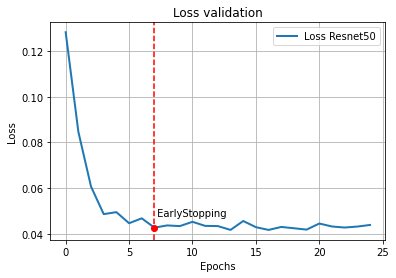

In [ ]:
## Crear Curve de perdida en entrenamiento y validación

import numpy as np
import matplotlib.pyplot as plt

#VGG16
plt.plot(xx_val1_3,yy_val1_3,linewidth=2.0, label = "Loss Resnet50")
#plt.plot(xx_val4_10,yy_val4_10,linewidth=3.0 ,color="CadetBlue", label = "Loss Vgg16 k=4")
plt.axvline(epoch_min1_3, ymin=0, ymax=1, linestyle="--",color="red")
#plt.axvline(epoch_min4_10, ymin=0, ymax=1, linestyle="--",color="red")
plt.plot(epoch_min1_3,stop_val1_3,marker="o",color="red")
#plt.plot(epoch_min4_10,stop_val4_10,marker="o",color="red")
plt.annotate(" EarlyStopping ",(epoch_min1_3,stop_val1_3),(epoch_min1_3,stop_val1_3+0.005))

plt.legend(loc="upper right")
#plt.plot(xx1,yy1,marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss validation")
#plt.axis([0,25,0,0.5])
plt.grid()
plt.savefig('loss.png',bbox_inches='tight')
plt.show()

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = torch.load('/content/modelo_torch_full.pth')
    num_ftrs = model.fc.in_features  #numero de neuronas en la capa de entrada 
    model.fc = nn.Linear(num_ftrs, 2) 
    model.load_state_dict(checkpoint['state_dict'])
    return model, checkpoint['class_to_idx']
  
# get index to class mapping
loaded_model, class_to_idx = load_checkpoint('/content/modelo_torch_1_3.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

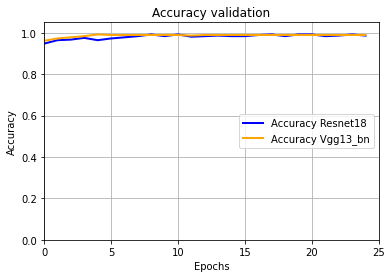

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(xx_val1_1,acc_val1_1,linewidth=2.0, color='blue', label = "Accuracy Resnet18")
plt.plot(xx_val1_4,acc_val1_4,linewidth=2.0, color='orange', label = "Accuracy Vgg13_bn")
#plt.plot(xx_val1_13,acc_val1_13,linewidth=3.0, color='yellow', label = "Accuracy Vgg19_bn k=1")
#plt.plot(xx_val4_13,acc_val4_13,linewidth=3.0, color='orange', label = "Accuracy Vgg19_bn k=4")
#plt.axvline(epoch_min, ymin=0, ymax=1, linestyle="--",color="red")
#plt.plot(epoch_min,stop_val,marker="o",color="red")
plt.legend(loc="right")
#plt.plot(xx1,yy1,marker="o", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy validation")
plt.axis([0,25,0,1.05])
plt.grid()
plt.savefig('Accuracy.png',bbox_inches='tight')
plt.show()

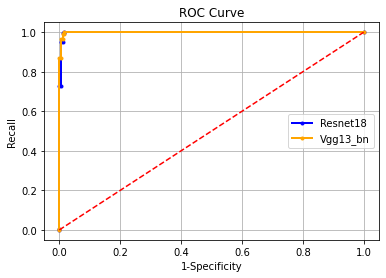

In [ ]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
import numpy as np


#best_labels=best_labels.cpu()
#best_predict=best_predict.cpu()
#best_prob=best_prob.cpu()
xx=np.linspace(0,1,100)
yy=xx


lr_fpr1_1, lr_tpr1_1, _ = roc_curve(best_labels1_1, best_prob1_1)
#lr_fpr1_2, lr_tpr1_2, _ = roc_curve(best_labels1_2, best_prob1_2)
#lr_fpr1_3, lr_tpr1_3, _ = roc_curve(best_labels1_3, best_prob1_3)
lr_fpr1_4, lr_tpr1_4, _ = roc_curve(best_labels1_4, best_prob1_4)
plt.plot(lr_fpr1_1, lr_tpr1_1, marker='.', linewidth=2.0, color='blue', label='Resnet18')
#plt.plot(lr_fpr1_2, lr_tpr1_2, marker='.',  color='blue', label='Resnet101 k=4')
#plt.plot(lr_fpr1_3, lr_tpr1_3, marker='.', color='yellow', label='Vgg19_bn k=1')
plt.plot(lr_fpr1_4, lr_tpr1_4, marker='.', linewidth=2.0, color='orange', label='Vgg13_bn')
plt.plot(xx,yy, color="red",linestyle="--")
plt.xlabel("1-Specificity")
plt.ylabel("Recall")
plt.title("ROC Curve")
plt.axis([-0.05,1.05,-0.05,1.05])
plt.grid()
plt.legend(loc="right")
VP=0
FP=0
VN=0
FN=0

plt.savefig('ROC Curve.png',bbox_inches='tight')

In [ ]:
print("DATOS MODELOS RESNET")
print("\nRESNET18-1\n") 

#print("Base1")

xx_train1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_1 = [0.350993720513803, 0.18527811382655746, 0.1445966183476978, 0.1278673944649873, 0.10570676035075276, 0.10749565220817371, 0.08560766339026116, 0.09281149349554821, 0.0861375868320465, 0.0891354222982018, 0.08448311935972284, 0.08125392080457122, 0.08932392349949589, 0.0672145418215681, 0.0834238056562565, 0.07239600865929215, 0.08487524787308993, 0.08658093591531117, 0.08937945867026294, 0.08443577296204037, 0.08321654346254137, 0.0849720882486414, 0.08532420259934885, 0.08544302781422933, 0.08286014046933916]
xx_val1_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_1 = [0.06655732810497283, 0.0321061926914586, 0.03446806525811553, 0.03663334783580568, 0.011815299663899673, 0.01767463420621223, 0.016580187307877674, 0.015034556670321358, 0.017225340047540765, 0.017727775367416647, 0.02156585607263777, 0.01863653296294312, 0.01573181344403161, 0.014837896943402788, 0.015829751551047794, 0.01574672150787794, 0.015436162023494642, 0.014323682643266188, 0.015275190237573245, 0.017996220199598206, 0.013728327001186294, 0.019704495867093403, 0.014358064039713807, 0.021404535805599558, 0.014507753969584074]
epoch_min1_1 = 4
stop_val1_1 = 0.011815299663899673

acc_train1_1 = [0.8481481481481481, 0.9266666666666666, 0.9422222222222222, 0.9533333333333333, 0.9637037037037036, 0.9592592592592593, 0.9718518518518519, 0.96, 0.9674074074074074, 0.9688888888888888, 0.9725925925925926, 0.9725925925925926, 0.971111111111111, 0.9777777777777777, 0.974074074074074, 0.9703703703703703, 0.9688888888888888, 0.9703703703703703, 0.9674074074074074, 0.9659259259259259, 0.9696296296296296, 0.9659259259259259, 0.9681481481481481, 0.9688888888888888, 0.9718518518518519]
acc_val1_1 = [0.9844444444444445, 0.9955555555555555, 0.9933333333333333, 0.9911111111111112, 0.9977777777777778, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555, 0.9955555555555555]

best_labels1_1 = [1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
best_prob1_1 = [0.9946714043617249, 0.0017230386147275567, 0.015848686918616295, 0.9996867179870605, 0.9997767806053162, 0.9969977140426636, 0.0013710414059460163, 2.9727580113103613e-05, 0.02391156554222107, 0.999862551689148, 0.00531815504655242, 0.997250497341156, 0.9998942613601685, 0.00399447837844491, 0.0017157266847789288, 0.0025710612535476685, 0.9998762607574463, 0.005496409256011248, 0.9998688697814941, 0.9959926009178162, 0.0037846143823117018, 6.542464689118788e-06, 0.9985697269439697, 0.01176708098500967, 7.452190038748085e-05, 0.978865921497345, 0.00021971149544697255, 0.00354859814979136, 0.9974315762519836, 0.9874021410942078, 6.113448762334883e-06, 0.00014208121865522116, 0.00022509697009809315, 0.003175395308062434, 2.2864445782033727e-05, 0.9979105591773987, 0.9984654188156128, 0.9987885355949402, 0.9969146251678467, 0.9992444515228271, 0.9993725419044495, 0.9071784019470215, 0.9921689629554749, 0.9996360540390015, 0.9469825029373169, 0.006275050342082977, 0.9989767074584961, 0.9978306889533997, 0.9997720122337341, 0.9791023135185242, 0.0018595496658235788, 0.0009478917345404625, 0.0018870716448873281, 0.0019469823455438018, 0.9990857839584351, 0.9997988343238831, 0.999643087387085, 0.9996951818466187, 0.005048112943768501, 0.9791511297225952, 0.9991030693054199, 0.00037840320146642625, 0.0001951743761310354, 0.0029750436078757048, 0.9087239503860474, 0.9991621971130371, 1.8160100808017887e-05, 0.9999097585678101, 0.0018227093387395144, 0.9785635471343994, 0.07450650632381439, 0.997975766658783, 0.9955140948295593, 0.00024649500846862793, 5.8369805628899485e-05, 0.00020630302606150508, 1.1281877050350886e-05, 1.0873546671064105e-05, 0.9999433755874634, 0.3105897307395935, 0.9960468411445618, 0.9981864094734192, 0.9993026256561279, 0.9982557892799377, 0.007750628516077995, 5.3872092394158244e-05, 0.9966257810592651, 1.7210995792993344e-05, 0.9995158910751343, 7.759838626952842e-05, 0.001273325295187533, 3.249336441513151e-05, 0.003787849796935916, 4.2804334952961653e-05, 0.9994388222694397, 0.9995400905609131, 0.0003442743618506938, 5.290150147629902e-05, 0.0037721702829003334, 0.9972226619720459, 0.99552983045578, 0.9998712539672852, 0.9987207055091858, 0.9999183416366577, 0.9983605742454529, 0.0013743815943598747, 0.9715537428855896, 0.0011169438948854804, 0.0009287652792409062, 0.9983419179916382, 0.010600193403661251, 0.0002255902800243348, 0.0011896390933543444, 0.9983925223350525, 0.9992997646331787, 0.02651219442486763, 0.999392032623291, 0.0004941817023791373, 0.9996790885925293, 0.9866296052932739, 0.9771566987037659, 0.0006768357707187533, 0.0003850091597996652, 4.875687955063768e-05, 0.9976748824119568, 0.0012897655833512545, 0.9990423321723938, 0.9724370837211609, 5.713271207241633e-07, 0.999792754650116, 0.00015943885955493897, 0.2982982099056244, 0.006333583500236273, 0.027038153260946274, 0.0011189518263563514, 0.018376043066382408, 0.9963704347610474, 0.01121043786406517, 0.9999309778213501, 0.0030307872220873833, 0.9889042973518372, 5.012192559661344e-05, 0.9985646605491638, 0.0007586331921629608, 0.0005660199676640332, 0.998925507068634, 0.9973090887069702, 0.9999462366104126, 0.999234676361084, 0.9956170320510864, 0.9780991673469543, 2.861115717678331e-05, 0.00043810505303554237, 0.9993168115615845, 0.9905924201011658, 8.58847561175935e-05, 0.00017032035975717008, 0.0008614282123744488, 0.997772753238678, 0.0006807388854213059, 0.9996274709701538, 0.00038624697481282055, 5.558118209592067e-05, 0.9760252237319946, 0.9950454235076904, 0.2203681915998459, 0.0005105023737996817, 0.9992324113845825, 0.9992907047271729, 0.9999204874038696, 0.9956660270690918, 0.014417450875043869, 0.9990068078041077, 0.0005429164157249033, 0.9994487166404724, 0.002745207166299224, 0.004666860681027174, 0.0013414889108389616, 0.9980456829071045, 0.9998452663421631, 0.0004056573088746518, 0.00010469892004039139, 0.9992444515228271, 0.9906533360481262, 0.9998359680175781, 0.9915534853935242, 0.0007366014760918915, 0.04499651864171028, 0.9987598657608032, 0.9968217611312866, 0.9989035129547119, 0.02193676307797432, 0.00018085091141983867, 0.00020814946037717164, 0.9983165264129639, 0.9998785257339478, 0.9907909631729126, 0.0006671217852272093, 0.5355042219161987, 0.9982978701591492, 0.9996452331542969, 0.00019586623238865286, 0.991361677646637, 0.0001597127557033673, 0.992164134979248, 0.9980247020721436, 0.0007145481067709625, 0.000842821435071528, 0.9990377426147461, 0.9112449288368225, 0.9988262057304382, 0.965954065322876, 0.9998674392700195, 0.0001929922291310504, 1.021573189063929e-05, 0.9995267391204834, 0.8755606412887573, 0.9934784173965454, 0.997760534286499, 0.00024346509599126875, 9.47283479035832e-05, 0.005126204341650009, 0.9994576573371887, 0.9991206526756287, 0.0002851887547876686, 0.9997708201408386, 0.9990038275718689, 0.0003411001816857606, 0.000350706628523767, 0.9999088048934937, 0.999958872795105, 0.9999949932098389, 0.995707094669342, 0.015595047734677792, 0.9998613595962524, 0.003861410077661276, 4.918576451018453e-06, 1.1726706361514516e-05, 0.9501199126243591, 0.00011501472909003496, 0.020867811515927315, 0.9974695444107056, 0.9962414503097534, 0.9997542500495911, 0.0012691909214481711, 0.9993927478790283, 0.9999028444290161, 0.9973170161247253, 0.000474204687634483, 0.9974833130836487, 0.9994114637374878, 1.559372503834311e-05, 0.9983137845993042, 0.0008231104002334177, 0.008073893375694752, 0.9996504783630371, 0.0009185051312670112, 0.9995681643486023, 0.9995272159576416, 0.9986566305160522, 0.0015259250067174435, 0.9988007545471191, 0.0034950552508234978, 0.00024598598247393966, 0.0006007138290442526, 0.0008071869960986078, 0.0024367664009332657, 0.014983846805989742, 3.08830822177697e-05, 0.9997856020927429, 0.9994335770606995, 0.9939675331115723, 0.9996341466903687, 0.0007426631054840982, 0.002388715511187911, 0.9666623473167419, 0.9932501316070557, 0.005902968347072601, 0.997543215751648, 0.9988778233528137, 0.023278649896383286, 0.004145326558500528, 0.9939857125282288, 0.9949382543563843, 0.012613613158464432, 0.007796757854521275, 0.9783341884613037, 0.9996511936187744, 0.9999790191650391, 0.219320148229599, 0.9833936095237732, 0.9998294115066528, 0.9998955726623535, 6.0668236983474344e-05, 0.9992813467979431, 0.9979972243309021, 0.9941285848617554, 0.9845477938652039, 0.9901913404464722, 0.00015719518705736846, 0.9998767375946045, 0.00017552266945131123, 0.9996979236602783, 0.9994421601295471, 0.9848417043685913, 0.0007553891045972705, 0.9877986311912537, 0.14344476163387299, 0.998359739780426, 4.325865575083299e-06, 0.9800129532814026, 2.3202640022645937e-06, 0.0011744267540052533, 0.004379820078611374, 5.762987257185159e-06, 0.000405206490540877, 3.8881058571860194e-05, 0.003595850197598338, 0.9996175765991211, 0.9998428821563721, 4.6128050598781556e-05, 0.000823873037006706, 0.999884843826294, 0.06644917279481888, 8.325823000632226e-05, 0.0018750660819932818, 0.9981812238693237, 0.9960684776306152, 0.9959235191345215, 2.5868170268950053e-05, 0.00013066735118627548, 0.9998157620429993, 0.00014017986541148275, 0.9980689883232117, 0.004794522654265165, 0.9998030066490173, 0.9999754428863525, 0.0006553589482791722, 0.0022900172043591738, 0.00016616420180071145, 0.9996432065963745, 0.0004205710138194263, 0.9999290704727173, 0.0005556200630962849, 0.9998370409011841, 0.9833365082740784, 3.1845767807681113e-05, 0.0011143145384266973, 1.907987279992085e-05, 0.9996751546859741, 0.018094569444656372, 0.0004656642850022763, 0.0006608683615922928, 0.9991733431816101, 0.9998462200164795, 0.00018147275841329247, 0.9872433543205261, 0.013263373635709286, 6.705852865707129e-05, 0.001019546645693481, 0.012047471478581429, 0.000397804455133155, 1.0265383025398478e-05, 0.9999457597732544, 0.0020930126775056124, 0.0002254208520753309, 0.003246799809858203, 0.9975284934043884, 0.9995154142379761, 0.0026636687107384205, 0.9976829290390015, 0.0019786900375038385, 0.9993019104003906, 0.9770834445953369, 0.997734785079956, 0.9974371194839478, 0.9986374974250793, 0.9992827773094177, 0.9986032843589783, 0.00038305780617520213, 0.00029090928728692234, 0.006929326336830854, 0.9990884065628052, 4.4898864871356636e-05, 0.9967259168624878, 2.2195874407771043e-05, 0.9868502616882324, 0.9999336004257202, 0.003278320888057351, 0.99972003698349, 0.00041122862603515387, 0.9997889399528503, 0.9994230270385742, 5.380175934988074e-05, 0.0004687306936830282, 0.00928445439785719, 0.0001938993518706411, 3.385311720194295e-05, 0.00012661732034757733, 0.0012179294135421515, 0.9940811991691589, 0.0002905860892497003, 0.00018753598851617426, 0.002687746426090598, 0.0021279361099004745, 0.990567147731781, 0.00018722315144259483, 0.9998514652252197, 0.9994269609451294, 0.0010046608513221145, 0.9918728470802307, 0.9997805953025818, 0.9512040019035339, 0.001419374137185514, 0.0017825679387897253, 0.0047151995822787285, 2.9311648177099414e-05, 0.9960783123970032, 0.00017632803064770997, 6.329392635961995e-05, 0.9928665161132812, 8.245830395026132e-05, 0.0011790817370638251, 0.9975704550743103, 0.00155551522038877, 0.0006195587338879704, 0.9951122403144836, 0.0023204961325973272, 0.005977580789476633, 0.05839112401008606, 0.9209044575691223, 3.681915404740721e-05, 0.00023073452757671475, 0.9997987151145935, 0.001580997253768146, 0.015984129160642624, 1.63823915499961e-05, 0.8390220403671265, 0.003923414275050163, 0.9994970560073853, 0.0015039278659969568, 0.9912570714950562, 0.9999233484268188, 0.0009426379692740738, 0.9990407824516296, 0.9998761415481567, 2.9637109037139453e-05, 0.0006351019255816936, 0.9997196793556213, 0.0003293272166047245]

Best_acc1_1 = 0.9977777777777778
Recall1_1 = 1.0
Especificidad1_1 = 0.995575221238938


prom1=(Best_acc1_1+Best_acc2_1+Best_acc3_1+Best_acc4_1)/4
promrec1=(Recall1_1+Best_acc2_1+Best_acc3_1+Best_acc4_1)/4
promesp1=(Especificidad1_1+Especificidad2_1+Especificidad3_1+Especificidad4_1)/4
promearlyStop1=(epoch_min1_1+epoch_min2_1+epoch_min3_1+epoch_min4_1)/4
print("Stop "+str(promearlyStop1))


In [ ]:

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    


prom1=(Best_acc1_1+Best_acc2_1+Best_acc3_1+Best_acc4_1+Best_acc5_1)/5
prom2=(Best_acc1_2+Best_acc2_2+Best_acc3_2+Best_acc4_2+Best_acc5_2)/5
prom3=(Best_acc1_3+Best_acc2_3+Best_acc3_3+Best_acc4_3+Best_acc5_3)/5
prom4=(Best_acc1_4+Best_acc2_4+Best_acc3_4+Best_acc4_4+Best_acc5_4)/5
prom5=(Best_acc1_5+Best_acc2_5+Best_acc3_5+Best_acc4_5+Best_acc5_5)/5

print("\nAccuracy\n")
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom1, Best_acc1_1, Best_acc2_1, Best_acc3_1, Best_acc4_1, Best_acc5_1))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom2, Best_acc1_2, Best_acc2_2, Best_acc3_2, Best_acc4_2, Best_acc5_2))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom3, Best_acc1_3, Best_acc2_3, Best_acc3_3, Best_acc4_3, Best_acc5_3))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom4, Best_acc1_4, Best_acc2_4, Best_acc3_4, Best_acc4_4, Best_acc5_4))
print("{:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}" .format(prom5, Best_acc1_5, Best_acc2_5, Best_acc3_5, Best_acc4_5, Best_acc5_5))


promrec1=(Recall1_1+Recall2_1+Recall3_1+Recall4_1+Recall5_1)/5
promrec2=(Recall1_2+Recall2_2+Recall3_2+Recall4_2+Recall5_2)/5
promrec3=(Recall1_3+Recall2_3+Recall3_3+Recall4_3+Recall5_3)/5
promrec4=(Recall1_4+Recall2_4+Recall3_4+Recall4_4+Recall5_4)/5
promrec5=(Recall1_5+Recall2_5+Recall3_5+Recall4_5+Recall5_5)/5

promesp1=(Especificidad1_1+Especificidad2_1+Especificidad3_1+Especificidad4_1+Especificidad5_1)/5
promesp2=(Especificidad1_2+Especificidad2_2+Especificidad3_2+Especificidad4_2+Especificidad5_2)/5
promesp3=(Especificidad1_3+Especificidad2_3+Especificidad3_3+Especificidad4_3+Especificidad5_3)/5
promesp4=(Especificidad1_4+Especificidad2_4+Especificidad3_4+Especificidad4_4+Especificidad5_4)/5
promesp5=(Especificidad1_5+Especificidad2_5+Especificidad3_5+Especificidad4_5+Especificidad5_5)/5
#print("\n")
print("\nMetricas\n")
print("{:.4f} {:.4f} {:.4f}" .format(prom1, promrec1, promesp1))
print("{:.4f} {:.4f} {:.4f}" .format(prom2, promrec2, promesp2))
print("{:.4f} {:.4f} {:.4f}" .format(prom3, promrec3, promesp3))
print("{:.4f} {:.4f} {:.4f}" .format(prom4, promrec4, promesp4))
print("{:.4f} {:.4f} {:.4f}" .format(prom5, promrec5, promesp5))


promearlyStop1=(epoch_min1_1+epoch_min2_1+epoch_min3_1+epoch_min4_1+epoch_min5_1)/5
promearlyStop2=(epoch_min1_2+epoch_min2_2+epoch_min3_2+epoch_min4_2+epoch_min5_2)/5
promearlyStop3=(epoch_min1_3+epoch_min2_3+epoch_min3_3+epoch_min4_3+epoch_min5_3)/5
promearlyStop4=(epoch_min1_4+epoch_min2_4+epoch_min3_4+epoch_min4_4+epoch_min5_4)/5
promearlyStop5=(epoch_min1_5+epoch_min2_5+epoch_min3_5+epoch_min4_5+epoch_min5_5)/5

print("\nEpocas {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}" .format(promearlyStop1, promearlyStop2, promearlyStop3, promearlyStop4, promearlyStop5))

tiempo1=(Tiempo1_1+Tiempo2_1+Tiempo3_1+Tiempo4_1+Tiempo5_1)/5
tiempo2=(Tiempo1_2+Tiempo2_2+Tiempo3_2+Tiempo4_2+Tiempo5_2)/5
tiempo3=(Tiempo1_3+Tiempo2_3+Tiempo3_3+Tiempo4_3+Tiempo5_3)/5
tiempo4=(Tiempo1_4+Tiempo2_4+Tiempo3_4+Tiempo4_4+Tiempo5_4)/5
tiempo5=(Tiempo1_5+Tiempo2_5+Tiempo3_5+Tiempo4_5+Tiempo5_5)/5

print("\nTiempo {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}" .format(tiempo1, tiempo2, tiempo3, tiempo4, tiempo5))
print("\nTiempo {:.0f} {:.0f} {:.0f} {:.0f} {:.0f}" .format(tiempo1/25*promearlyStop1, tiempo2/25*promearlyStop2, tiempo3/25*promearlyStop3, tiempo4/25*promearlyStop4, tiempo5/25*promearlyStop5))



Accuracy

0.9950 0.9917 0.9833 1.0000 1.0000 1.0000
0.9939 0.9750 0.9944 1.0000 1.0000 1.0000
0.9950 0.9861 0.9889 1.0000 1.0000 1.0000
0.9950 0.9861 0.9917 0.9972 1.0000 1.0000
0.9956 0.9861 0.9917 1.0000 1.0000 1.0000

Metricas

0.9950 0.9923 0.9978
0.9939 0.9902 0.9977
0.9950 0.9955 0.9945
0.9950 0.9923 0.9978
0.9956 0.9934 0.9978

Epocas 5 5 4 5 6

Tiempo 316 341 506 766 1054

Tiempo 63 68 85 153 236


In [ ]:
######## Base1 ########
#MODELO = VGG13
#Datos perdidas
xx_train1_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_3 = [0.28229752282301585, 0.11739744962089592, 0.1145356179939376, 0.08167482833895419, 0.09516583453449938, 0.05567536618974474, 0.050679383758041596, 0.04908870698677169, 0.048901026364829805, 0.04837841397772233, 0.057619009125563836, 0.0530603934907251, 0.05841220170259476, 0.058170703715748256, 0.048420947500401074, 0.04870942085981369, 0.048865419998764995, 0.057036789444585644, 0.05201462681094805, 0.05733283311128616, 0.05255933474335406, 0.05139481719169352, 0.055183394336038166, 0.044817791485952004, 0.055731714558270244]
xx_val1_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_3 = [0.10684885813130272, 0.10633846786287096, 0.060769879155688815, 0.07231123993794124, 0.0607873057325681, 0.053661428060796525, 0.05060238093137741, 0.049616475900014244, 0.049445067014959126, 0.04861333535777198, 0.04860843171676, 0.0485315395726098, 0.04846020142237346, 0.04832098450925615, 0.048230770064724815, 0.04822931223445469, 0.048225097358226776, 0.048220514092180464, 0.048218392332394916, 0.04821544239918391, 0.04821537898646461, 0.048215162422921926, 0.04821506573094262, 0.04821510894431008, 0.04821515348222521]
epoch_min1_3 = 5
stop_val1_3 = 0.053661428060796525

#Datos accuracy
acc_train1_3 = [0.8972222222222223, 0.9576388888888889, 0.9569444444444445, 0.9694444444444444, 0.9652777777777778, 0.9791666666666667, 0.9791666666666667, 0.9833333333333334, 0.9847222222222223, 0.9812500000000001, 0.976388888888889, 0.9784722222222223, 0.976388888888889, 0.976388888888889, 0.9861111111111112, 0.982638888888889, 0.9798611111111112, 0.9750000000000001, 0.9798611111111112, 0.976388888888889, 0.9812500000000001, 0.9791666666666667, 0.9798611111111112, 0.9847222222222223, 0.9777777777777779]
acc_val1_3 = [0.9416666666666667, 0.9583333333333334, 0.9777777777777779, 0.9694444444444444, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9750000000000001, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779, 0.9777777777777779]

#Datos curva ROC
best_labels1_3 = [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0]
best_prob1_3 = [0.9990088939666748, 0.9998936653137207, 0.9993298053741455, 1.4929722055967432e-05, 0.9989687204360962, 0.0238625630736351, 0.9999148845672607, 0.11120227724313736, 0.9968428611755371, 0.9996615648269653, 0.003364547388628125, 0.0005742364446632564, 9.81925186351873e-05, 1.0382303372580282e-07, 0.9944460391998291, 0.9942367076873779, 0.9977922439575195, 3.3689242801698827e-12, 6.332249540719204e-06, 0.9979681372642517, 8.586356443629484e-07, 0.9908409118652344, 0.9908512234687805, 3.8587364770137356e-07, 0.0005679823225364089, 0.994059681892395, 1.4462318631558446e-07, 1.5998483604562352e-06, 1.1224592526559718e-05, 8.083554234872281e-07, 4.2448686343732334e-08, 8.672522966435281e-08, 2.4235171167674707e-06, 0.9894556403160095, 0.9973233342170715, 0.9959120750427246, 0.999187171459198, 2.493946112736012e-06, 0.9918718338012695, 0.06764575839042664, 4.262303576751947e-08, 0.0009781793924048543, 1.9338986021466553e-06, 7.967810233822092e-05, 0.009919465519487858, 0.9946869611740112, 0.9663318395614624, 0.9966428279876709, 0.9992307424545288, 8.772573346504942e-05, 0.00031939049949869514, 0.06581512093544006, 1.0244664491732003e-11, 0.9828429818153381, 3.378936298759072e-06, 0.9989558458328247, 3.9731498873152304e-06, 0.9817129969596863, 1.968724627765539e-10, 0.9992260932922363, 7.443623495362317e-09, 7.223006637246954e-09, 0.5936455726623535, 0.003305261256173253, 0.9993846416473389, 0.9823822379112244, 0.011003494262695312, 0.006732045207172632, 0.0014613847015425563, 0.9963675737380981, 0.0018679731292650104, 0.9994221925735474, 1.6357592613758243e-08, 0.997821569442749, 0.9817450642585754, 3.2739338583914757e-13, 3.107798818291485e-08, 0.00036029008333571255, 7.097701745806262e-05, 1.167018672276754e-05, 0.9917353391647339, 0.9877639412879944, 0.9897456169128418, 0.020786592736840248, 0.9878548979759216, 0.9731680154800415, 0.593816339969635, 0.9919605851173401, 1.3423301936654752e-07, 0.9957887530326843, 0.005390436388552189, 0.9789831638336182, 0.9969469904899597, 3.8412914515895125e-10, 0.9992378950119019, 0.9877744317054749, 0.9868369102478027, 2.050720553370411e-07, 1.5748944861115888e-05, 0.9991554021835327, 0.9766531586647034, 0.8461681604385376, 0.9870874881744385, 0.044308099895715714, 2.4542497811808062e-08, 0.9915447235107422, 0.005774759687483311, 0.3741527795791626, 2.0812422008020803e-05, 0.9996193647384644, 1.9348144633113407e-05, 1.2123085070925299e-05, 0.9988164901733398, 2.6486955903237686e-05, 0.9956989288330078, 1.639995517166426e-08, 7.206877761234409e-09, 1.4207332199589473e-08, 0.9917620420455933, 0.9998106360435486, 0.0012774743372574449, 0.009962582029402256, 3.3691943457370144e-08, 1.0916584614051317e-07, 0.017254143953323364, 3.315195135655813e-05, 0.9994342923164368, 0.9909088015556335, 0.9999892711639404, 0.9694212675094604, 0.963080108165741, 6.092467641494181e-10, 0.9979175925254822, 0.9948369264602661, 0.999596893787384, 0.030565176159143448, 0.9958658218383789, 0.02763664536178112, 0.9877153038978577, 0.9976800084114075, 0.99847811460495, 2.897520445799273e-09, 4.562710653743807e-09, 0.7732540369033813, 0.0006552939303219318, 1.8552469283061868e-10, 0.9977050423622131, 0.994785726070404, 1.037325091601815e-05, 0.9974057078361511, 2.0023469549101947e-09, 2.2853503196529346e-06, 0.9984446167945862, 5.086618770633322e-08, 9.468132056156264e-09, 7.405377982649952e-05, 0.9991003274917603, 0.9896947145462036, 0.9539058804512024, 4.367223880308302e-07, 8.893201908222181e-08, 0.9972816705703735, 0.9996453523635864, 8.828640574165547e-08, 8.270463877124712e-05, 0.9965806603431702, 0.994265615940094, 0.9969807267189026, 0.00037511694245040417, 0.9980435371398926, 0.9993436932563782, 1.2235998880782972e-08, 1.1089190010693528e-08, 0.985943078994751, 5.736308594350703e-05, 0.38825854659080505, 1.0320646651962306e-05, 0.9949047565460205, 3.6539634606924665e-07, 4.6226821837080934e-07, 0.9998950958251953, 0.44130009412765503, 2.9225833486634656e-07, 1.2022974615888415e-08, 0.9982934594154358, 1.5639241155440686e-06, 0.9993516802787781, 0.9981135129928589, 0.9977489113807678, 0.9996377229690552, 0.002927327761426568, 0.0005508426111191511, 0.5435584783554077, 0.9968681931495667, 0.6638436913490295, 0.9877533316612244, 0.9664538502693176, 0.9746074080467224, 1.7587864498125327e-09, 0.9611651301383972, 0.7639371752738953, 0.9932565689086914, 6.952735609466743e-10, 0.9257831573486328, 0.9964937567710876, 0.9989014863967896, 1.1891835960398112e-08, 3.439256761339493e-05, 8.759504926958428e-11, 1.8366889662502217e-06, 1.0410722097731195e-05, 4.445089984983497e-07, 1.3845124158251565e-07, 0.9968609809875488, 0.0002287480019731447, 1.3377188246010974e-08, 2.394640041814e-09, 0.9849613904953003, 0.9995133876800537, 0.9959208965301514, 1.3819647392665502e-05, 0.9914788603782654, 1.2265451154735985e-10, 2.563999714766396e-06, 4.684252871811623e-06, 7.464776019538988e-10, 0.9925780892372131, 1.759584145055726e-10, 3.5667924169757725e-09, 0.0035951838362962008, 9.421012691746e-06, 0.9980775117874146, 0.00037424894981086254, 5.0696224995760986e-11, 0.999103307723999, 0.991967499256134, 0.9888935685157776, 1.9800560039584525e-05, 0.9984344840049744, 0.9911490678787231, 0.9976140260696411, 0.995396077632904, 0.998699426651001, 2.032390966633102e-08, 0.4334912598133087, 0.8096804618835449, 0.9974863529205322, 0.995090126991272, 3.166937858622987e-07, 0.9976146221160889, 0.0025004916824400425, 0.9995003938674927, 0.16353093087673187, 1.4530158978232066e-06, 0.9864476919174194, 0.006177996285259724, 4.1804570916070816e-10, 0.9987533092498779, 9.512103133602068e-05, 0.9999328851699829, 0.9986332058906555, 0.9973862767219543, 1.6088317352114245e-05, 0.99933260679245, 1.6974130989666492e-09, 0.993645429611206, 8.959867292546164e-10, 2.3701033569523133e-05, 0.9884364604949951, 0.001123820897191763, 0.9945317506790161, 0.9915947318077087, 0.006101710721850395, 0.9970575571060181, 0.9998114705085754, 0.9996933937072754, 2.089216133427385e-09, 0.9991955161094666, 0.9990788698196411, 0.3634635806083679, 0.9948068261146545, 0.9933597445487976, 3.2790342174848774e-06, 5.4307591199176386e-05, 0.999852180480957, 0.031670019030570984, 0.9952927827835083, 3.369020973309489e-08, 0.9983373880386353, 0.9924235343933105, 0.0036936532706022263, 0.9984082579612732, 8.062612550929771e-07, 0.991479218006134, 0.9827526807785034, 9.954604918149812e-10, 0.9967988729476929, 0.9734492897987366, 1.1824744433397427e-05, 0.9970431923866272, 0.0002525259624235332, 1.1396458830859046e-05, 0.9555372595787048, 0.006589003838598728, 1.7740244402375538e-06, 1.6277458314561954e-07, 0.9955281615257263, 2.8817051175855646e-11, 0.004277510102838278, 0.9968342185020447, 0.9971972703933716, 0.9740235209465027, 7.17061757193882e-11, 0.9626054763793945, 1.1616966730798595e-05, 0.8346788287162781, 2.6330968694310286e-07, 0.9943047165870667, 1.6947215852880504e-09, 0.0001683173031779006, 0.14886054396629333, 0.9993355870246887, 0.7857944965362549, 8.694849640278335e-08, 2.23741225546803e-09, 0.9876002073287964, 0.028552865609526634, 0.9920748472213745, 5.5608579714316875e-06, 0.9973650574684143, 1.4588082194677554e-05, 2.54518198516962e-07, 0.9947356581687927, 0.9997081160545349, 0.9997791647911072, 0.9937283992767334, 0.9587555527687073, 0.00048675626749172807, 6.419230658138986e-08, 0.0010758854914456606, 0.9974825978279114, 0.9993354678153992, 0.9822641015052795, 7.746335484171141e-08, 0.14752531051635742, 0.00013087371189612895, 0.007807030342519283, 0.9980521202087402, 0.9931983351707458, 0.9769294857978821, 0.999751627445221, 0.0005121446447446942, 0.9993255138397217, 0.9811210036277771, 0.9992315769195557, 2.9725949701742138e-08, 0.9988322854042053, 1.783113923181645e-08, 5.625612402582192e-07, 0.9998008608818054]

#Metricas de validación
Best_acc1_3 = 0.9750000000000001
acc_aux1_3 = 0.9861111111111112
Recall1_3 = 0.9723756906077348
Especificidad1_3 = 0.9776536312849162
Tiempo1_3 = 379.8018043041229

######## Base2 ########
#MODELO = VGG13
#Datos perdidas
xx_train2_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_3 = [0.1127930135362678, 0.11870153608421484, 0.07046978763408131, 0.05462801475077868, 0.05712192849152618, 0.04010101370513439, 0.03434049884478251, 0.03653871553639571, 0.03054635323998001, 0.02933220271435049, 0.030074641770786708, 0.03374776403523154, 0.0305844373587105, 0.02494399632430739, 0.04104222369690736, 0.034735035772124924, 0.028838260906438033, 0.03849632742090358, 0.03359314697898096, 0.03363168837709559, 0.033852338646021156, 0.03506219728539387, 0.025583198997709486, 0.03396937598784765, 0.04050995771669679]
xx_val2_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_3 = [0.03090102987156974, 0.1440817630953259, 0.03334259672297372, 0.062416461441251965, 0.04528425484895706, 0.03740739242898093, 0.03323024213314056, 0.03193469610479143, 0.03282997343275282, 0.031935880250400964, 0.03187098387214873, 0.03187067343129052, 0.03182813177506129, 0.03179456144571304, 0.03173203683561749, 0.03172568894094891, 0.031722858051458996, 0.03171956737836202, 0.03172004421552022, 0.03171729313002692, 0.03171725057893329, 0.0317172603474723, 0.03171726382440991, 0.031717282864782544, 0.031717201239532894]
epoch_min2_3 = 0
stop_val2_3 = 0.03090102987156974

#Datos accuracy
acc_train2_3 = [0.9506944444444445, 0.9576388888888889, 0.9756944444444445, 0.9791666666666667, 0.9777777777777779, 0.9881944444444445, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9881944444444445, 0.9895833333333334, 0.9868055555555556, 0.9868055555555556, 0.9930555555555556, 0.9875, 0.9875, 0.9888888888888889, 0.9881944444444445, 0.9909722222222223, 0.9881944444444445, 0.9868055555555556, 0.9888888888888889, 0.9909722222222223, 0.9888888888888889, 0.9847222222222223]
acc_val2_3 = [0.9916666666666667, 0.9555555555555556, 0.9888888888888889, 0.9833333333333334, 0.9777777777777779, 0.9805555555555556, 0.9833333333333334, 0.9861111111111112, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334, 0.9833333333333334]

#Datos curva ROC
best_labels2_3 = [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
best_prob2_3 = [0.999665379524231, 0.9900798797607422, 7.258537033146689e-14, 1.2769538759727084e-09, 1.7407010091119446e-05, 0.9990308284759521, 7.170549570778562e-11, 0.9973573088645935, 0.00024044266319833696, 0.9826851487159729, 0.9972746968269348, 2.8484989922361592e-09, 0.9587032198905945, 0.996861457824707, 0.9978984594345093, 0.995412290096283, 0.9983953833580017, 0.9931521415710449, 4.679903042870137e-08, 2.738457396844751e-06, 0.9994667172431946, 4.6901368205842786e-11, 0.003353539388626814, 1.455887493895247e-12, 0.941161036491394, 0.9972782731056213, 3.3622427508817054e-07, 0.966510534286499, 0.9972347617149353, 0.9551196694374084, 2.233712059762638e-08, 0.005958049092441797, 5.091551044845858e-15, 0.999356210231781, 6.1136707675546464e-12, 0.9971032738685608, 1.3402736840362195e-06, 3.410938415396303e-12, 1.2837892970907205e-09, 0.9995694756507874, 1.9902523490600288e-05, 0.9968852400779724, 0.9995564818382263, 1.911869986770398e-07, 0.9997826218605042, 3.333666143134906e-08, 0.99722820520401, 0.9999936819076538, 0.9897226095199585, 3.6886322618556733e-07, 0.0007749895448796451, 0.9500974416732788, 0.0001500145299360156, 2.6985681245150772e-08, 0.9949259757995605, 0.992609441280365, 0.9992992877960205, 0.012860164046287537, 0.7942480444908142, 0.44839155673980713, 2.1759021819889313e-06, 0.999665379524231, 0.011162267066538334, 0.9980601668357849, 0.9832725524902344, 0.9371711015701294, 0.010031833313405514, 0.0011231278767809272, 5.077415154985943e-10, 0.9999622106552124, 0.22163841128349304, 0.988404393196106, 0.998809814453125, 1.5368465028586797e-05, 1.5232964187816833e-06, 0.04351866990327835, 0.9617024064064026, 0.9991424083709717, 0.9946886301040649, 1.2769538759727084e-09, 1.57856908100662e-10, 0.9943660497665405, 0.9969432950019836, 9.989497584683704e-08, 0.5227068662643433, 3.6909313383404196e-09, 0.9755644202232361, 0.0025948972906917334, 0.9991706609725952, 0.9471163153648376, 0.991397500038147, 2.822952427372627e-10, 0.000126732571516186, 7.982818572838113e-11, 0.9696871042251587, 1.7543666217534337e-06, 8.396960765821859e-05, 0.9877025485038757, 4.12032052921063e-09, 0.00018136239668820053, 0.9970046877861023, 7.519104110542685e-05, 0.9733326435089111, 6.661830553866821e-08, 4.060113356629813e-11, 1.62165804340475e-07, 0.006385331507772207, 0.9884923696517944, 0.00011458057997515425, 0.9934129118919373, 1.3575827573220067e-08, 0.0003008660569321364, 0.9035072922706604, 0.9995200634002686, 1.0281637514708564e-05, 0.9951613545417786, 0.9992908239364624, 0.8437309861183167, 6.718545164652312e-10, 0.9779912829399109, 0.9989455342292786, 1.9725760580513452e-07, 1.8317389827160468e-09, 0.999354898929596, 0.9921979308128357, 0.980582058429718, 3.56902546872181e-16, 2.411081914033275e-05, 0.2796967327594757, 8.558333502151072e-05, 0.9710685610771179, 0.9979953765869141, 0.0013886443339288235, 4.281434148184493e-12, 0.8867592811584473, 3.889423396685743e-07, 0.9971953630447388, 1.686221440255764e-10, 0.0020121848210692406, 0.9861354827880859, 2.214460614879954e-09, 0.9592111110687256, 0.0017995343077927828, 1.2246397091075778e-05, 0.9883135557174683, 1.0820332185801362e-08, 0.9925974607467651, 0.9868693947792053, 7.230701015714658e-08, 0.9997981190681458, 0.9727276563644409, 0.9994640946388245, 0.9909147024154663, 1.694925977346884e-08, 1.1528958054896066e-07, 1.6863276053324938e-10, 0.0002745234814938158, 2.819911804063935e-10, 0.0006367407040670514, 0.9977976083755493, 1.3492121979652438e-06, 0.9947858452796936, 0.0012136069126427174, 5.951259485215132e-09, 0.9973982572555542, 2.19045812599461e-08, 0.9988330006599426, 0.9999520778656006, 0.9997116923332214, 0.9743806719779968, 0.9988954067230225, 0.9972391128540039, 1.1095827590068552e-09, 1.130832982809693e-09, 0.9950578212738037, 9.658871249484946e-07, 0.9939641356468201, 0.9787613153457642, 0.9994686245918274, 2.182004577022667e-09, 0.9773762226104736, 0.9644124507904053, 0.9992313385009766, 0.0007000495679676533, 0.9972541928291321, 0.9914440512657166, 1.8574368709778355e-08, 0.999967098236084, 0.9669708013534546, 0.09892119467258453, 0.9810940027236938, 2.2359590730047785e-05, 0.9994315505027771, 0.0015636768657714128, 0.9990668892860413, 2.72239066845259e-08, 5.51528000869439e-06, 0.991807758808136, 0.015397780574858189, 4.561641862854682e-12, 0.9336047768592834, 0.9138669967651367, 1.7399734431045033e-10, 0.9430266618728638, 0.010139482095837593, 4.702990281657549e-06, 8.613408681412693e-06, 1.0929247764579486e-06, 0.8891013264656067, 0.9280382394790649, 0.029155420139431953, 0.0006673586321994662, 0.9954553842544556, 0.9722315073013306, 5.735709507348474e-08, 0.9864858388900757, 0.9924071431159973, 5.39364906904094e-12, 3.3500632823368903e-10, 3.0965061070808986e-10, 0.9891884922981262, 0.9955363273620605, 0.975335955619812, 0.9946011304855347, 1.425161855195256e-07, 0.9923458099365234, 0.00011525218724273145, 4.702076694229618e-05, 5.234290156863608e-08, 0.00010219114483334124, 0.9955275654792786, 7.717227551440331e-11, 4.155947408435168e-07, 0.007511540781706572, 0.00044444581726565957, 0.9960455298423767, 0.8240140676498413, 1.6397648039401247e-07, 5.024424353905488e-06, 0.9985955357551575, 5.858482836629264e-07, 8.169477041519713e-06, 0.9971904158592224, 1.5799011521266948e-07, 0.9834668040275574, 6.557526743833364e-11, 0.9985432624816895, 0.00016110370052047074, 0.9138472676277161, 0.9886012673377991, 0.9121108651161194, 4.271663200938747e-08, 5.870271735375354e-08, 0.995087206363678, 0.9972163438796997, 0.9849354028701782, 2.4431026304228e-06, 7.452493264281657e-06, 3.7968846816616164e-11, 0.6198207139968872, 1.0398926164612021e-08, 0.9955487251281738, 0.0002665238862391561, 0.12007663398981094, 0.9996582269668579, 6.759938386835529e-09, 0.9990538954734802, 0.9896916747093201, 0.992668628692627, 9.916348631122673e-09, 0.9906314611434937, 0.0007889771950431168, 0.0047431462444365025, 0.9932013154029846, 0.9994356036186218, 1.0154668772521802e-11, 3.3374376471329015e-06, 0.9948166012763977, 0.15619245171546936, 0.9995959401130676, 0.9994339346885681, 0.9996322393417358, 0.923273503780365, 0.9685782194137573, 0.9997298121452332, 0.9933265447616577, 1.2664125303984974e-09, 5.774424341464801e-12, 5.284234421559786e-12, 0.8977821469306946, 0.9848992824554443, 1.8896687834057957e-05, 0.9407145977020264, 5.028534554897546e-13, 1.1036774161254925e-08, 0.04901154339313507, 5.002821507754662e-12, 0.9999812841415405, 1.6303254579685955e-10, 0.9260036945343018, 1.1577994812883574e-10, 0.6753298044204712, 3.321470598560694e-10, 0.9983575940132141, 0.981191098690033, 1.4395450109727648e-10, 0.9982831478118896, 0.9968456625938416, 0.8307381868362427, 0.9999831914901733, 0.9998714923858643, 0.004484023433178663, 0.9994915723800659, 6.71285804720867e-10, 0.9980300068855286, 2.6122810511952643e-12, 0.9977916479110718, 0.9769733548164368, 0.2123376429080963, 6.265382770974728e-14, 0.9865317940711975, 2.5767569240997545e-05, 2.669302602953394e-06, 0.9949746131896973, 7.023717785159533e-07, 0.0007326816557906568, 0.9939072728157043, 1.4249234681074086e-08, 0.9851534366607666, 4.812645215679368e-07, 0.9870644807815552, 9.876304635225708e-11, 4.6284271554286605e-11, 0.9952865839004517, 0.9805136322975159, 0.9999462366104126, 0.9898608922958374, 8.850401965118659e-13, 0.3137475252151489, 4.5343091414906667e-07, 2.4588345248766075e-10, 0.9979933500289917, 7.224752334877849e-05, 3.4346954533998053e-12, 9.954363804354216e-07, 0.00035691619268618524, 0.9821816086769104, 0.00012334398343227804, 0.1362934410572052, 0.99599289894104, 0.9747154712677002, 0.9997091889381409, 2.0074459455843296e-11, 0.9988442659378052, 0.12352269887924194, 6.185298051519794e-09, 0.00015648888074792922, 0.9990931749343872, 4.602711214829469e-06, 0.00020191851945128292]

#Metricas de validación
Best_acc2_3 = 0.9916666666666667
acc_aux2_3 = 0.9930555555555556
Recall2_3 = 0.994413407821229
Especificidad2_3 = 0.988950276243094
Tiempo2_3 = 379.14956879615784

######## Base3 ########
#MODELO = VGG13
#Datos perdidas
xx_train3_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_3 = [0.19413599061469236, 0.09646297577354643, 0.062128164081109896, 0.060074180633657506, 0.06315028766791025, 0.05237175050295061, 0.050645875123639904, 0.04194340312646495, 0.040304350977142654, 0.03996644525064363, 0.03671497570143806, 0.0384827551121513, 0.0377959209597773, 0.03207565918564796, 0.04410220411502653, 0.03872076591683759, 0.036100364103913304, 0.03362860075301594, 0.042700803838670254, 0.02948416293495231, 0.0412169067396058, 0.03331704574326674, 0.034789758982757726, 0.04036431805127197, 0.03874929236869017]
xx_val3_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_3 = [0.03450891309314304, 0.03540582358837128, 0.03156238545974096, 0.09084995339314143, 0.04711132033003701, 0.03781992809640037, 0.03433163058426645, 0.030682108302911123, 0.02861361304918925, 0.026188704868157706, 0.026256050335036384, 0.026155172950691648, 0.02611894326077567, 0.02609879987107383, 0.026092784769005246, 0.026092624829875097, 0.026090912686453926, 0.026087173322836558, 0.026084889140394, 0.02608103652795156, 0.026081023944748774, 0.026080979241265193, 0.0260809525847435, 0.026080921954578822, 0.02608093089527554]
epoch_min3_3 = 0
stop_val3_3 = 0.03450891309314304

#Datos accuracy
acc_train3_3 = [0.9270833333333334, 0.9604166666666667, 0.9791666666666667, 0.9791666666666667, 0.9770833333333334, 0.9798611111111112, 0.9819444444444445, 0.9881944444444445, 0.9868055555555556, 0.9868055555555556, 0.9854166666666667, 0.9861111111111112, 0.9888888888888889, 0.9881944444444445, 0.9854166666666667, 0.9868055555555556, 0.9881944444444445, 0.9902777777777778, 0.9840277777777778, 0.9930555555555556, 0.9819444444444445, 0.9888888888888889, 0.9902777777777778, 0.9868055555555556, 0.9868055555555556]
acc_val3_3 = [0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9694444444444444, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels3_3 = [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
best_prob3_3 = [0.9896237254142761, 0.985257089138031, 0.9904120564460754, 0.9999840259552002, 0.9877853393554688, 6.982673949096352e-05, 0.9954026937484741, 6.570812547579408e-05, 0.9990076422691345, 0.0006341789267025888, 0.9989499449729919, 0.9990467429161072, 2.2221977360459277e-06, 4.2245519580319524e-05, 0.9795185923576355, 0.002407999709248543, 0.09077919274568558, 6.407148248399608e-06, 0.9505293965339661, 0.9998596906661987, 0.9995438456535339, 0.9897869825363159, 0.0003336046065669507, 0.999171257019043, 0.9985553622245789, 0.9842525124549866, 2.889655479521025e-05, 0.00017044757260009646, 0.0005586940096691251, 0.9997585415840149, 0.9929661750793457, 1.8833183276001364e-05, 0.9990021586418152, 0.9996304512023926, 0.8611143231391907, 0.9997504353523254, 0.9531170129776001, 0.9225835800170898, 0.9735055565834045, 0.9714194536209106, 0.9885130524635315, 0.9991125464439392, 0.9913193583488464, 0.9330354332923889, 0.4545828402042389, 0.20260991156101227, 0.9968172311782837, 0.00018822820857167244, 3.3358212476741755e-06, 1.8070266378344968e-05, 9.559315685692127e-07, 0.00048287527170032263, 1.4019062291481532e-05, 0.3864767849445343, 0.0002868311130441725, 0.9999550580978394, 0.0029870651196688414, 0.9996700286865234, 0.9975746273994446, 3.076682332903147e-05, 0.9864112734794617, 0.9996291399002075, 0.0004221684648655355, 0.9960481524467468, 0.9796608686447144, 1.8702260149439098e-06, 0.9937080144882202, 3.113583807135001e-05, 0.9997109770774841, 8.480283213430084e-06, 0.00038276141276583076, 3.3770420486689545e-06, 0.8861135840415955, 1.6205261772483937e-06, 5.7607067560638825e-08, 4.014208752778359e-05, 0.9872047901153564, 1.0077274964714888e-05, 3.509095768094994e-05, 3.309720705146901e-05, 0.9972658157348633, 0.9982799291610718, 0.01587321050465107, 0.9996541738510132, 1.4400909094547387e-05, 0.00018101514433510602, 0.02034422941505909, 3.777931851800531e-06, 0.9995088577270508, 0.0005759427440352738, 0.9991613626480103, 0.010381272993981838, 0.9999210834503174, 0.0012374140787869692, 0.9999473094940186, 0.9863082766532898, 0.000465397781226784, 0.999749481678009, 0.013184729963541031, 6.527239293063758e-06, 0.9689674377441406, 0.9558882713317871, 0.002385032130405307, 0.997775137424469, 0.001498579978942871, 2.737976728894864e-06, 0.32544538378715515, 2.0524728583382057e-08, 0.998645007610321, 0.9983100891113281, 1.585317477292847e-05, 0.9999957084655762, 0.9991315007209778, 0.8877425789833069, 0.9842685461044312, 6.958532594580902e-06, 0.9984752535820007, 0.9821548461914062, 9.05728114730664e-08, 0.002757665468379855, 0.018290147185325623, 0.9991814494132996, 4.874999285675585e-05, 0.9959993362426758, 0.969956636428833, 0.999980092048645, 0.0002850150631275028, 0.9822408556938171, 5.381345908972435e-05, 0.36092936992645264, 6.572011898242636e-06, 0.0003018953138962388, 0.9965364933013916, 0.9996532201766968, 5.819830221298616e-06, 0.023022186011075974, 0.2779442369937897, 0.9895658493041992, 0.2992275059223175, 5.63013327337103e-06, 0.9976851940155029, 2.3017571493255673e-06, 0.58685702085495, 0.9985105395317078, 4.3211136357967916e-07, 0.028778230771422386, 0.9881765246391296, 2.001104257942643e-05, 0.9856711030006409, 0.9960184693336487, 0.9987465143203735, 0.9888201355934143, 0.9986196756362915, 0.999796450138092, 0.9992708563804626, 4.501641797105549e-06, 9.853279303584372e-10, 2.830190169333946e-05, 0.0009058472933247685, 0.0014740475453436375, 0.9998278617858887, 0.9656467437744141, 0.10324782133102417, 0.00016424478963017464, 0.9999972581863403, 0.0010112449526786804, 0.9084873795509338, 1.494950424785202e-06, 0.9918973445892334, 0.9989400506019592, 4.470728890737519e-05, 0.00029192809597589076, 0.002620187122374773, 0.00031670971657149494, 9.790129115572199e-05, 5.6366512581007555e-05, 0.394740492105484, 5.918987426412059e-06, 0.06801611930131912, 6.44488463876769e-05, 0.9964085221290588, 1.0476388752067578e-06, 0.9993675351142883, 9.560426406096667e-05, 0.9981353282928467, 0.9983727931976318, 0.9887652397155762, 7.674898370169103e-05, 8.52615776238963e-05, 0.9581406712532043, 0.9743790030479431, 0.9974531531333923, 0.0021970022935420275, 0.9980508089065552, 0.9994723200798035, 2.669526395493449e-07, 0.0026869503781199455, 0.9884045124053955, 0.0072004180401563644, 0.9975907802581787, 0.9594373106956482, 0.9346835017204285, 0.0024393475614488125, 0.010939911007881165, 0.00023021019296720624, 8.85020483565313e-08, 0.7195644974708557, 6.675683835055679e-06, 0.9296599626541138, 0.9993119239807129, 0.9222049713134766, 0.9828372001647949, 0.9986675977706909, 0.0009396519744768739, 0.9684886336326599, 0.9992764592170715, 3.128903699689545e-05, 0.9964197874069214, 0.9994471669197083, 0.9668777585029602, 2.59927954715522e-08, 7.504936547775287e-06, 0.021264344453811646, 0.00107238395139575, 0.990679919719696, 1.806369368750893e-06, 0.03754037618637085, 0.9964859485626221, 0.989938497543335, 0.9968881011009216, 0.015389399603009224, 0.00013121783558744937, 0.001078215311281383, 0.9367856383323669, 0.001091823331080377, 0.00433617876842618, 0.9801549315452576, 0.7175633311271667, 0.00022236694348976016, 0.9919596314430237, 0.007890475913882256, 0.9826127290725708, 0.9925165772438049, 0.998450517654419, 0.999881386756897, 5.825077664667333e-07, 0.9892998933792114, 0.9995065927505493, 9.802572458283976e-05, 6.146820669528097e-05, 0.9174014925956726, 0.022731773555278778, 0.9979902505874634, 0.8982466459274292, 0.38499170541763306, 0.0012840782292187214, 1.5823055946384557e-05, 0.9935563206672668, 0.00013663955905940384, 0.00044155181967653334, 0.9020571112632751, 0.9926071166992188, 0.9981843829154968, 0.9985811710357666, 5.393001174525125e-07, 0.999502420425415, 0.9970876574516296, 0.0005576602416113019, 1.3693197331576812e-07, 0.9994825124740601, 0.9948998093605042, 0.8838078379631042, 0.0004326446505729109, 0.9997559189796448, 0.005494733341038227, 1.7580312032805523e-06, 9.797787242860068e-06, 0.0003636990732047707, 0.9942606687545776, 0.003849888453260064, 0.024768425151705742, 0.9452660083770752, 1.4656332041340647e-06, 0.998421311378479, 9.200822432831046e-07, 0.9985986351966858, 1.990146301977802e-06, 0.973411500453949, 0.9902687072753906, 0.9990180730819702, 0.13206680119037628, 0.00047342313337139785, 0.9958186745643616, 0.9948837161064148, 0.002129459287971258, 0.9995230436325073, 1.3720697097596712e-05, 0.011494439095258713, 0.9978050589561462, 0.04570513218641281, 0.00031350820790976286, 4.1509640141157433e-05, 0.9992527365684509, 0.9808613657951355, 0.9999352693557739, 2.003966415031755e-07, 0.05488995090126991, 0.001873317756690085, 5.2704974223161116e-05, 0.010659970343112946, 0.9902830123901367, 0.9891089200973511, 2.9927429068266065e-07, 0.9995763897895813, 0.999200165271759, 1.1246600024605868e-06, 0.995202898979187, 0.0001285995967919007, 1.06292730173152e-09, 0.9996858835220337, 0.006217676214873791, 0.0004212270141579211, 0.961676299571991, 8.613917088950984e-06, 0.9976859092712402, 0.013836321420967579, 0.9593726992607117, 0.00026018472271971405, 0.931454062461853, 0.9650502800941467, 0.9999457597732544, 0.9895552396774292, 2.66523761638382e-06, 0.8697268962860107, 0.9954485297203064, 0.9118638038635254, 0.00013847638911101967, 0.03754037618637085, 0.9996187686920166, 8.346061804331839e-05, 0.9999208450317383, 0.9987930059432983, 0.993503749370575, 4.3190991050323646e-07, 0.9943628311157227, 5.941572453593835e-05, 0.9999711513519287, 2.3569176846649498e-05, 0.9915018081665039, 0.9996500015258789, 5.374317879613955e-07, 2.303074779774761e-06, 8.227641046687495e-06, 1.59147493832279e-05, 0.01933070831000805, 0.783974289894104, 0.0007375322165898979, 5.537732249649707e-06, 8.823937241686508e-05, 0.000697157927788794]

#Metricas de validación
Best_acc3_3 = 0.9888888888888889
acc_aux3_3 = 0.9930555555555556
Recall3_3 = 0.9888888888888889
Especificidad3_3 = 0.9888888888888889
Tiempo3_3 = 375.0383086204529

######## Base4 ########
#MODELO = VGG13
#Datos perdidas
xx_train4_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_3 = [0.12008225046512154, 0.07321081935531563, 0.06631338381105, 0.07149398794604672, 0.05345685159166654, 0.038287175529532966, 0.03331994540575478, 0.04107771070881022, 0.035533438250422475, 0.03629443175676796, 0.03899400405999687, 0.03684755263643132, 0.04212140592022075, 0.03153735984944635, 0.03554956838488579, 0.030588966256214514, 0.03989438180708223, 0.04352753307256434, 0.03563394399566783, 0.029917611988882223, 0.03709666766226292, 0.033025623692406546, 0.0451133599711789, 0.0425321146638857, 0.041342485427028605]
xx_val4_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_3 = [0.048469096422195435, 0.01264961709578832, 0.029406033953030906, 0.028419210844569737, 0.010951388047801124, 0.011222615175777011, 0.010368931541840236, 0.010547390911314222, 0.009460125366846721, 0.012905249661869473, 0.012567780084080167, 0.012474928630722894, 0.01236227618323432, 0.012042813334200117, 0.011873481257094278, 0.011876822180218167, 0.01186674071682824, 0.011876208914650811, 0.011870921817090777, 0.011868783583243689, 0.011868753367000155, 0.011868874728679656, 0.011868731015258364, 0.011868650714556376, 0.011868470907211303]
epoch_min4_3 = 8
stop_val4_3 = 0.009460125366846721

#Datos accuracy
acc_train4_3 = [0.9534722222222223, 0.9729166666666667, 0.9736111111111111, 0.9770833333333334, 0.9819444444444445, 0.9888888888888889, 0.9888888888888889, 0.9833333333333334, 0.9875, 0.9861111111111112, 0.9847222222222223, 0.9875, 0.9847222222222223, 0.9881944444444445, 0.9847222222222223, 0.9881944444444445, 0.9854166666666667, 0.9833333333333334, 0.982638888888889, 0.9923611111111111, 0.9868055555555556, 0.9909722222222223, 0.982638888888889, 0.9854166666666667, 0.9881944444444445]
acc_val4_3 = [0.9833333333333334, 0.9944444444444445, 0.9888888888888889, 0.9944444444444445, 0.9944444444444445, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9944444444444445, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445, 0.9944444444444445]

#Datos curva ROC
best_labels4_3 = [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
best_prob4_3 = [1.98454497279954e-09, 0.9915868043899536, 1.4449910018532464e-11, 7.763863152376871e-08, 0.9993785619735718, 0.0004804121272172779, 0.9983291029930115, 0.9997844099998474, 1.8262181811223854e-07, 1.7914085145842584e-11, 2.07213052272337e-10, 0.9985255599021912, 0.9866681098937988, 0.8612083196640015, 5.4487334782971075e-11, 0.9945333003997803, 2.232332363405476e-08, 6.219323154255108e-07, 0.9999978542327881, 3.150809474439242e-11, 0.9970675110816956, 4.125987288716715e-06, 0.9918435215950012, 0.9986487030982971, 0.998582124710083, 6.945955192350084e-06, 6.23737105259585e-15, 0.9962410926818848, 7.336100679822266e-06, 0.9998862743377686, 8.364338735522558e-12, 0.9295133352279663, 0.9982572197914124, 0.9989950060844421, 0.00042938929982483387, 0.9977028965950012, 7.640019727972458e-10, 0.9999860525131226, 0.1806195229291916, 0.9995844960212708, 1.4068480140849715e-06, 0.00013233315257821232, 0.9999796152114868, 5.2105180657235906e-05, 0.9999991655349731, 2.487021144581547e-10, 1.863178056282777e-08, 3.8185492962083956e-11, 1.0, 5.872068942203157e-10, 1.7187838652343856e-10, 0.9999971389770508, 0.9987388253211975, 3.0239277748478344e-06, 3.0742144940809624e-10, 6.543154995597433e-07, 0.999992847442627, 0.9999955892562866, 7.78938654029393e-13, 1.5749189730129842e-09, 0.99996018409729, 2.2093047391535947e-07, 0.99973064661026, 0.9868393540382385, 2.1955068874035533e-08, 1.2028996934532188e-05, 0.9999947547912598, 0.9999997615814209, 0.003587137209251523, 4.802060971087485e-09, 6.936396857781801e-06, 0.9998921155929565, 0.9984636306762695, 0.9999710321426392, 0.9999995231628418, 8.072291848293389e-07, 0.9999793767929077, 0.9999992847442627, 0.999016284942627, 4.573736077873036e-06, 0.9999994039535522, 4.900165162524672e-09, 0.9995984435081482, 1.5236987849220895e-07, 0.9999816417694092, 0.9999306201934814, 0.9957208037376404, 0.999990701675415, 1.0, 5.729811164201237e-06, 0.9988184571266174, 6.489809578624772e-08, 2.1797946780921507e-10, 4.2739814465342363e-10, 3.0463157600024715e-05, 0.9999202489852905, 1.7410149710794798e-11, 1.0, 0.9998939037322998, 5.526613888751086e-12, 0.08380240201950073, 3.1136103643802926e-05, 1.1530563824635465e-05, 5.528374344976328e-07, 0.9354104995727539, 0.9989752769470215, 2.9484813028612944e-13, 0.9970653653144836, 9.35061716944574e-09, 1.0434813603465987e-11, 0.9999406337738037, 2.4702427253942005e-05, 3.307989118184196e-07, 0.9999991655349731, 4.291485311114229e-06, 1.0, 3.7815218547621043e-06, 7.105445547495037e-06, 0.00018024269957095385, 6.958815745861102e-09, 0.0028519860934466124, 0.9985710382461548, 0.9997969269752502, 0.9998416900634766, 4.2392071009089705e-06, 1.562059336046584e-11, 0.0006981173064559698, 0.9768590331077576, 2.13477555632835e-08, 0.999982476234436, 3.900252565358642e-09, 0.9984569549560547, 0.626022458076477, 9.608922118786722e-05, 0.9998152852058411, 4.065332515068576e-09, 4.630425610230304e-05, 0.0005492634372785687, 0.999238133430481, 1.4969663197916816e-06, 1.575854113866626e-08, 4.7200350294929194e-09, 1.1668479373838636e-06, 1.4108283430402935e-08, 1.3067655402210221e-08, 0.9999730587005615, 0.9997530579566956, 0.9998718500137329, 0.9945131540298462, 2.8938991363247624e-06, 1.9766883241345568e-08, 4.528808858594857e-06, 4.759859173475434e-09, 1.9686929420004162e-08, 1.3817087751721857e-10, 0.99998939037323, 0.9999884366989136, 0.9999947547912598, 0.9998829364776611, 6.52450593552345e-10, 0.9993926286697388, 0.9990656971931458, 0.8993700742721558, 7.274417293956503e-05, 0.9998257756233215, 0.002562897279858589, 1.672299987376391e-08, 3.9430050891020585e-10, 1.3057962711116033e-08, 0.9999808073043823, 0.9990082383155823, 6.458586443436332e-10, 1.0, 1.152041309571139e-10, 3.1016163859476364e-08, 1.3219229231253848e-06, 0.943730890750885, 5.353166798727216e-08, 2.6579927592251806e-08, 0.9999994039535522, 4.646500019589439e-05, 0.9999849796295166, 0.9999833106994629, 0.998528003692627, 5.020530102761711e-10, 0.9998408555984497, 1.0, 8.850748606237246e-11, 0.999026894569397, 5.981690254230898e-09, 0.9997459053993225, 1.395241561175098e-10, 0.9998626708984375, 0.9993798732757568, 2.395919462827578e-09, 0.9388020038604736, 2.9861936923225585e-08, 0.44769927859306335, 0.008610256016254425, 0.999996542930603, 7.0636451710015535e-06, 3.5334100090267384e-09, 0.9985248446464539, 3.839413409423287e-07, 0.9991779923439026, 2.2660192678432972e-13, 0.995868980884552, 0.0003114835126325488, 1.0172833062038755e-11, 0.9995245933532715, 0.9999997615814209, 0.9999997615814209, 3.9937493312436345e-09, 0.9999626874923706, 2.7510873223945964e-06, 0.9978436231613159, 0.012847748585045338, 5.540184311314533e-09, 0.9980469942092896, 0.9997101426124573, 0.977753758430481, 0.4570087790489197, 0.999350368976593, 0.9834299087524414, 0.998802661895752, 0.9998935461044312, 1.6203184627361367e-10, 0.9996587038040161, 1.958646436150957e-07, 2.9045550036244094e-05, 0.9998776912689209, 7.995306638974853e-09, 8.809229257167317e-06, 8.469095980068175e-10, 4.586067081646661e-09, 1.0, 0.9974920749664307, 2.227152151590417e-08, 0.9987062215805054, 0.9998055100440979, 0.9991408586502075, 0.9996970891952515, 0.9999943971633911, 0.9999829530715942, 0.9946710467338562, 0.9971081614494324, 0.9999771118164062, 0.9932229518890381, 1.8024100256752718e-07, 1.4347030230510427e-08, 5.072493536317779e-07, 1.6100452171485813e-07, 0.0028030001558363438, 4.944028660247568e-06, 8.835395703954418e-08, 2.188520475954192e-08, 0.9998695850372314, 0.9932369589805603, 1.0101935954409669e-10, 1.7766627058435347e-09, 0.9993368983268738, 8.539061673218384e-05, 0.9999618530273438, 8.777350374300497e-11, 0.9999845027923584, 2.740517812682697e-10, 0.9986079335212708, 0.9981589913368225, 0.9997931122779846, 5.900039468542673e-05, 6.04509053925284e-10, 0.9995896220207214, 0.9999990463256836, 0.9995476603507996, 0.9999783039093018, 4.568614819788763e-09, 4.896717253899396e-09, 0.9975420236587524, 0.9844738245010376, 1.7871569070848636e-05, 0.9934682846069336, 8.998166777018923e-06, 5.520535495406875e-08, 0.9930583238601685, 0.9998136162757874, 0.9999997615814209, 4.4564969492455475e-09, 0.9998420476913452, 1.0, 0.9996474981307983, 1.0700519226247707e-07, 0.00024457022664137185, 1.0119143301068334e-09, 0.9998145699501038, 1.4581158893633983e-06, 0.9982732534408569, 1.8852304606298276e-08, 0.9806231260299683, 0.9999823570251465, 4.487595106184017e-06, 0.9999991655349731, 0.9996578693389893, 0.9999998807907104, 0.031240491196513176, 0.9962949156761169, 0.9999949932098389, 2.8950478281331016e-07, 1.7372832417095196e-07, 0.9999998807907104, 5.8958389672625344e-06, 3.2175609399054395e-10, 0.9996390342712402, 0.9994298815727234, 7.653765976556315e-08, 1.1290490320448043e-08, 0.9999464750289917, 0.9989542961120605, 0.9999631643295288, 2.2088943296694197e-05, 1.363023216072179e-06, 0.9998125433921814, 6.985244544921443e-05, 0.9994401335716248, 3.635908285559708e-08, 0.9961452484130859, 1.9550065732953925e-10, 6.530495738843456e-05, 0.9999752044677734, 0.9999724626541138, 0.9998412132263184, 4.499108117311801e-12, 0.9996954202651978, 6.611261369471322e-07, 0.0007206347654573619, 0.9702184796333313, 0.9999994039535522, 9.550672984914854e-06, 0.9999885559082031, 6.933344870452274e-11, 1.0997596291417722e-05, 0.9999070167541504, 0.8483123779296875, 0.9999281167984009, 0.00021675412426702678, 0.9964078068733215, 1.2746819265885279e-05, 6.013623626843767e-11, 2.209590093116276e-06, 0.9990493655204773, 0.9999785423278809, 0.9999834299087524, 1.3310856957104988e-05, 1.6596611585040222e-10, 9.42556810379358e-10, 0.9950036406517029, 3.124437353108078e-05, 1.1570501889934803e-08, 0.9998568296432495, 4.982431800470977e-09, 1.5326755706604467e-12]

#Metricas de validación
Best_acc4_3 = 0.9944444444444445
acc_aux4_3 = 0.9972222222222222
Recall4_3 = 1.0
Especificidad4_3 = 0.989010989010989
Tiempo4_3 = 369.6555862426758

######## Base5 ########
#MODELO = VGG13
#Datos perdidas
xx_train5_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_3 = [0.07600198934475581, 0.05947812795639038, 0.05532105387085014, 0.045552284725838235, 0.04994988900919755, 0.03716593484083811, 0.03576696854498651, 0.020537372078332637, 0.032027159527772006, 0.023487538927131228, 0.030150414092673196, 0.028970174946718746, 0.027440110614730253, 0.027627122754024135, 0.028811448543435998, 0.02668394088331196, 0.026548118910027875, 0.025264833805461726, 0.04318600197633107, 0.03290615154223309, 0.033564788330760265, 0.029975238194068273, 0.03017589607172542, 0.03583576344988412, 0.030824764559252395]
xx_val5_3 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_3 = [0.09201096842686335, 0.008595829208691915, 0.05791468446453412, 0.019960764547189078, 0.03890255524052514, 0.019572590539852778, 0.012981080346637301, 0.011512864215506447, 0.01084186848666933, 0.008969956222507689, 0.008943954524066712, 0.00896929469373491, 0.008953611511323187, 0.008968711644411088, 0.008944288806782828, 0.008943619744645224, 0.008944786339998245, 0.008944708936744266, 0.008942523847023646, 0.008940367980135812, 0.008940400928258896, 0.008940406888723374, 0.00894037973549631, 0.008940357383754519, 0.00894035299619039]
epoch_min5_3 = 1
stop_val5_3 = 0.008595829208691915

#Datos accuracy
acc_train5_3 = [0.9729166666666667, 0.9750000000000001, 0.9770833333333334, 0.9854166666666667, 0.9868055555555556, 0.9868055555555556, 0.9861111111111112, 0.99375, 0.9861111111111112, 0.9923611111111111, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.9923611111111111, 0.9888888888888889, 0.9909722222222223, 0.9881944444444445, 0.9840277777777778, 0.9888888888888889, 0.9902777777777778, 0.9902777777777778, 0.9888888888888889, 0.9861111111111112, 0.9895833333333334]
acc_val5_3 = [0.9583333333333334, 1.0, 0.9750000000000001, 0.9944444444444445, 0.9888888888888889, 0.9944444444444445, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels5_3 = [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
best_prob5_3 = [0.23772229254245758, 0.9995524287223816, 1.624042914039059e-11, 0.9998290538787842, 7.46782973237714e-07, 7.284530875040218e-05, 0.9959690570831299, 0.00010781529999803752, 0.9983545541763306, 0.9999998807907104, 0.0006060407613404095, 0.9994290471076965, 0.8928369879722595, 1.0460075827722903e-06, 0.00010228580504190177, 2.434498158621068e-10, 0.9996964931488037, 0.9983341097831726, 0.9681890606880188, 0.9999701976776123, 0.042079560458660126, 0.9981043338775635, 1.2535676887637237e-06, 0.9991253018379211, 0.0008265048381872475, 0.999270498752594, 0.9999829530715942, 0.9999921321868896, 0.9995753169059753, 0.9672717452049255, 0.9988569021224976, 9.255341524294636e-07, 0.9923067688941956, 0.9999974966049194, 0.0005207080976106226, 3.644879242870047e-08, 0.9999886751174927, 0.9993494153022766, 0.9999997615814209, 0.99970942735672, 6.7191376906805544e-09, 0.9979754090309143, 5.073648026154842e-06, 0.014794385060667992, 0.985887348651886, 0.9999948740005493, 1.5331407254848273e-08, 6.168223709579479e-10, 9.625729033291286e-13, 8.876556378822897e-09, 0.9852746725082397, 0.92147296667099, 0.9999953508377075, 5.4506871238757526e-11, 0.933986485004425, 0.001347983255982399, 0.9997314810752869, 0.9996904134750366, 0.9383276700973511, 0.9999430179595947, 0.9995278120040894, 0.9999953508377075, 0.31215009093284607, 0.00017414121248293668, 0.9999330043792725, 0.9995868802070618, 7.519871877970097e-12, 0.0011181983863934875, 0.9999985694885254, 0.9994910955429077, 0.9993981122970581, 0.9988880753517151, 0.01690700091421604, 0.9999985694885254, 0.9943972826004028, 8.406308552366681e-06, 6.573389402242391e-12, 0.999958872795105, 0.028701838105916977, 0.9999366998672485, 0.9981397390365601, 2.027133483295529e-08, 0.9986298084259033, 0.9876378774642944, 0.0002518457476980984, 0.9997804760932922, 0.9993426203727722, 2.3763766510143114e-09, 6.995253443164984e-06, 0.000167818259797059, 0.9999874830245972, 0.04039604589343071, 0.9999865293502808, 9.518300318929473e-14, 0.9999165534973145, 0.004959769081324339, 0.9998736381530762, 0.0007923473604023457, 0.9999151229858398, 3.9665998263771485e-10, 0.05302318558096886, 0.00016446420340798795, 1.8794750644701708e-08, 0.9957002401351929, 0.9987509250640869, 0.9999374151229858, 0.9998763799667358, 2.1279327189205333e-09, 8.525994780939072e-05, 0.9984948635101318, 6.109986827596003e-08, 8.20648965449422e-11, 0.9918174147605896, 0.999779999256134, 2.6475681647042393e-09, 0.9780815243721008, 0.9999607801437378, 0.9999924898147583, 0.00037865739432163537, 1.2428664319941163e-08, 0.3392595052719116, 0.9999815225601196, 0.9731946587562561, 0.9995771050453186, 0.0007316441624425352, 0.9942396879196167, 0.9994791150093079, 0.999919056892395, 0.9998819828033447, 3.1610908335366616e-11, 0.9995798468589783, 0.999971866607666, 0.00029150646878406405, 0.8729403018951416, 0.9999263286590576, 0.9834356904029846, 0.00016093021258711815, 1.1908508895430714e-05, 3.485266688585398e-07, 1.30434059997242e-07, 9.95686150417896e-06, 2.173966340279776e-09, 0.0033706738613545895, 1.3430556666804705e-10, 0.0007809451199136674, 0.9999938011169434, 0.9997848868370056, 0.00012801014236174524, 0.0007380647584795952, 5.8983872008866456e-08, 2.4940732146205846e-08, 0.9999996423721313, 2.5772894787223777e-06, 0.999998927116394, 2.8340620961131435e-09, 0.9996060729026794, 0.9999058246612549, 0.9999997615814209, 0.014801600947976112, 0.9999088048934937, 0.9999972581863403, 0.9538364410400391, 3.9678710317403443e-10, 0.9998852014541626, 3.14797347300555e-07, 0.9998146891593933, 0.9966251850128174, 0.999987006187439, 9.222414519172162e-06, 7.972329512995202e-06, 0.07305384427309036, 0.03292050585150719, 5.316788242309967e-12, 0.9999872446060181, 0.0022605410777032375, 0.9995914101600647, 5.571203928411705e-06, 0.042057104408741, 0.00011390428699087352, 2.1931038645561785e-05, 0.00015145729412324727, 2.5312587581538537e-07, 9.33835497818336e-09, 0.9999011754989624, 1.1347951051066119e-10, 1.1669764887756173e-07, 0.001348181045614183, 1.424532598548467e-07, 0.001348367310129106, 0.001057312241755426, 0.997393012046814, 0.9983541965484619, 0.9998292922973633, 7.220093273252459e-11, 8.538606198271737e-05, 1.7808832808441366e-07, 5.3234594815876335e-05, 0.9999743700027466, 6.598506185895303e-10, 0.9995924830436707, 0.999995231628418, 0.9999899864196777, 1.0916735113000557e-14, 0.9996047616004944, 1.3503415274840336e-08, 0.999710738658905, 0.9815717339515686, 2.0416653256916106e-08, 4.246925891493447e-05, 0.9994100332260132, 0.9993670582771301, 0.0054573300294578075, 0.057818710803985596, 1.4228380962322262e-07, 0.9998321533203125, 0.9647383093833923, 0.00017989742627833039, 0.9999959468841553, 0.9999982118606567, 0.9996510744094849, 6.098387853731291e-13, 4.041487144945677e-10, 0.9999969005584717, 0.006324833258986473, 4.711124347522855e-06, 0.9978843331336975, 1.5800925723397086e-07, 5.884059532945685e-07, 1.477119667470106e-06, 1.872615575848613e-05, 0.9772254824638367, 0.01322583295404911, 5.622760909318458e-06, 0.9314000606536865, 0.9967159032821655, 2.517408226321294e-10, 0.9997197985649109, 0.9996856451034546, 0.9991784691810608, 0.999467670917511, 0.9996486902236938, 0.00674490025267005, 0.2749632000923157, 4.6874620238668285e-06, 0.013044973835349083, 0.9999951124191284, 0.997434675693512, 0.9999691247940063, 0.0006629322888329625, 0.9999860525131226, 1.5245309181732836e-10, 0.9986807703971863, 1.3893162531530834e-07, 4.95924308563378e-12, 0.9999909400939941, 0.9971651434898376, 2.4918644925264744e-10, 0.9998341798782349, 0.008117864839732647, 0.9999841451644897, 3.1665053912277585e-10, 0.9996339082717896, 0.0031533092260360718, 2.251376196582555e-09, 4.1332300497742835e-06, 4.688567312172154e-09, 2.3354504996575542e-09, 0.9995455145835876, 3.5932200148636184e-07, 3.52743040821224e-06, 0.9995765089988708, 8.619327473979865e-11, 0.030648745596408844, 0.9990271329879761, 9.523259905108716e-06, 0.9996806383132935, 0.9998080134391785, 6.816268105502843e-10, 0.9989216327667236, 1.9036321408094636e-09, 0.964508593082428, 1.4700874544359976e-06, 0.9076626300811768, 0.001102918409742415, 1.174698718386935e-05, 1.8524824554333463e-05, 0.9991297125816345, 1.7314990552463883e-09, 0.9995410442352295, 0.9964262843132019, 1.347367963727697e-11, 0.0011592607479542494, 8.620787411928177e-06, 5.064309527291755e-10, 0.9990125894546509, 0.9999970197677612, 0.9999997615814209, 0.9999752044677734, 5.756153886871118e-10, 3.62841001333436e-06, 0.0001282619487028569, 5.816993143525906e-05, 0.998482882976532, 0.9942665696144104, 0.9991077780723572, 2.9732669104554077e-10, 0.99905925989151, 0.002222776412963867, 7.423790293614729e-08, 3.861951647365913e-09, 0.9996494054794312, 1.7251959860686839e-09, 0.9998868703842163, 3.534728239174001e-05, 0.996122419834137, 0.9988130331039429, 0.9995172023773193, 0.9998763799667358, 0.9999374151229858, 4.900252679362893e-05, 0.9706152081489563, 0.9998384714126587, 0.999569833278656, 6.496804427769121e-09, 4.5807385662399724e-11, 5.882250686539692e-09, 0.999138355255127, 0.007371862884610891, 6.6333125658957215e-09, 6.739310776104901e-10, 0.999657392501831, 0.9999984502792358, 0.0255611389875412, 4.199524028081214e-06, 0.9984455704689026, 0.999914288520813, 0.007193154189735651, 0.999853253364563, 0.9999940395355225, 0.9996886253356934, 0.999625563621521, 7.8615869369969e-08, 0.9949125051498413, 0.0008065907168202102, 2.9698576327064075e-06, 8.495069891978346e-08, 0.9989789724349976, 8.0166699945039e-09, 0.9923485517501831, 0.9996901750564575, 2.734066084641995e-09, 4.317107435425349e-11, 0.9999969005584717, 0.9998853206634521, 6.430395274037437e-07, 0.9999947547912598, 8.304366201628e-05, 2.6026738056406096e-11, 0.00012864290329162031, 0.9999998807907104]

#Metricas de validación
Best_acc5_3 = 1.0
acc_aux5_3 = 1.0
Recall5_3 = 1.0
Especificidad5_3 = 1.0
Tiempo5_3 = 383.99083065986633
###################################################################

######## Base1 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train1_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train1_4 = [0.2831759383281072, 0.13598752096295358, 0.11461376630597644, 0.09376911479565832, 0.08281003000835578, 0.07448159907427099, 0.07007011659443378, 0.058471040282812387, 0.0689377302924792, 0.059069952824049525, 0.05350756413406796, 0.05040437541902065, 0.07042379784915183, 0.048933866537279554, 0.06130152266058657, 0.057522766333487296, 0.06515560477144189, 0.05529734769629108, 0.06324992978738414, 0.05731860428220696, 0.06789267394277784, 0.054941823623246615, 0.07071526195440027, 0.05501140058040619, 0.06840382493618462]
xx_val1_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val1_4 = [0.11980690095159742, 0.08442362447579702, 0.0679470847050349, 0.04568456096781625, 0.038141056564119126, 0.03707250439458423, 0.03628714515103234, 0.03745477116770214, 0.03610762010018031, 0.035860610173808205, 0.03705725487735537, 0.036938638985157014, 0.03691934429936939, 0.037243248853418565, 0.03832627534866333, 0.03542219450076421, 0.03820627199278937, 0.03746237837606006, 0.03886607521110111, 0.03992354373137156, 0.03437652356094784, 0.036495173970858254, 0.039111214048332635, 0.03817681554290983, 0.03827114303906758]
epoch_min1_4 = 4
stop_val1_4 = 0.038141056564119126

#Datos accuracy
acc_train1_4 = [0.8763888888888889, 0.9534722222222223, 0.9548611111111112, 0.9666666666666667, 0.9722222222222222, 0.9715277777777778, 0.9750000000000001, 0.9784722222222223, 0.9770833333333334, 0.9798611111111112, 0.9791666666666667, 0.982638888888889, 0.9694444444444444, 0.9840277777777778, 0.976388888888889, 0.9784722222222223, 0.9736111111111111, 0.982638888888889, 0.9791666666666667, 0.9777777777777779, 0.9770833333333334, 0.9805555555555556, 0.9701388888888889, 0.982638888888889, 0.9743055555555556]
acc_val1_4 = [0.9611111111111111, 0.9722222222222222, 0.9777777777777779, 0.9833333333333334, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9861111111111112, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889]

#Datos curva ROC
best_labels1_4 = [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]
best_prob1_4 = [0.515047550201416, 0.9940690994262695, 0.10681618005037308, 3.5350451071280986e-05, 0.9991239905357361, 0.9994242191314697, 0.9970558881759644, 0.9991241097450256, 0.98821622133255, 0.1905837059020996, 0.9922690987586975, 4.6094225325532534e-08, 0.9972354769706726, 0.9998148083686829, 0.0003547437663655728, 0.9976162910461426, 0.0013070597779005766, 0.9999634027481079, 0.9992332458496094, 0.000832080957479775, 0.9997801184654236, 0.9945052266120911, 0.021053126081824303, 8.973733929451555e-05, 0.2733946740627289, 5.775609224656364e-06, 5.1311497372807935e-05, 0.9982956051826477, 0.9999333620071411, 1.2935342965647578e-05, 0.9660679697990417, 0.003168752184137702, 0.9995251893997192, 0.9936277866363525, 0.032776813954114914, 0.021786723285913467, 0.03617657721042633, 0.0013010621769353747, 0.999122679233551, 0.9995546936988831, 0.9844483137130737, 0.9877931475639343, 0.9909934401512146, 0.0046109482645988464, 0.00014227521023713052, 0.9995664954185486, 0.0019524057861417532, 0.0006926842033863068, 0.00017749040853232145, 0.009755781851708889, 0.9995701909065247, 0.002988813677802682, 0.00015657245239708573, 0.9759342670440674, 0.13950414955615997, 2.3761140255373903e-06, 0.9982941746711731, 0.00013117931666783988, 0.9986825585365295, 0.9971691966056824, 4.1634204535512254e-05, 0.9102874398231506, 0.00021297625789884478, 6.9925888965372e-05, 0.9985538125038147, 0.06543506681919098, 0.00016912764112930745, 0.8032432794570923, 0.0007067722035571933, 4.669761040076992e-07, 0.11631328612565994, 0.9989256262779236, 3.3133492252090946e-05, 2.2629968952969648e-05, 0.9947383999824524, 0.007939470000565052, 0.9998291730880737, 2.558590131229721e-05, 0.962017834186554, 0.9987754225730896, 0.0009566351654939353, 0.9768327474594116, 0.9968208074569702, 0.005067022517323494, 1.3822942491970025e-05, 0.9046671986579895, 0.00029585330048576, 0.9998087286949158, 0.9996507167816162, 0.00036464270669966936, 7.422968906212191e-07, 3.4067106753354892e-06, 0.0025685555301606655, 0.9771013855934143, 0.001046527293510735, 0.9978395700454712, 0.9986131191253662, 0.00045867328299209476, 6.26099863438867e-05, 0.9986144304275513, 0.9990805387496948, 0.9993767142295837, 4.908109190182586e-07, 0.2974074184894562, 0.9974586367607117, 3.262930840719491e-05, 0.9995414018630981, 0.9457821249961853, 1.4183205166773405e-05, 0.9930791258811951, 0.00033246574457734823, 0.9999517202377319, 0.9994239807128906, 0.02807789482176304, 0.9953546524047852, 8.67342168930918e-05, 0.14881311357021332, 0.0001576649083290249, 0.0001525821426184848, 0.00013292375660967082, 0.9980306029319763, 0.9999241828918457, 0.9967382550239563, 0.9963036775588989, 0.00023422246158588678, 0.9994872808456421, 0.9872739315032959, 0.9980162382125854, 0.998397171497345, 0.9999130964279175, 0.9991372227668762, 0.876089870929718, 0.0014938811073079705, 0.05100950226187706, 0.00036763877142220736, 0.9986334443092346, 8.164410974131897e-05, 0.15574200451374054, 0.006066765170544386, 0.999515175819397, 0.0010522687807679176, 1.9688898191816406e-06, 0.0007995428750291467, 0.050945691764354706, 0.001273054862394929, 0.9991119503974915, 0.9996218681335449, 0.9962161183357239, 0.99327152967453, 1.3970137842989061e-05, 0.999864935874939, 4.365657514426857e-05, 3.529485752551409e-07, 0.9946038126945496, 0.9979789853096008, 0.9746285080909729, 0.9990460276603699, 0.0010514019522815943, 0.999903678894043, 0.0010036769090220332, 0.9986228942871094, 3.153786019538529e-05, 0.9999783039093018, 0.05131237581372261, 0.987090528011322, 0.9998756647109985, 0.0009803001303225756, 0.00015377896488644183, 2.164205398003105e-05, 0.0012356420047581196, 0.00031483572092838585, 0.9918896555900574, 0.9990118741989136, 0.9999938011169434, 0.9915470480918884, 1.7837515770224854e-05, 0.005127038341015577, 0.9995861649513245, 0.9515672922134399, 0.9916708469390869, 6.310890603344887e-05, 0.9969898462295532, 0.998305082321167, 0.9968442916870117, 0.0008500592084601521, 0.6614256501197815, 0.9777841567993164, 0.9932113885879517, 0.0002969126799143851, 0.004660636652261019, 0.9990993738174438, 7.569166882603895e-06, 0.999174177646637, 0.9983466863632202, 2.748661700024968e-06, 0.008607597090303898, 0.00028556911274790764, 4.816112095795688e-07, 0.023070991039276123, 6.296978972386569e-05, 0.0457318015396595, 0.9972183704376221, 5.10731183567259e-07, 0.00031953974394127727, 0.9996190071105957, 0.9861370325088501, 0.9891818165779114, 0.0015277786878868937, 3.164285772072617e-06, 0.9967183470726013, 0.009863357059657574, 8.084780347417109e-06, 9.73507326307299e-07, 0.9923120141029358, 0.9998544454574585, 0.9999384880065918, 0.00360106467269361, 0.0029526222497224808, 0.0003569925611373037, 0.991152822971344, 8.579332643421367e-05, 6.576896339538507e-06, 0.011481166817247868, 0.06503114104270935, 0.9778604507446289, 1.5259283827617764e-05, 0.99983811378479, 3.052778265555389e-05, 0.980091392993927, 3.4869931369030382e-06, 0.00010168615699512884, 3.1144834792939946e-05, 5.347786282072775e-05, 0.8649950623512268, 6.784810102544725e-05, 0.9980225563049316, 0.9970390796661377, 5.067896927357651e-05, 0.9998502731323242, 0.9999295473098755, 0.9992462396621704, 0.00020823183876927942, 0.9996689558029175, 1.2640316526812967e-05, 1.4474640920525417e-05, 0.00010864870273508132, 0.9999936819076538, 0.9981518387794495, 0.9832087159156799, 0.999832034111023, 0.9998962879180908, 0.998863935470581, 0.999264657497406, 0.05026855692267418, 0.9964755177497864, 8.975822129286826e-05, 0.9847317934036255, 0.9998288154602051, 0.9965692758560181, 0.9942956566810608, 0.9975650310516357, 0.9989752769470215, 0.0018190658884122968, 0.9991432428359985, 0.9970445036888123, 0.9978895783424377, 0.015311156399548054, 0.9956265687942505, 0.9972026348114014, 0.9973341226577759, 0.00048714849981479347, 7.915170135674998e-05, 0.0009873725939542055, 0.0008421430829912424, 1.506719218014041e-05, 0.9969606995582581, 0.9984221458435059, 0.9964022636413574, 1.7080123143387027e-05, 0.031039943918585777, 0.998776376247406, 0.0003146464005112648, 0.9957142472267151, 0.31159114837646484, 0.00014532211935147643, 0.9997567534446716, 0.9999850988388062, 0.8746276497840881, 4.3262476538075134e-05, 0.9966675639152527, 0.05568348988890648, 3.363400901434943e-05, 0.26215583086013794, 0.9849790930747986, 0.9758766293525696, 0.9997745156288147, 0.00013307732297107577, 0.029586996883153915, 0.000367094500688836, 0.998017430305481, 0.9995498061180115, 0.7665145397186279, 0.9842193722724915, 0.9953598380088806, 0.14354786276817322, 0.0035762100014835596, 0.001980119151994586, 0.9982572197914124, 0.00036995671689510345, 0.9135383367538452, 0.9488829374313354, 0.6007101535797119, 0.9973316192626953, 0.007577588781714439, 0.9986768364906311, 0.9984056353569031, 0.0008886076393537223, 4.220183109282516e-05, 0.0002084117877529934, 0.0019876097794622183, 0.9997044205665588, 0.00012425937165971845, 0.9970006346702576, 0.9998133778572083, 0.9975022673606873, 0.9971904158592224, 0.023945188149809837, 0.0012355007929727435, 0.9986995458602905, 0.999257504940033, 0.9997795224189758, 0.9994563460350037, 0.00018000997079070657, 0.9967632293701172, 0.03942929953336716, 0.998497724533081, 1.3759261491941288e-05, 0.0003691895690280944, 0.9928048253059387, 9.032326488522813e-05, 0.0007828145171515644, 5.8699031797004864e-05, 0.9930629134178162, 9.63106649578549e-05, 0.00012306580902077258, 1.1789881682489067e-05, 0.00013094409951008856, 0.00017951804329641163, 0.9707086682319641, 0.9914056062698364, 0.995786726474762, 0.011416664347052574, 1.0331547855457757e-05, 1.0865768445000867e-06, 5.835388583363965e-05, 0.9988378882408142, 0.9925516843795776, 0.9999364614486694, 0.00013334320101421326, 0.9976606369018555]

#Metricas de validación
Best_acc1_4 = 0.9916666666666667
acc_aux1_4 = 0.9916666666666667
Recall1_4 = 0.9836065573770492
Especificidad1_4 = 1.0
Tiempo1_4 = 407.95331835746765

######## Base2 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train2_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train2_4 = [0.14431337474120987, 0.07393366909689374, 0.06913513951003551, 0.060571785105599296, 0.04862672500312328, 0.03166078242162863, 0.05008161846134398, 0.03995696674618456, 0.03522364836600092, 0.03123776482211219, 0.04041753258142206, 0.041372464307480386, 0.03329842560407188, 0.03860080384959777, 0.04521089968168073, 0.03441676716837618, 0.03983394826451937, 0.0334580111834738, 0.05107758928918176, 0.05744248129841354, 0.04408744321101242, 0.04247393394923872, 0.036384734035366115, 0.03863434857792324, 0.045450768578383656]
xx_val2_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val2_4 = [0.0425095452202691, 0.031709042522642346, 0.03717157344023387, 0.026267631351947783, 0.02680678384171592, 0.025654114617241753, 0.023716102871629927, 0.023786511520544687, 0.022724129425154792, 0.02423835736182001, 0.023068202369742923, 0.024283259444766576, 0.023248898486296337, 0.023578433444102605, 0.022571333911683825, 0.02454850607448154, 0.023929091460174984, 0.024659808973471323, 0.024520114726490443, 0.024539614551597172, 0.024313077992863124, 0.0232527204685741, 0.024310982558462355, 0.025291669037606983, 0.02497319488061799]
epoch_min2_4 = 8
stop_val2_4 = 0.022724129425154792

#Datos accuracy
acc_train2_4 = [0.9576388888888889, 0.9736111111111111, 0.976388888888889, 0.9750000000000001, 0.9833333333333334, 0.9888888888888889, 0.9805555555555556, 0.9840277777777778, 0.9861111111111112, 0.9902777777777778, 0.9875, 0.9819444444444445, 0.9888888888888889, 0.9888888888888889, 0.9819444444444445, 0.9875, 0.9861111111111112, 0.9854166666666667, 0.9791666666666667, 0.9770833333333334, 0.9805555555555556, 0.9812500000000001, 0.9888888888888889, 0.982638888888889, 0.9861111111111112]
acc_val2_4 = [0.9833333333333334, 0.9861111111111112, 0.9805555555555556, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9944444444444445, 0.9861111111111112, 0.9944444444444445, 0.9888888888888889, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9888888888888889, 0.9916666666666667, 0.9916666666666667, 0.9888888888888889]

#Datos curva ROC
best_labels2_4 = [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
best_prob2_4 = [0.014618506655097008, 0.9979833364486694, 0.9984079003334045, 4.2299296183045954e-05, 0.9989210367202759, 0.0004943569074384868, 0.9617542624473572, 7.080249702084984e-07, 0.9992682337760925, 1.1042144478778937e-06, 9.786496775632259e-06, 0.9999899864196777, 0.9996899366378784, 0.999974250793457, 5.908744424232282e-05, 0.9999932050704956, 0.9998557567596436, 2.6230139837934985e-07, 0.0004457789473235607, 1.1823059367088717e-06, 2.647492181040434e-07, 1.1159653695358429e-05, 0.21248216927051544, 0.9993913173675537, 1.5692547776779975e-06, 0.9998887777328491, 0.020118512213230133, 7.739516877336428e-05, 0.9969786405563354, 7.413909770548344e-06, 0.9966525435447693, 7.185211143223569e-05, 0.99687659740448, 0.9998632669448853, 8.188032552425284e-06, 0.9972654581069946, 0.971445620059967, 0.9994097948074341, 0.0007658748072572052, 1.607856211194303e-05, 1.938831246661721e-06, 1.7514179489808157e-05, 0.983128547668457, 0.00038866177783347666, 0.9994978904724121, 1.6967565898085013e-05, 0.99928218126297, 8.913203259908187e-07, 5.193680408410728e-05, 8.508856990374625e-05, 0.9995309114456177, 0.9997989535331726, 0.9999184608459473, 0.007179052568972111, 0.999931812286377, 0.9995802044868469, 0.0002939369878731668, 0.99980229139328, 9.718321962282062e-05, 0.9999333620071411, 0.9986181259155273, 3.2889208717579166e-11, 0.999987006187439, 0.010370075702667236, 0.9999785423278809, 0.9999920129776001, 0.9995136260986328, 0.9997941851615906, 2.1836601717950543e-06, 0.0019118329510092735, 0.9987531900405884, 2.104064515151549e-05, 3.126231604255736e-05, 0.9998689889907837, 1.362966031592805e-06, 0.9963312745094299, 6.522956397247981e-08, 0.9947346448898315, 1.0621582077874336e-05, 1.790937858459074e-05, 4.279755103198113e-06, 0.9999886751174927, 0.9999350309371948, 5.282781785354018e-06, 0.9953058362007141, 0.0001707999617792666, 0.941412627696991, 1.3479245353664737e-05, 0.9978834986686707, 0.999992847442627, 3.9059850678313524e-05, 1.066408898964255e-07, 9.428944736100675e-07, 0.9988044500350952, 1.3406045582087245e-05, 0.9994344115257263, 0.9992621541023254, 0.9999269247055054, 3.2974592613754794e-05, 0.9953737854957581, 0.9994356036186218, 0.9967722296714783, 0.9998998641967773, 0.14314277470111847, 1.0397208825452253e-05, 0.9999570846557617, 0.9992951154708862, 2.9100779102009255e-06, 0.9994427561759949, 7.062298550408741e-07, 0.08585619181394577, 6.230266444617882e-05, 0.9977479577064514, 0.9998311996459961, 0.9834654331207275, 0.9835949540138245, 2.4570681489421986e-06, 0.9991798996925354, 2.6210505893686786e-05, 0.9997050166130066, 0.9999747276306152, 0.9999713897705078, 0.019413873553276062, 0.0009861462749540806, 0.0005343046505004168, 0.9995591044425964, 0.999798595905304, 0.9998353719711304, 0.00042238461901433766, 5.3184619901003316e-05, 0.002062736777588725, 1.4317019747522863e-07, 0.9998505115509033, 0.542285144329071, 0.00013329030480235815, 0.0003272371832281351, 0.999566376209259, 0.9935890436172485, 0.9995286464691162, 0.9999839067459106, 7.006444207036111e-07, 0.9950202703475952, 0.9990559220314026, 0.9999831914901733, 0.999249279499054, 0.0031487755477428436, 0.0001796721771825105, 2.0909825252601877e-05, 0.0002350443828618154, 0.9989475607872009, 2.5069584808079526e-07, 3.204048937277548e-07, 2.2027650175004965e-06, 0.9966478943824768, 0.00042137279524467885, 2.762652911769692e-06, 5.3050887800054625e-05, 0.9976677298545837, 6.724231297994265e-06, 0.9995902180671692, 1.0676340025383979e-05, 0.9908870458602905, 0.999315619468689, 0.9997915625572205, 0.006487347185611725, 0.9999063014984131, 0.9998294115066528, 0.999883770942688, 1.4982822904130444e-05, 0.0019845359493047, 0.9964379072189331, 0.003955709747970104, 0.9998825788497925, 0.9870180487632751, 9.131154001806863e-07, 0.9999003410339355, 0.9992570281028748, 3.4798231354216114e-05, 4.195381279714638e-06, 2.3732829959044466e-06, 0.9999390840530396, 0.9999750852584839, 0.9999902248382568, 0.9982624650001526, 0.9997329115867615, 8.33704907563515e-05, 0.9751428961753845, 8.997633926810522e-07, 6.189678458667913e-08, 1.2724508451356087e-05, 0.9928723573684692, 0.953048825263977, 0.9960898160934448, 2.3278880689758807e-06, 2.3604288799106143e-05, 0.9993315935134888, 1.2198979675304145e-05, 0.9978557229042053, 0.9311619400978088, 0.0005740459891967475, 0.00030498698470182717, 0.01718887686729431, 0.002488189609721303, 0.9992075562477112, 1.7900259990710765e-05, 6.04190262265547e-08, 0.9990395903587341, 0.011538956314325333, 0.9745600819587708, 0.9936810731887817, 0.9807717204093933, 0.9998468160629272, 0.0028445252683013678, 0.9983774423599243, 0.9966030120849609, 0.9998037219047546, 1.2171044545539189e-05, 0.9994184970855713, 2.23601887228142e-07, 0.00022689448087476194, 0.08088930696249008, 0.9944193959236145, 0.9993041753768921, 0.9999090433120728, 0.9944732785224915, 0.5305780172348022, 0.9992724061012268, 0.00032306142384186387, 1.4264008314057719e-05, 0.0009683762327767909, 0.0011257940204814076, 1.4037133269084734e-06, 2.0490504539338872e-05, 9.632783530832967e-07, 0.9905351996421814, 9.906776540447026e-05, 0.9999580383300781, 0.9978067278862, 0.9101231694221497, 0.0003866300394292921, 0.9996191263198853, 0.9963372945785522, 0.9943912625312805, 9.48928136494942e-05, 0.9803739786148071, 0.9993703961372375, 0.9999454021453857, 0.9999361038208008, 0.9719663262367249, 0.00036252595600672066, 0.9979829788208008, 0.9992087483406067, 0.9996284246444702, 7.577758651677868e-07, 0.00012804201105609536, 0.11429853737354279, 2.499390916455013e-07, 6.579023192898603e-06, 9.387453246745281e-06, 2.8446773285395466e-05, 1.024472311428326e-07, 2.663281065906631e-06, 0.9993768334388733, 0.9990806579589844, 0.00043010475928895175, 0.9999960660934448, 6.861079327791231e-06, 0.001490721944719553, 0.0001171493495348841, 0.0002810036821756512, 1.1873896710312692e-06, 0.9990703463554382, 2.448957502565463e-06, 0.00033789841108955443, 0.9978825449943542, 0.0028591810259968042, 0.4929264485836029, 0.9975115060806274, 0.0030493929516524076, 0.0011727465316653252, 0.9998161196708679, 0.9999880790710449, 5.884727215743624e-06, 0.9957404136657715, 0.9996798038482666, 0.9991348385810852, 0.994549572467804, 9.072640523299924e-07, 0.9998571872711182, 7.521904080931563e-06, 3.927623765775934e-05, 0.9877929091453552, 0.0006587516400031745, 6.76884810673073e-05, 0.4668537974357605, 0.9713248610496521, 9.387453246745281e-06, 8.424904808634892e-05, 0.9981143474578857, 9.904822917405909e-08, 0.9998886585235596, 6.345561359921703e-06, 8.685484317538794e-06, 9.071422027773224e-06, 0.0003417909611016512, 0.9937561750411987, 1.9940673155360855e-05, 0.0010964152170345187, 0.999664306640625, 0.023641323670744896, 0.9997531771659851, 0.9996190071105957, 0.9994420409202576, 0.9919610619544983, 0.9995840191841125, 0.999221920967102, 0.00014561186253558844, 0.9895182251930237, 0.9984728693962097, 6.0893009504070505e-05, 1.5857332982704975e-05, 0.989407479763031, 0.0009096278809010983, 2.786100139928749e-06, 0.9979820251464844, 0.9994184970855713, 1.4924326933396515e-05, 0.9999508857727051, 0.9995867609977722, 0.0004579717933665961, 0.005480344872921705, 4.391552010929445e-08, 0.02195107936859131, 0.9976831674575806, 0.9988899827003479, 0.9999345541000366, 0.9997194409370422, 1.8104534547092044e-06, 0.001244760351255536, 1.2037408851028886e-05, 0.9910814762115479, 0.00019162779790349305, 0.0001530840527266264, 0.001531883841380477, 0.9998225569725037, 0.9930285811424255, 0.9966142773628235, 2.5654608180047944e-05, 0.9767928123474121, 2.3246504497365095e-05, 7.637025589701807e-08, 0.9917386174201965, 0.9707134962081909, 0.9993293285369873, 0.005700504407286644, 3.320164978504181e-05, 3.385912350495346e-05, 0.00013711804058402777, 0.00016931432764977217, 0.9945145845413208]

#Metricas de validación
Best_acc2_4 = 0.9944444444444445
acc_aux2_4 = 0.9944444444444445
Recall2_4 = 0.9944444444444445
Especificidad2_4 = 0.9944444444444445
Tiempo2_4 = 404.25993943214417

######## Base3 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train3_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train3_4 = [0.10325250195132361, 0.05578109088043372, 0.047562482932375534, 0.05096777273962895, 0.03916219644662407, 0.03415382301641835, 0.049413197032279435, 0.026899704875217544, 0.03711390972344412, 0.03878300049238735, 0.03183527547452185, 0.039893702438308136, 0.034544689911935066, 0.029629081218606895, 0.024246787880029944, 0.031020961577693622, 0.03130706703911225, 0.033845611185663274, 0.03957370538264513, 0.028748033237126137, 0.03647752631869581, 0.021942378621962334, 0.02558041595750385, 0.02845449284132984, 0.029629907239642407]
xx_val3_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val3_4 = [0.01623496785759926, 0.010212769110997518, 0.012946400708622402, 0.006976457602447934, 0.0075580352710353, 0.008364965932236778, 0.007648665540748173, 0.007494793666733636, 0.006972743405236138, 0.00763183120224211, 0.0074775068296326535, 0.007696148587597741, 0.007581614371803071, 0.007088098923365275, 0.007431166619062424, 0.007497238119443258, 0.007268206195698844, 0.007492268913322025, 0.007800852921273973, 0.007680871254867978, 0.007364273485210206, 0.00718560227089458, 0.007105842481056849, 0.007876470271084044, 0.0075708363619115615]
epoch_min3_4 = 3
stop_val3_4 = 0.006976457602447934

#Datos accuracy
acc_train3_4 = [0.9583333333333334, 0.9819444444444445, 0.9791666666666667, 0.9805555555555556, 0.9875, 0.9909722222222223, 0.9805555555555556, 0.9930555555555556, 0.9861111111111112, 0.9854166666666667, 0.9888888888888889, 0.9888888888888889, 0.9840277777777778, 0.9868055555555556, 0.9909722222222223, 0.9881944444444445, 0.9888888888888889, 0.9881944444444445, 0.9861111111111112, 0.9888888888888889, 0.9854166666666667, 0.99375, 0.9923611111111111, 0.9888888888888889, 0.9902777777777778]
acc_val3_4 = [1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222]

#Datos curva ROC
best_labels3_4 = [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
best_prob3_4 = [0.999925971031189, 8.412141205837997e-09, 0.9998249411582947, 0.9998137354850769, 0.99981290102005, 2.3322991182794794e-06, 0.0001346917706541717, 0.9911382794380188, 1.2711130693787709e-05, 0.9998270869255066, 0.0014130022609606385, 1.1946372069360223e-06, 0.9697420597076416, 0.9997722506523132, 8.091815834632143e-05, 0.9989859461784363, 1.9594008335843682e-06, 8.613614772912115e-05, 0.9999096393585205, 8.650778795527003e-07, 0.06480695307254791, 2.1942869921076635e-07, 7.854219802538864e-06, 0.0035333635751158, 0.9985888600349426, 0.998060405254364, 0.9995445609092712, 0.9999551773071289, 0.9999548196792603, 0.001686456031166017, 0.9529126286506653, 0.9995846152305603, 0.9989079236984253, 0.0003388592158444226, 0.9996631145477295, 1.094488311537134e-06, 0.9946427345275879, 8.444279586683479e-08, 0.9999908208847046, 0.9998084902763367, 0.00047218712279573083, 0.019564861431717873, 0.9997802376747131, 0.5412473678588867, 9.945072088157758e-05, 1.6715098638542258e-07, 0.9991956353187561, 8.360107131011318e-06, 1.7445943356619864e-08, 0.9999032020568848, 4.714944680017652e-06, 2.1869813338071253e-07, 0.9992287158966064, 0.9968407154083252, 0.9984638690948486, 0.06325969099998474, 6.696341614542689e-08, 0.8788962960243225, 9.454901373828761e-06, 1.3566048551183485e-07, 0.9896180033683777, 4.72977944809827e-06, 0.07991494983434677, 0.9889991879463196, 0.9836370348930359, 1.8235661627841182e-05, 0.017870519310235977, 1.61522768848954e-06, 0.9999779462814331, 0.9997815489768982, 0.9996762275695801, 1.2835770576202776e-05, 4.439392068888992e-05, 0.9999481439590454, 0.999910831451416, 0.0001658440160099417, 0.999988317489624, 0.9983928799629211, 0.0068629165180027485, 1.6210857438636594e-06, 0.0367949903011322, 3.0652588520752033e-06, 0.9998588562011719, 0.0003135500883217901, 8.498330862494186e-05, 0.9999210834503174, 0.9983032941818237, 0.9984442591667175, 1.5681171134929173e-05, 0.00012333597987890244, 0.9996703863143921, 2.4067375647973677e-07, 0.0003744031419046223, 0.9999407529830933, 1.3793646758131217e-07, 0.9989702701568604, 0.9959461092948914, 1.5702211385359988e-05, 0.9993884563446045, 0.00044587330194190145, 0.997757613658905, 0.008732946589589119, 5.410287030827021e-06, 2.1428751828533876e-10, 0.00013164420670364052, 0.0007157567306421697, 1.764969283613027e-06, 0.9998156428337097, 0.9997666478157043, 0.9999796152114868, 0.999488115310669, 0.9986081719398499, 0.0003278154763393104, 0.9854553937911987, 0.9999141693115234, 0.946667492389679, 0.9984595775604248, 0.9998065829277039, 0.985107958316803, 0.998916506767273, 2.2244992578634992e-05, 0.9998925924301147, 0.9879778623580933, 0.9999879598617554, 0.9927247762680054, 0.004589308984577656, 2.1272060621413402e-05, 0.999954104423523, 1.7126032503256283e-07, 0.9996610879898071, 1.0068351912195794e-05, 0.001993803307414055, 9.068582585314289e-05, 0.999665379524231, 1.1300656296953093e-05, 0.9999116659164429, 0.00013415151624940336, 3.489679511403665e-05, 0.9999597072601318, 0.9999229907989502, 2.6327102204959374e-06, 0.9998857975006104, 5.406635409599403e-06, 0.9979451298713684, 0.9997276663780212, 0.9996433258056641, 0.00045209797099232674, 0.9996960163116455, 0.012103736400604248, 0.9999608993530273, 3.08783128275536e-05, 1.1178704539815953e-07, 0.9419922828674316, 0.9957262277603149, 0.9954551458358765, 0.0011417334899306297, 0.9995860457420349, 1.1402708111063475e-07, 0.9999070167541504, 0.9999305009841919, 0.999983549118042, 5.961578040114546e-07, 0.9998587369918823, 0.9986227750778198, 0.9975377321243286, 0.999763548374176, 0.9994915723800659, 0.9999312162399292, 2.8851632194459853e-08, 0.00012901979789603502, 0.9996390342712402, 0.9936842322349548, 0.00019810977391898632, 7.303588063223287e-05, 0.9994922876358032, 0.9996950626373291, 0.9992110729217529, 3.624696910264902e-05, 0.9999879598617554, 3.545916570146801e-06, 0.9995059967041016, 4.6182054802557104e-07, 3.0334475013660267e-05, 0.6901585459709167, 2.747047460616159e-07, 0.987871527671814, 7.843642379157245e-06, 0.0013681183336302638, 0.001079708687029779, 0.99957674741745, 6.518350710393861e-05, 4.144391496652133e-09, 0.9964235424995422, 4.181002168479608e-06, 2.584193339316698e-07, 0.9999343156814575, 9.99251460598316e-06, 1.1350622116879094e-05, 3.5546213439374696e-06, 1.82616277015768e-05, 1.087765303964261e-05, 0.003007285064086318, 0.9996579885482788, 0.00012435135431587696, 0.9998615980148315, 0.0013866348890587687, 0.0068629165180027485, 0.9903779029846191, 0.9995766282081604, 0.9999639987945557, 1.5799344055267284e-06, 0.992466151714325, 0.9999282360076904, 0.9950556755065918, 9.209402924170718e-05, 0.9995827078819275, 0.00010524092795094475, 6.533766736538382e-06, 0.9997661709785461, 0.029013436287641525, 2.0019746443722397e-05, 4.021182394353673e-05, 0.00016147865972016007, 1.1666186310321791e-06, 0.999994158744812, 0.9980003237724304, 0.9933547973632812, 0.99909508228302, 0.9994038343429565, 0.0644509568810463, 2.441517565898721e-08, 6.539669266203418e-05, 1.6720578059903346e-05, 4.691389040090144e-05, 9.620940772947506e-07, 0.9999654293060303, 8.905850700102746e-05, 0.0061243572272360325, 0.9999125003814697, 0.9997047781944275, 0.00010280505375703797, 0.9999523162841797, 0.9995908141136169, 0.9998936653137207, 0.9986616373062134, 6.549897761942702e-07, 6.759051757398993e-06, 0.9925278425216675, 0.9999827146530151, 1.876046411553034e-07, 5.220799792482467e-08, 0.9986691474914551, 0.0025195947382599115, 8.568216003368434e-08, 0.9051253795623779, 0.9995595812797546, 0.9995162487030029, 8.631695891381241e-06, 0.9999405145645142, 0.9982707500457764, 0.9993926286697388, 0.9984448552131653, 8.26524046715349e-06, 0.9990658164024353, 2.977054869290896e-08, 0.9012729525566101, 2.3435913476532733e-07, 0.0042945584282279015, 0.9998605251312256, 0.9925044775009155, 3.6820104298840306e-08, 0.999930739402771, 3.797669478444732e-06, 0.9983214735984802, 7.673207437619567e-05, 2.636352469664871e-08, 0.00011139604612253606, 0.9995607733726501, 3.5512056228981237e-07, 0.9978783130645752, 0.9998985528945923, 3.382218505265655e-09, 3.1863328331382945e-05, 0.9992107152938843, 0.022151952609419823, 6.356518422734325e-09, 0.9992117881774902, 1.77640795300249e-05, 1.9275523300166242e-05, 8.427772627328523e-06, 3.493455733405426e-05, 0.0015794662758708, 5.237763616605662e-06, 3.580611155484803e-05, 0.005622677970677614, 0.9795515537261963, 9.277823664888274e-07, 6.675390977761708e-06, 4.102821185369976e-05, 5.202541615290102e-06, 0.9811719655990601, 0.9998469352722168, 3.8524412957485765e-06, 0.9984875917434692, 0.9998970031738281, 0.9986501336097717, 3.221813676645979e-05, 0.9957597851753235, 0.9998737573623657, 9.350285836262628e-06, 0.9999700784683228, 0.9994465708732605, 0.9981111288070679, 0.9995463490486145, 4.874560772805125e-07, 0.9999444484710693, 0.9972993731498718, 2.144474274246022e-05, 0.9985978007316589, 0.0063034240156412125, 0.0007615245995111763, 0.9921165108680725, 2.423091132186528e-07, 0.997907280921936, 2.546202995290514e-05, 3.7149579839024227e-06, 1.3409909342954052e-06, 0.9999912977218628, 0.9988586902618408, 1.1417375844757771e-07, 0.9999728202819824, 0.9998142123222351, 0.999718964099884, 0.014855412766337395, 3.867906343657523e-06, 6.120117177488282e-07, 0.000768004625570029, 2.394446164544206e-05, 0.9999186992645264, 8.824244446259399e-07, 2.176604709802632e-07, 3.9546386688016355e-05, 8.77945296906546e-07, 1.2850475741288392e-06, 0.9996801614761353, 0.9999250173568726, 0.0010288008488714695, 0.9998600482940674, 0.9998030066490173, 0.9997642636299133, 0.9983071088790894, 0.9971314668655396, 5.388034765019256e-07, 0.999873161315918, 2.8869112611573655e-06, 0.9999663829803467, 0.00174523179885, 0.9999054670333862, 0.9997827410697937, 0.9984021782875061]

#Metricas de validación
Best_acc3_4 = 0.9972222222222222
acc_aux3_4 = 1.0
Recall3_4 = 0.994475138121547
Especificidad3_4 = 1.0
Tiempo3_4 = 407.3235914707184

######## Base4 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train4_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train4_4 = [0.09529850706458091, 0.046129609644413, 0.041267907039986715, 0.045443463946382205, 0.027209769975807933, 0.047650152237878905, 0.04561778280056185, 0.04590941795872317, 0.04902715351846483, 0.025821085853709114, 0.025321475457814005, 0.030165728595521715, 0.02694311584863398, 0.021388472306231657, 0.03596199072069592, 0.03043610726793607, 0.04012493739525477, 0.03200080009798209, 0.029898923159473473, 0.027892828070455126, 0.02982888360404306, 0.02295699009878768, 0.03370179674691624, 0.034796512954764894, 0.02913015950471163]
xx_val4_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val4_4 = [0.005197016066975064, 0.002898825705051422, 0.004467033677630954, 0.0017547796169916788, 0.006049977408515083, 0.0027513669596778024, 0.002314753002590603, 0.0020547810528013443, 0.0019182450241512722, 0.0023427387078603108, 0.002817905611462063, 0.002132018076048957, 0.001986131899886661, 0.0019055604934692383, 0.001961543493800693, 0.001849020520846049, 0.002267759210533566, 0.002076714403099484, 0.002236751715342204, 0.002150071991814507, 0.00207564996348487, 0.0018292723430527581, 0.002694088055027856, 0.0019359060459666782, 0.0021803489989704558]
epoch_min4_4 = 3
stop_val4_4 = 0.0017547796169916788

#Datos accuracy
acc_train4_4 = [0.9604166666666667, 0.9840277777777778, 0.9847222222222223, 0.9847222222222223, 0.9902777777777778, 0.9868055555555556, 0.982638888888889, 0.9812500000000001, 0.9805555555555556, 0.9916666666666667, 0.9909722222222223, 0.9888888888888889, 0.9916666666666667, 0.9909722222222223, 0.9868055555555556, 0.9895833333333334, 0.9861111111111112, 0.9888888888888889, 0.9881944444444445, 0.9916666666666667, 0.9888888888888889, 0.9916666666666667, 0.9888888888888889, 0.9854166666666667, 0.9861111111111112]
acc_val4_4 = [1.0, 1.0, 1.0, 1.0, 0.9944444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Datos curva ROC
best_labels4_4 = [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
best_prob4_4 = [1.91533331417304e-06, 0.9994003772735596, 3.991412449977361e-05, 0.9999970197677612, 0.9999842643737793, 0.9999935626983643, 0.00012783569400198758, 2.93918469651544e-06, 2.2764340883441037e-06, 2.005351973366487e-08, 7.946798723423854e-05, 1.3285834938869812e-06, 0.9999958276748657, 0.9998286962509155, 0.9999953508377075, 1.0895376362896059e-05, 0.0025109974667429924, 0.9993124008178711, 0.9999672174453735, 0.9955006241798401, 1.807538683351595e-05, 6.794700198042847e-07, 0.9990443587303162, 0.9999613761901855, 1.2157331184425857e-05, 2.9397006073850207e-06, 0.9999067783355713, 5.371231509343488e-06, 5.206378773436882e-06, 5.547917680814862e-06, 0.9997722506523132, 1.5137027730816044e-05, 4.7004796215333045e-06, 8.091066661108925e-07, 0.9998940229415894, 2.8049276806996204e-05, 0.00012695197074208409, 5.612552195088938e-05, 0.9998210072517395, 0.9995928406715393, 4.2337589434282563e-07, 0.0004930510767735541, 0.9996860027313232, 0.9983345866203308, 0.9953226447105408, 3.2069891631181235e-08, 3.5864866276824614e-06, 0.0023711516987532377, 0.9998332262039185, 9.740192581375595e-06, 4.3022540921811014e-05, 0.9998342990875244, 0.9999092817306519, 2.2189653464010917e-05, 1.5809998785698554e-06, 0.9994586110115051, 0.9955605268478394, 8.965360393631272e-06, 0.9998255372047424, 0.9965464472770691, 4.0406058587905136e-07, 0.9999958276748657, 0.9991521835327148, 1.6935557141550817e-05, 0.9999669790267944, 0.9998834133148193, 0.9995552897453308, 0.00012648652773350477, 6.43307066638954e-05, 4.7205421651597135e-06, 4.061110666953027e-05, 9.304080350602817e-08, 0.9971001744270325, 0.9999924898147583, 0.9986358284950256, 0.9999650716781616, 0.00010211554763372988, 1.0984462051055743e-06, 0.9998553991317749, 0.999254047870636, 3.150428528897464e-05, 0.9999722242355347, 0.9997686743736267, 9.160320928458532e-07, 0.9999879598617554, 1.0222398486803286e-05, 7.848379027564079e-06, 4.8245790821965784e-05, 4.578902235152782e-07, 5.785664143331815e-07, 0.9999879598617554, 0.9991368651390076, 3.4053432500513736e-06, 0.9999980926513672, 0.13133272528648376, 4.470709427550901e-06, 0.9997465014457703, 2.2631502361036837e-05, 0.9998805522918701, 0.99755859375, 0.9999542236328125, 0.9999634027481079, 0.9995799660682678, 0.0008852711180225015, 0.9998879432678223, 2.0339932234492153e-05, 0.9907050728797913, 0.993976354598999, 0.0010463249636813998, 3.2576383546256693e-07, 0.9992488026618958, 0.9999997615814209, 0.001140483538620174, 0.9996315240859985, 0.9999862909317017, 0.9974396228790283, 6.687063887511613e-06, 1.7557778846821748e-05, 0.9995985627174377, 0.9995244741439819, 0.9966555833816528, 1.8741826579571352e-06, 0.00015821927809156477, 9.775775424714084e-07, 0.9994180202484131, 0.9999825954437256, 0.9996248483657837, 1.419341856490064e-06, 0.00024812904302962124, 0.9953505992889404, 0.9625855684280396, 7.779383849992882e-06, 0.9967592358589172, 0.9977644681930542, 0.999992847442627, 8.835705216370116e-07, 0.9999343156814575, 9.765910363057628e-06, 0.9992401599884033, 0.9999734163284302, 2.2243784769671038e-05, 1.103832164517371e-05, 1.9971386791439727e-05, 5.152469748281874e-05, 0.9999711513519287, 2.5367144829147037e-08, 9.952780601452105e-06, 1.4709034985571634e-06, 0.9999827146530151, 2.343465712328907e-05, 0.9999116659164429, 2.495297394489171e-06, 9.310006134910509e-07, 0.9991859793663025, 6.805355951655656e-06, 1.79743028638768e-06, 0.011408696882426739, 0.9984678626060486, 1.3597860970548936e-07, 4.388472461869242e-06, 2.9266161050145456e-07, 2.0596475224010646e-05, 0.9994532465934753, 0.9994726777076721, 0.9992867112159729, 1.3728328667639289e-05, 0.0005466770380735397, 5.520047125173733e-06, 0.9999727010726929, 0.9947026371955872, 0.9527579545974731, 0.9992794394493103, 0.9969447255134583, 0.9999396800994873, 0.9999366998672485, 0.9861711859703064, 8.280111615022179e-06, 1.0115193163073855e-06, 1.0712281437008642e-05, 0.9999916553497314, 0.9999170303344727, 5.7370198192074895e-05, 3.578955443117593e-07, 0.0002992780355270952, 3.4116422398255963e-07, 0.9999746084213257, 1.993242221942637e-05, 0.9996285438537598, 4.77145079003094e-07, 0.9999823570251465, 0.99702388048172, 5.189646253711544e-05, 0.9995555281639099, 0.9999619722366333, 1.3568808299169177e-06, 0.9999988079071045, 0.00032950277091003954, 0.999998927116394, 0.001901674666441977, 2.3061469619278796e-05, 1.4499467226869456e-07, 0.9999798536300659, 0.9986306428909302, 0.0008380524814128876, 0.9999634027481079, 1.2627064279513434e-05, 0.9829984307289124, 0.9984948635101318, 1.743638676998671e-05, 0.0013513865415006876, 0.9999197721481323, 2.6887249759965925e-07, 0.9999802112579346, 0.9999892711639404, 0.9995865225791931, 0.00013842781481798738, 0.9999003410339355, 1.08954491224722e-05, 0.9944117665290833, 0.9999433755874634, 1.7286953379880288e-06, 0.999346911907196, 2.287706877268647e-07, 0.9998836517333984, 0.0014948358293622732, 0.9979115128517151, 5.561721536651021e-07, 1.8080678273690864e-05, 0.9999853372573853, 0.9972694516181946, 7.421811005769996e-06, 0.9986017346382141, 6.407481691894645e-07, 0.0003622248477768153, 0.9993576407432556, 1.1124546972496319e-06, 3.179163468303159e-05, 0.9999741315841675, 0.9999979734420776, 0.9998635053634644, 2.0342215520940954e-06, 0.9997579455375671, 0.9999347925186157, 3.3897360935952747e-06, 0.9998660087585449, 2.4361252144444734e-06, 1.677632099017501e-05, 0.9992259740829468, 0.9999951124191284, 0.9999994039535522, 5.365829201764427e-05, 0.9997169375419617, 0.0003719113883562386, 0.9989930987358093, 0.9999388456344604, 0.999980092048645, 0.9986937642097473, 0.9999916553497314, 0.9999797344207764, 0.0002458062081132084, 6.056630354578374e-06, 3.7984285881975666e-05, 0.9998494386672974, 0.999744713306427, 0.9999990463256836, 0.9999158382415771, 2.7078647235612152e-06, 0.9998987913131714, 1.890121893666219e-06, 3.910074610757874e-06, 4.312943019613158e-06, 0.9999909400939941, 9.113728083320893e-06, 1.9549757723780203e-07, 3.3176295346493134e-06, 0.9989584684371948, 1.3410291103355121e-05, 5.552545189857483e-05, 0.9998546838760376, 1.5869618437136523e-05, 0.9992613196372986, 0.00013006009976379573, 0.0001149270246969536, 2.7696646611730102e-06, 0.9999927282333374, 3.698781029015663e-06, 0.0016420244937762618, 1.6678470274200663e-05, 0.9183202981948853, 0.9999589920043945, 0.9998495578765869, 5.470849373523379e-07, 1.2897245142085012e-05, 2.3733582565910183e-05, 0.9997038245201111, 3.2569876111665508e-06, 0.9998231530189514, 0.9999812841415405, 3.724212547240313e-06, 4.916663601761684e-05, 0.013289222493767738, 5.982719386565805e-08, 1.4440253437442152e-07, 0.00011900428944500163, 0.9999096393585205, 2.0600245989044197e-06, 5.984082963550463e-05, 0.9999152421951294, 2.89766006744685e-08, 0.0004987682914361358, 0.0005079035181552172, 0.9999809265136719, 0.9927003979682922, 0.9986099004745483, 0.9999912977218628, 0.9999715089797974, 0.9999909400939941, 1.2935885933984537e-05, 1.0183759513893165e-05, 1.0259940609103069e-05, 0.9995976090431213, 0.0012431686045601964, 0.9999545812606812, 0.9998161196708679, 0.9997557997703552, 0.99896240234375, 0.9953354001045227, 0.00013598836085293442, 0.9999858140945435, 2.920479573731427e-07, 0.9996393918991089, 0.0002825411211233586, 0.999871015548706, 0.9999924898147583, 4.2203268435514474e-07, 0.9996435642242432, 0.9995375871658325, 6.094843683968065e-06, 0.9999730587005615, 0.9999830722808838, 3.69369912434081e-09, 9.217346814693883e-05, 0.00047948872088454664, 0.0008181666489690542, 0.9978905320167542, 2.74553349299822e-06, 0.9998492002487183, 0.9997444748878479, 0.9999998807907104, 3.8781148759881034e-05, 0.0009785207221284509, 0.9999624490737915, 0.9001365900039673, 0.9999966621398926, 7.368547016994853e-07, 3.1894427365841693e-07, 0.0003946614160668105, 0.9999858140945435, 0.9997153878211975, 3.7331628846004605e-06]

#Metricas de validación
Best_acc4_4 = 1.0
acc_aux4_4 = 1.0
Recall4_4 = 1.0
Especificidad4_4 = 1.0
Tiempo4_4 = 405.66901111602783

######## Base5 ########
#MODELO = VGG13_BN
#Datos perdidas
xx_train5_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_train5_4 = [0.06879319726592964, 0.03391617693834835, 0.03384638639787833, 0.042566530696219865, 0.029037583681444327, 0.024718590080738068, 0.023958955829342207, 0.027294900019963583, 0.02896239689240853, 0.026111985122164092, 0.03480415257314841, 0.028267192592223486, 0.031960498582985664, 0.02185777833478318, 0.03036806161204974, 0.02196742155485683, 0.0220576673746109, 0.02995427056319184, 0.023242484716077646, 0.025177661288115712, 0.023084572723342314, 0.025149521914621196, 0.026062774285674096, 0.030056537356641558, 0.02635640444027053]
xx_val5_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
yy_val5_4 = [0.009583707153797149, 0.006087913281387753, 0.00857904338174396, 0.008533642358250089, 0.011336504916350047, 0.00791591571436988, 0.00774422072701984, 0.007387358115779029, 0.007287563880284628, 0.007693834437264337, 0.010681464274724325, 0.0076518661446041535, 0.005320405877298779, 0.0066758637626965845, 0.008425445192390017, 0.006603139638900757, 0.008117782076199849, 0.006696607338057624, 0.0071499326162868075, 0.005597037904792362, 0.007932916780312856, 0.006201596061388651, 0.005941655983527501, 0.007900744345453051, 0.00694943732685513]
epoch_min5_4 = 1
stop_val5_4 = 0.006087913281387753

#Datos accuracy
acc_train5_4 = [0.976388888888889, 0.9881944444444445, 0.9847222222222223, 0.9819444444444445, 0.9916666666666667, 0.9930555555555556, 0.9902777777777778, 0.9916666666666667, 0.9909722222222223, 0.9916666666666667, 0.9868055555555556, 0.9902777777777778, 0.9854166666666667, 0.9909722222222223, 0.9861111111111112, 0.9944444444444445, 0.99375, 0.9902777777777778, 0.9902777777777778, 0.99375, 0.9916666666666667, 0.9916666666666667, 0.9916666666666667, 0.9902777777777778, 0.9881944444444445]
acc_val5_4 = [1.0, 1.0, 1.0, 1.0, 0.9972222222222222, 1.0, 1.0, 1.0, 0.9972222222222222, 0.9972222222222222, 0.9944444444444445, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 0.9972222222222222, 1.0, 1.0, 0.9972222222222222, 1.0]

#Datos curva ROC
best_labels5_4 = [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
best_prob5_4 = [0.999963641166687, 1.5920897567411885e-05, 5.634684566757642e-05, 4.883379369857721e-05, 0.00017310387920588255, 0.9998854398727417, 0.9999856948852539, 0.0035969128366559744, 0.9991605281829834, 0.0049513461999595165, 0.0003108335949946195, 0.998117208480835, 0.0015331752365455031, 5.964926913293311e-06, 0.999981164932251, 3.73905237438521e-07, 0.9966360330581665, 0.9932760000228882, 0.0003753734636120498, 0.9999151229858398, 0.00029114377684891224, 0.9995463490486145, 0.9997391104698181, 0.9975638389587402, 7.899064075900242e-05, 0.0013811226235702634, 0.9994246959686279, 0.002519510453566909, 0.004031780641525984, 0.9968249797821045, 1.4809500498813577e-05, 0.9998539686203003, 0.9997527003288269, 8.788298146100715e-05, 0.09206165373325348, 0.9999973773956299, 0.00014258269220590591, 0.8472232222557068, 7.532969175372273e-05, 2.77563067356823e-05, 7.921527867438272e-05, 4.420655750436708e-05, 0.0008136254618875682, 0.001582497265189886, 0.9999926090240479, 0.999366819858551, 2.4397952074650675e-05, 7.28776867617853e-05, 0.9982953667640686, 0.007635273039340973, 0.9678851366043091, 9.592030437488575e-06, 0.0012523004552349448, 0.0006563446950167418, 0.0021285992115736008, 9.283334657084197e-05, 5.6333250540774316e-05, 0.9989259839057922, 0.052055735141038895, 0.9999982118606567, 0.9998284578323364, 0.07269740849733353, 0.00011459501547506079, 0.9979186654090881, 0.002234369982033968, 0.9993410706520081, 0.9984490871429443, 0.9993938207626343, 0.025059986859560013, 0.9995525479316711, 1.9532257056198432e-07, 2.4152033802238293e-05, 0.0002637274155858904, 0.9999881982803345, 0.9978613257408142, 0.04615627974271774, 0.0030365444254130125, 0.9999696016311646, 0.00858244951814413, 4.4339762098388746e-05, 2.7040532586397603e-05, 5.119302659295499e-05, 0.9813768267631531, 1.8025002646027133e-05, 0.9995239973068237, 0.9992395639419556, 0.9913164377212524, 0.9986786246299744, 1.0199426014878554e-06, 3.599917909014039e-05, 0.999984622001648, 7.670757440791931e-06, 0.999799907207489, 0.999951958656311, 0.99997878074646, 8.201107448257972e-06, 0.9994150400161743, 0.9995562434196472, 6.139282049844041e-05, 0.9998255372047424, 0.9999969005584717, 0.0005128094926476479, 0.9994988441467285, 0.9997766613960266, 0.9999983310699463, 0.9970402121543884, 1.224626976181753e-05, 0.007786848582327366, 0.0054216026328504086, 0.000992746907286346, 0.9999912977218628, 0.09993471205234528, 0.9999405145645142, 0.0003327019221615046, 3.2773295970400795e-05, 9.90418811852578e-06, 0.9976257681846619, 0.9999432563781738, 0.9690398573875427, 0.0002783150121103972, 0.9999948740005493, 0.9998601675033569, 2.863584768419969e-06, 8.332923607667908e-05, 0.03044678270816803, 0.08678951114416122, 0.0013448403915390372, 0.002744960365816951, 8.222032192861661e-06, 0.9997543692588806, 0.989997923374176, 0.9997469782829285, 4.321428605180699e-06, 2.7652373319142498e-05, 0.9994695782661438, 0.0003053838445339352, 0.9999312162399292, 0.002567059826105833, 4.162339337199228e-06, 0.004376980476081371, 0.0026011853478848934, 0.9991685152053833, 0.014070941135287285, 0.9999836683273315, 0.9972919821739197, 0.9998229146003723, 0.9985561966896057, 1.2649964446609374e-05, 0.9997307658195496, 0.9998701810836792, 0.005160254891961813, 1.0947806913463864e-05, 0.999992847442627, 0.0038497857749462128, 0.0014688875526189804, 0.9982849955558777, 0.9832563400268555, 0.9975839853286743, 0.9987403750419617, 0.019446948543190956, 0.9996004700660706, 5.0750983064062893e-05, 0.9762164950370789, 5.186237467569299e-05, 6.902537279529497e-06, 0.9999325275421143, 0.9998563528060913, 0.9999868869781494, 0.033574849367141724, 2.464904810040025e-06, 0.018305327743291855, 0.998843789100647, 0.000371870759408921, 0.999687671661377, 0.9999971389770508, 0.00013257046521175653, 0.0001315305125899613, 0.0073912786319851875, 0.9999709129333496, 0.29622191190719604, 0.9934874773025513, 0.9995632767677307, 0.9998306035995483, 0.9997538924217224, 3.589835614548065e-05, 0.000279393105302006, 0.9999939203262329, 9.844241503742523e-06, 0.00022196448117028922, 0.0009356291848234832, 0.9970012307167053, 0.0011674811830744147, 3.763831045944244e-05, 0.005443685222417116, 0.9996869564056396, 3.2743128031142987e-06, 0.9999964237213135, 7.244268635986373e-05, 0.9897651672363281, 0.9999394416809082, 0.9989224672317505, 0.9999761581420898, 0.9999926090240479, 0.9982503056526184, 0.918266236782074, 0.0003432008088566363, 3.273822585470043e-06, 0.0010687117464840412, 0.9973357319831848, 0.0009773090714588761, 0.0009737274958752096, 2.39740293181967e-05, 0.9999666213989258, 7.501006621168926e-05, 0.9999984502792358, 0.11837136000394821, 0.999984860420227, 2.4288473809974676e-07, 0.999422550201416, 0.9999641180038452, 2.0150320779066533e-05, 0.9960474371910095, 1.4313050087366719e-05, 1.2038660315738525e-05, 0.00018203217769041657, 0.9884700775146484, 6.955837307032198e-05, 0.001738731050863862, 0.9999171495437622, 0.9995309114456177, 0.014607973396778107, 0.9934461712837219, 0.9985407590866089, 0.00024138235312420875, 7.735546387266368e-05, 0.9997480511665344, 0.9986093044281006, 0.9999254941940308, 0.9997979998588562, 4.3746745177486446e-06, 0.9989473223686218, 0.004519646521657705, 0.9998230338096619, 2.692178441066062e-06, 0.0012080478481948376, 2.187380778195802e-05, 3.253634758948465e-06, 5.545173917198554e-05, 0.9999058246612549, 0.9999406337738037, 0.003667104057967663, 0.999777615070343, 4.473363878787495e-05, 0.08496566861867905, 0.9997773766517639, 0.00018821204139385372, 6.953364209039137e-05, 7.132815517252311e-05, 0.9919865131378174, 2.450222602590202e-08, 6.420176214305684e-05, 0.00027649119147099555, 0.01431031059473753, 1.2790706932719331e-05, 0.00019055207667406648, 0.00011478956730570644, 0.9999257326126099, 0.9982818365097046, 0.999976396560669, 0.9890194535255432, 4.121707388549112e-05, 0.9999469518661499, 0.9957276582717896, 0.00020029077131766826, 0.9998337030410767, 0.9998927116394043, 0.999915599822998, 0.0007957383641041815, 0.9998779296875, 5.017113289795816e-05, 0.9644696712493896, 0.9875141978263855, 1.716406245577673e-06, 0.9995835423469543, 0.9983301758766174, 0.007222119718790054, 7.83660652814433e-06, 0.9999297857284546, 0.9992389678955078, 0.9999922513961792, 3.201265644747764e-05, 2.5006356736412272e-05, 0.999932050704956, 0.9999300241470337, 0.9999903440475464, 0.9999788999557495, 3.7952027923893183e-05, 0.999592125415802, 0.9992996454238892, 0.999993085861206, 0.9990247488021851, 0.00017194525571539998, 0.9995189905166626, 4.944065221934579e-05, 0.007043909747153521, 0.9999697208404541, 0.999786913394928, 0.9957765936851501, 0.002176473615691066, 0.9991555213928223, 0.9995654225349426, 0.014611947350203991, 0.0019296014215797186, 7.31477257431834e-06, 0.05574281886219978, 0.0019979900680482388, 0.0022938093170523643, 0.9987119436264038, 0.9986922144889832, 0.9969792366027832, 0.004363010171800852, 0.9997877478599548, 6.260073860175908e-05, 0.9997343420982361, 0.9997419714927673, 0.9962928891181946, 0.9997270703315735, 0.0009173799189738929, 0.0009702102979645133, 0.9999892711639404, 0.9999711513519287, 0.0067185512743890285, 0.978131890296936, 0.00532121304422617, 0.00012857311230618507, 0.9999829530715942, 0.9998968839645386, 0.9996874332427979, 0.9990695118904114, 0.9998623132705688, 0.9999910593032837, 0.0008930974872782826, 0.9987126588821411, 0.0006841625436209142, 0.999992847442627, 0.0009672181913629174, 0.008053542114794254, 0.9997166991233826, 0.9995423555374146, 0.005571343004703522, 0.9081271290779114, 0.9998971223831177, 0.002857052953913808, 0.999853253364563, 0.0002825494739226997, 0.9992283582687378, 0.004702796693891287, 0.9998443126678467, 0.9999788999557495, 0.9999903440475464]

#Metricas de validación
Best_acc5_4 = 1.0
acc_aux5_4 = 1.0
Recall5_4 = 1.0
Especificidad5_4 = 1.0
Tiempo5_4 = 417.81453490257263